In [3]:
import matplotlib.pyplot as plt, seaborn as sns, numpy as np, scipy as sp, pandas as pd, statsmodels as sm
from scipy.spatial import distance as sp_distance
import os, sys, subprocess, itertools
import KDEpy as kdeOpt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [25]:
def drawfromfeatureKDE(featureData,numDraws,noiseModel='poisson',gridsize=1000,logTransform=False,col=None,
                       normPDF=True,returnKDE=True):
    
#     x = np.asarray(featureData)
#     if logTransform:
#         x = np.log(x)
#     try:
#         kde_support, kde_pdf = kdeOpt.FFTKDE(bw='silverman',kernel='gaussian').fit(x).evaluate(gridsize)
#     except ValueError:
#         # print(data[col].describe())
#         kde_support, kde_pdf = kdeOpt.FFTKDE(bw='silverman',kernel='gaussian').fit(np.nan_to_num(x)).evaluate(gridsize)
#     # kde = sm.nonparametric.kde.KDEUnivariate(x)
#     # kde.fit(gridsize=gridsize)
#     if logTransform:
#         kdeChoices = math.e**kde_support
#     else:
#         kdeChoices = kde_support
#     #here the needs to be a support mutator in order to add uniform noise
#     scaleWeight = np.var(x)# or scaleWeight = std(x)  ???
#     noise = (1/gridsize)*scaleWeight
#     if noiseModel == 'poisson':
#         try:
#             noise_addition = np.random.poisson(lam=scaleWeight**(1/gridsize),size=kdeChoices.shape)
#             noise_addition2 = np.random.poisson(lam=scaleWeight**(1/gridsize),size=kdeChoices.shape)
#         except ValueError:
#             noise_addition = np.random.poisson(lam=15,size=kdeChoices.shape)
#             noise_addition2 = np.random.poisson(lam=15,size=kdeChoices.shape)
#     elif noiseModel == 'normal':
#         noise_addition = np.random.normal(np.mean(x),np.std(x),kdeChoices.shape)
#         noise_addition2 = np.random.normal(np.mean(x),np.std(x),kdeChoices.shape)
#     elif noiseModel == 'normal+':
#         noise_addition = np.random.normal(np.mean(x),np.std(x),kdeChoices.shape) + ((1/gridsize)*scaleWeight)
#         noise_addition2 = np.random.normal(np.mean(x),np.std(x),kdeChoices.shape) + ((1/gridsize)*scaleWeight)
#     elif noiseModel == 'normal_scaledSigma':
#         noise_addition = np.random.normal(np.mean(x),scaleWeight**(1/gridsize),kdeChoices.shape)
#         noise_addition2 = np.random.normal(np.mean(x),scaleWeight**(1/gridsize),kdeChoices.shape)
#     elif noiseModel == 'scaled':
#         noise_addition = np.random.normal(0,1,kdeChoices.shape)*noise
#         noise_addition2 = np.random.normal(0,1,kdeChoices.shape)*noise
#     elif noiseModel == 'unitNormal':
#         noise_addition = np.random.normal(0,1,kdeChoices.shape)
#         noise_addition2 = np.random.normal(0,1,kdeChoices.shape)
#     elif noiseModel == 'uniform':
#         noise_addition = np.random.uniform(0,1/gridsize,kdeChoices.shape)*scaleWeight
#         noise_addition2 = np.random.uniform(0,1/gridsize,kdeChoices.shape)*scaleWeight
#     elif noiseModel == None:
#         noise_addition = 0
#         noise_addition2 = 0
#     else:
#         noise_addition = 0
#         noise_addition2 = 0
#     kdeChoices += noise_addition
#     kde_pdf += noise_addition2
    
    
    
    
    
    
    
    x = np.asarray(featureData)
    if logTransform:
        x = np.log(x)
    #here the needs to be a support mutator in order to add uniform noise
    scaleWeight = np.var(x)# or scaleWeight = std(x)  ???
    noise = (1/gridsize)*scaleWeight
    noiseLen = x.shape
    if noiseModel == 'poisson':
        try:
            noise_addition = np.random.poisson(lam=scaleWeight**(1/gridsize),size=noiseLen)
        except ValueError:
            noise_addition = np.random.poisson(lam=15,size=noiseLen)
    elif noiseModel == 'normal':
        noise_addition = np.random.normal(np.mean(x),np.std(x),noiseLen)
    elif noiseModel == 'normal_scaled':
        noise_addition = np.random.normal(np.mean(x),np.std(x),noiseLen) * ((1/gridsize)*scaleWeight)
    elif noiseModel == 'normal+':
#             noise_addition = np.random.normal(np.mean(x),np.std(x),noiseLen) + ((1/gridsize)*scaleWeight)
        noise_addition = np.random.normal(np.median(x),np.std(x),noiseLen) #+ ((1/gridsize)*scaleWeight)
    elif noiseModel == 'normal_scaledSigma':
        noise_addition = np.random.normal(np.mean(x),scaleWeight**(1/gridsize),noiseLen)
    elif noiseModel == 'unitNorm_scaled':
        noise_addition = np.random.normal(0,1,noiseLen)*noise
    elif noiseModel == 'unitNormal':
        noise_addition = np.random.normal(0,1,noiseLen)
    elif noiseModel == 'uniform':
        noise_addition = np.random.uniform(0,1/gridsize,noiseLen)*scaleWeight
    else:
        print("add 0 noise")
        noise_addition = 0
    
    
#     print(np.asarray(x).shape,noise_addition)
    try:
        x += noise_addition
        kde_support, kde_pdf = kdeOpt.FFTKDE(bw='silverman',kernel='gaussian').fit(x).evaluate(gridsize)
    except ValueError:
        x = np.nan_to_num(x) + noise_addition
        print(data[col].describe(),x)
        kde_support, kde_pdf = kdeOpt.FFTKDE(bw='silverman',kernel='gaussian').fit(x).evaluate(gridsize)
    # kde = sm.nonparametric.kde.KDEUnivariate(x)
    # kde.fit(gridsize=gridsize)
    
#     kde_support, kde_pdf = kdeOpt.FFTKDE(bw='silverman',kernel='gaussian').fit(x).evaluate(gridsize)

    
    if logTransform:
        kdeChoices = math.e**kde_support
    else:
        kdeChoices = kde_support
        
    if noiseModel == 'flatten':
        kde_pdf += 0.25
        
    if normPDF:
        kde_pdf = kde_pdf/kde_pdf.sum()
    
    if returnKDE:
        return kdeChoices,kde_pdf
    else:
        randomDrawsFromKDE = np.empty(numDraws)
        if normPDF:
            p = kde_pdf
        else:
            p = kde_pdf/kde_pdf.sum()
        for i in np.arange(0,numDraws):
            try:
                randomDrawsFromKDE[i] = np.random.choice(kdeChoices,p=p)
            except ValueError:
                print(col,pd.Series(kde_pdf).describe())
                return(np.zeros(numDraws)+noise_addition)
        return randomDrawsFromKDE

In [22]:
data = pd.read_csv('allCPexps.csv',index_col=[0,1,2,3])

In [57]:
print(data.shape, data.columns)

(68710, 245) Index(['All_ACTIN_Mean_Cyto_Aver_Intens_MultiWaveScoring_cyto',
       'All_ACTIN_Mean_Stain_Area_MultiWaveScoring_cyto',
       'All_Cells_Mean_Area_MultiWaveScoring_cyto',
       'All_EdU_Mean_Cell_Aver_Intens_MultiWaveScoring_EdU',
       'All_EdU_Mean_Cell_Integr_Intens_MultiWaveScoring_EdU',
       'All_EdU_Mean_Stain_Area_MultiWaveScoring_EdU',
       'All_EdU_Mean_Stain_Integr_Intens_MultiWaveScoring_EdU',
       'All_Nuclei_Mean_Average_Itensity_MultiWaveScoring_EdU',
       'All_Nuclei_Mean_Average_Itensity_MultiWaveScoring_cyto',
       'All_Nuclei_Mean_Integr_Itensity_MultiWaveScoring_EdU',
       ...
       'Shape_factor_IMA_Summary_cyto', 'Texture_Index_Transfluor_EdU',
       'Texture_Index_Transfluor_cyto', 'Total_Cells_Micronuclei_EdU',
       'Total_Cells_Micronuclei_cyto', 'Total_Micronuclei_Micronuclei_EdU',
       'Total_Micronuclei_Micronuclei_cyto', 'Total_area_IMA_Summary_EdU',
       'Width_IMA_Summary_EdU', 'Width_IMA_Summary_cyto'],
      dtype='o

In [23]:
plt.close()

In [3]:
saveLoc = 'KDE_EDA/KDE_noiseFits2'

In [18]:
kdeDraws = dict()
featCols = data.columns
# newRandCPfingerprints = pd.DataFrame(index=pd.RangeIndex(1000), columns=featCols)
for col in featCols:
    kdeDraws[col] = drawfromfeatureKDE(data[col],1000,col=col,noiseModel='normal_scaledSigma')
#     newRandCPfingerprints[col] = kdeDraws[col]

All_ACTIN_Mean_Cyto_Aver_Intens_MultiWaveScoring_cyto count    1000.000000
mean        0.498699
std         1.247256
min        -2.833523
25%        -0.341140
50%         0.378610
75%         1.245104
max         5.803806
dtype: float64
All_ACTIN_Mean_Stain_Area_MultiWaveScoring_cyto count    1000.000000
mean        0.418075
std         1.306832
min        -2.747692
25%        -0.493236
50%         0.285296
75%         1.137510
max         5.780007
dtype: float64
All_Cells_Mean_Area_MultiWaveScoring_cyto count    1000.000000
mean        0.449721
std         1.497594
min        -3.078904
25%        -0.483975
50%         0.283436
75%         1.110689
max         9.192932
dtype: float64
All_EdU_Mean_Cell_Aver_Intens_MultiWaveScoring_EdU count    1000.000000
mean        0.488170
std         1.102039
min        -2.962866
25%        -0.275413
50%         0.474695
75%         1.202983
max         4.543957
dtype: float64
All_EdU_Mean_Cell_Integr_Intens_MultiWaveScoring_EdU count    1000.000000

/home/alohith/bin/miniconda/miniconda3/lib/python3.7/site-packages/KDEpy/bw_selection.py:262: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 0.001954648890895631
  bw
/home/alohith/bin/miniconda/miniconda3/lib/python3.7/site-packages/KDEpy/bw_selection.py:262: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 5.9005435388761945e-08
  bw


Cell_EdU_Cell_Integr_Intensity_MultiWaveScoring_EdU count    1000.000000
mean        2.410170
std        30.512466
min        -3.038859
25%        -0.601852
50%         0.119179
75%         0.900512
max       799.871154
dtype: float64
Cell_EdU_Nucleus_Average_Intensity_MultiWaveScoring_EdU count    1000.000000
mean        0.699055
std         6.897922
min        -2.926985
25%        -0.685747
50%         0.065770
75%         0.923332
max       151.527042
dtype: float64
Cell_EdU_Stained_Area_MultiWaveScoring_EdU count    1000.000000
mean        2.839031
std        38.537509
min        -2.728982
25%        -0.561603
50%         0.265739
75%         1.149469
max      1096.769304
dtype: float64
Cell_EdU_Stained_Average_Intensity_MultiWaveScoring_EdU count    1000.000000
mean        0.728805
std         6.965263
min        -3.217470
25%        -0.553307
50%         0.151623
75%         0.843294
max       139.630682
dtype: float64
Cell_EdU_Stained_Integr_Intensity_MultiWaveScoring_EdU count 

/home/alohith/bin/miniconda/miniconda3/lib/python3.7/site-packages/KDEpy/bw_selection.py:268: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/alohith/bin/miniconda/miniconda3/lib/python3.7/site-packages/KDEpy/bw_selection.py:268: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")


Cell_Nuclear_Integrated_Intensity_Micronuclei_EdU count    1.000000e+03
mean     6.436848e+03
std      1.810992e+05
min     -3.807810e+00
25%     -4.896436e-01
50%      3.382112e-01
75%      1.602691e+00
max      5.719676e+06
dtype: float64
Cell_Nuclear_Total_Area_Transfluor_cyto count    1000.000000
mean        3.407671
std        44.822545
min        -3.558299
25%        -0.556916
50%         0.209523
75%         1.057933
max      1068.603265
dtype: float64
Cell_Number_of_Micronuclei_Micronuclei_EdU count    1.000000e+03
mean     1.553664e+04
std      3.759881e+05
min     -2.989193e+00
25%     -4.828138e-01
50%      3.634786e-01
75%      1.361158e+00
max      1.119208e+07
dtype: float64
Cell_Number_of_Micronuclei_Micronuclei_cyto count    1.000000e+03
mean     1.629289e+04
std      3.668509e+05
min     -3.196445e+00
25%     -5.024805e-01
50%      3.563888e-01
75%      1.295954e+00
max      9.663478e+06
dtype: float64
Cell_PH3_Nucleus_Average_Intensity_MultiWaveScoring_EdU count    10

/home/alohith/bin/miniconda/miniconda3/lib/python3.7/site-packages/KDEpy/bw_selection.py:268: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")
/home/alohith/bin/miniconda/miniconda3/lib/python3.7/site-packages/KDEpy/bw_selection.py:262: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 0.015337660526092802
  bw
/home/alohith/bin/miniconda/miniconda3/lib/python3.7/site-packages/KDEpy/bw_selection.py:262: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 0.015337660526092802
  bw


Cell_ProbeB_Integrated_Intensity_Micronuclei_EdU count     1000.000000
mean        88.953898
std       2259.242182
min         -2.769688
25%         -0.471736
50%          0.363078
75%          1.312165
max      70873.052054
dtype: float64
Cell_ProbeB_Positive_Micronuclei_EdU count    1000.000000
mean        0.111317
std         0.994590
min        -3.074812
25%        -0.552171
50%         0.098274
75%         0.805258
max         3.025192
dtype: float64
Cell_TUBULIN_Cell_Average_Intensity_MultiWaveScoring_cyto count    1000.000000
mean        0.588028
std         5.117933
min        -3.010825
25%        -0.638636
50%         0.055268
75%         0.778663
max       106.013319
dtype: float64
Cell_TUBULIN_Cell_Integr_Intensity_MultiWaveScoring_cyto count     1000.000000
mean        82.017949
std       1559.389905
min         -2.828978
25%         -0.448553
50%          0.415537
75%          1.600071
max      44517.209765
dtype: float64
Cell_TUBULIN_Cytoplasm_Average_Intensity_MultiWaveS

/home/alohith/bin/miniconda/miniconda3/lib/python3.7/site-packages/KDEpy/bw_selection.py:268: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 1.0
  warnings.warn("Silverman's rule failed. Too many idential values. Setting bw = 1.0")


Cell_TUBULIN_Nucleus_Integr_Intensity_MultiWaveScoring_cyto count    1000.000000
mean       15.703644
std       275.983917
min        -2.866666
25%        -0.424861
50%         0.345176
75%         1.283448
max      7647.844367
dtype: float64
Cell_TUBULIN_Stained_Area_MultiWaveScoring_cyto count    1000.000000
mean        8.978089
std       141.424680
min        -2.937229
25%        -0.557423
50%         0.175451
75%         1.018538
max      3728.132839
dtype: float64
Cell_TUBULIN_Stained_Average_Intensity_MultiWaveScoring_cyto count    1000.000000
mean        0.705461
std         5.229736
min        -3.001736
25%        -0.532671
50%         0.176768
75%         0.892885
max       107.169429
dtype: float64
Cell_TUBULIN_Stained_Integr_Intensity_MultiWaveScoring_cyto count     1000.000000
mean        35.850271
std        644.382104
min         -2.918479
25%         -0.432819
50%          0.357063
75%          1.498508
max      17550.360664
dtype: float64
Cell_Texture_Index_Transfluor_E

/home/alohith/bin/miniconda/miniconda3/lib/python3.7/site-packages/KDEpy/bw_selection.py:262: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 0.015337660526092802
  bw
/home/alohith/bin/miniconda/miniconda3/lib/python3.7/site-packages/KDEpy/bw_selection.py:262: UserWarning: Silverman's rule failed. Too many idential values. Setting bw = 0.015337660526092802
  bw


Micro_and_ProbeApositive_Cells_Micronuclei_EdU count    1000.000000
mean        0.528215
std         1.498452
min        -3.185848
25%        -0.435643
50%         0.349073
75%         1.170436
max         7.535466
dtype: float64
Micro_and_ProbeBpositive_Cells_Micronuclei_EdU count    1000.000000
mean        0.529039
std         1.806139
min        -3.037977
25%        -0.468510
50%         0.283985
75%         1.124246
max        13.872803
dtype: float64
Micronucleated_Cells_Micronuclei_EdU count    1000.000000
mean        0.521186
std         3.564522
min        -3.220408
25%        -0.463061
50%         0.215409
75%         1.006176
max        75.618687
dtype: float64
Micronucleated_Cells_Micronuclei_cyto count    1000.000000
mean        0.571573
std         3.714919
min        -3.346350
25%        -0.361589
50%         0.321136
75%         1.046161
max        84.268154
dtype: float64
Micronuclei_Mean_Area_Micronuclei_EdU count    1000.000000
mean        0.520945
std         4.55944

Negative_EdU_Mean_Cell_Aver_Intens_MultiWaveScoring_EdU count    1000.000000
mean        0.390109
std         1.569736
min        -3.354293
25%        -0.477779
50%         0.287544
75%         1.027556
max        12.308592
dtype: float64
Negative_EdU_Mean_Cell_Integr_Intens_MultiWaveScoring_EdU count    1000.000000
mean        0.466644
std         1.483839
min        -3.620325
25%        -0.455611
50%         0.289902
75%         1.125181
max         7.628027
dtype: float64
Negative_EdU_Mean_Stain_Area_MultiWaveScoring_EdU count    1000.000000
mean        0.430479
std         2.133465
min        -2.934912
25%        -0.510768
50%         0.273045
75%         0.999642
max        25.470722
dtype: float64
Negative_EdU_Mean_Stain_Aver_Intens_MultiWaveScoring_EdU count    1000.000000
mean        0.555866
std         1.251953
min        -3.034898
25%        -0.319243
50%         0.541600
75%         1.342192
max         4.973657
dtype: float64
Negative_EdU_Mean_Stain_Integr_Intens_MultiWave

Pct_ProbeB_Positive_Cells_Micronuclei_EdU count    1000.000000
mean        0.721207
std        11.411387
min        -3.383993
25%        -0.507973
50%         0.186524
75%         0.972749
max       356.000723
dtype: float64
Perimeter_IMA_Summary_EdU count    1000.000000
mean        0.458212
std         1.430521
min        -3.152497
25%        -0.450610
50%         0.290547
75%         1.146198
max         6.882596
dtype: float64
Perimeter_IMA_Summary_cyto count    1000.000000
mean        0.493759
std         1.413029
min        -2.993974
25%        -0.358514
50%         0.336611
75%         1.167691
max         7.057704
dtype: float64
Pit_Area_Per_Cell_Transfluor_EdU count    1000.000000
mean        0.485544
std         3.419391
min        -3.281208
25%        -0.442597
50%         0.251207
75%         1.013765
max        66.718961
dtype: float64
Pit_Area_Per_Cell_Transfluor_cyto count    1000.000000
mean        0.398399
std         1.898017
min        -2.925334
25%        -0.433166
5

Texture_Index_Transfluor_cyto count    1000.000000
mean        0.507603
std         1.252642
min        -3.294077
25%        -0.358631
50%         0.377337
75%         1.235706
max         4.392474
dtype: float64
Total_Cells_Micronuclei_EdU count    1000.000000
mean        0.570405
std         1.294676
min        -3.417273
25%        -0.322886
50%         0.477784
75%         1.295059
max         5.190043
dtype: float64
Total_Cells_Micronuclei_cyto count    1000.000000
mean        0.546364
std         1.293039
min        -2.785042
25%        -0.355282
50%         0.438612
75%         1.328159
max         5.423128
dtype: float64
Total_Micronuclei_Micronuclei_EdU count    1000.000000
mean        0.502161
std         4.308182
min        -3.002158
25%        -0.536700
50%         0.187930
75%         0.928570
max       109.168436
dtype: float64
Total_Micronuclei_Micronuclei_cyto count    1000.000000
mean        0.448765
std         4.709370
min        -3.668016
25%        -0.577702
50%    

In [ ]:
from sklearn import metrics as sk_metrics
for col in data.columns:
    print(col)
    # params = {'bandwidth': np.linspace(-1, 1, 20)}
    # grid = GridSearchCV(KernelDensity(), params,cv=5)
    # grid.fit(data[col].values.reshape(-1,1))
    # kde = grid.best_estimator_
    # ax = sns.distplot(data[col],fit=kdeOpt.FFTKDE(bw='silverman',kernel='gaussian').fit(data[col].fillna(0).values).evaluate(1000) ,kde=False)
    
#     x,y =drawfromfeatureKDE(data[col],300,col=col,noiseModel=False,normPDF=True,returnKDE=True)
    x_0 = data[col].fillna(0).to_numpy().flatten()
    gridsize=1000
    x,y = kdeOpt.FFTKDE(bw='silverman',kernel='gaussian').fit(x_0).evaluate(1000)
    plt.plot(x,y/y.sum(),label='no noise')
#     plt.plot(x,y,label='no noise')
    print(np.trapz(y[np.where(x<0)],x=x[np.where(x<0)]),sp.integrate.simps(y[np.where(x<0)],x=x[np.where(x<0)]),sk_metrics.auc(x=x,y=y))
    
#     for model in ["unitNorm_scaled","unitNormal","normal","normal+","flatten"]:
#         print(model)
#         x_1= x_0.copy()
#         noiseModel = model
#         scaleWeight = np.var(x)# or scaleWeight = std(x)  ???
#         noise = (1/gridsize)*scaleWeight
#         noiseLen = x_0.shape
#         if noiseModel == 'poisson':
#             try:
#                 noise_addition = np.random.poisson(lam=scaleWeight**(1/gridsize),size=noiseLen)
#             except ValueError:
#                 noise_addition = np.random.poisson(lam=15,size=noiseLen)
#         elif noiseModel == 'normal':
#             noise_addition = np.random.normal(np.mean(x),np.std(x),noiseLen)
#         elif noiseModel == 'normal_scaled':
#             noise_addition = np.random.normal(np.mean(x),np.std(x),noiseLen) * ((1/gridsize)*scaleWeight)
#         elif noiseModel == 'normal+':
# #             noise_addition = np.random.normal(np.mean(x),np.std(x),noiseLen) + ((1/gridsize)*scaleWeight)
#             noise_addition = np.random.normal(np.median(x),np.std(x),noiseLen) #+ ((1/gridsize)*scaleWeight)
#         elif noiseModel == 'normal_scaledSigma':
#             noise_addition = np.random.normal(np.mean(x),scaleWeight**(1/gridsize),noiseLen)
#         elif noiseModel == 'unitNorm_scaled':
#             noise_addition = np.random.normal(0,1,noiseLen)*noise
#         elif noiseModel == 'unitNormal':
#             noise_addition = np.random.normal(0,1,noiseLen)
#         elif noiseModel == 'uniform':
#             noise_addition = np.random.uniform(0,1/gridsize,noiseLen)*scaleWeight
#         else:
#             noise_addition = 0
        
#         x_1 += noise_addition
        
        
        
#         # if model == 'poisson':
# #     ax = plt.hist(data[col],label=col,density=True,bins=100)
        
# #     x,y =drawfromfeatureKDE(data[col],300,col=col,noiseModel=False,normPDF=True)
        
#         x,y = kdeOpt.FFTKDE(bw='silverman',kernel='gaussian').fit(x_1).evaluate(1000)
#         if noiseModel=='flatten':
#             y += 0.5
#     x,y =drawfromfeatureKDE(data[col],300,col=col,noiseModel=None,normPDF=True)
#         plt.plot(x,y,label='postScalar')
#         x,y =drawfromfeatureKDE(data[col],300,col=col,noiseModel=model,normPDF=True,returnKDE=True)


#         plt.plot(x,y/y.sum(),label=model,alpha=0.5)
#         plt.plot(x,y,label=model,alpha=0.5)
    
    
    
#     plt.ylim(0,1)
#         x,y=drawfromfeatureKDE(data[col],300,col=col,noiseModel2 =model)
#         plt.plot(sorted(x),y,label=model,alpha=.3)
    # plt.set_title(col)
    # x,y = kdeOpt.FFTKDE(bw='ISJ',kernel='gaussian').fit(data[col].values).evaluate()
    # plt.plot(x,y,label='ISJ_gaus')
    # x,y = kdeOpt.FFTKDE(bw='ISJ',kernel='biweight').fit(data[col].values).evaluate()
    # plt.plot(x,y,label='ISJ_biweight')
    # try:
    #     x,y = kdeOpt.FFTKDE(bw='ISJ',kernel='gaussian').fit(data[col].values).evaluate(1000)
    #     x2,y2 = kdeOpt.FFTKDE(bw='ISJ',kernel='gaussian').fit(data[col].values).evaluate()
    #     print("filter-smooth ISJ fit")
    #     y_filtered = sp.signal.savgol_filter(y,window_length=13,polyorder=2)
    #     y2_filtered = sp.signal.savgol_filter(y2,window_length=13,polyorder=2)
    #     # plt.plot(x,y,label='ISJ1000')
    #     plt.plot(x,y_filtered,label="ISJ1000_smoothed")
    #     # plt.plot(x2,y2,label='ISJAutoGrid')
    #     # plt.plot(x,y2_filtered,label="ISJAutoGrid_smoothed")
    # except ValueError:
    # print(data[col].describe())
    # col_forced.append(col)
    # x2,y2 = kdeOpt.FFTKDE(bw='silverman',kernel='gaussian').fit(data[col].fillna(0).values).evaluate()
    # sns.scatterplot(x=x,y=y,label='silverman1000',ax=ax)
    # sns.rugplot(newRandCPfingerprints[col],ax=ax)
    # plt.plot(x2,y2,label='SivermanAutoGrid')
    plt.legend(loc='best')#,bbox_to_anchor=(1.0005,.5))
#     plt.savefig("{}/2allModels_".format(saveLoc)+col+"_kdeDraws.png",dpi=300)
#     plt.xlim(-1.2,1.2)
    plt.show()
    plt.close()


(array([-1.02232573, -1.00646974, -0.99061375, -0.97475775, -0.95890176,
        -0.94304576, -0.92718977, -0.91133377, -0.89547778, -0.87962178,
        -0.86376579, -0.84790979, -0.8320538 , -0.81619781, -0.80034181,
        -0.78448582, -0.76862982, -0.75277383, -0.73691783, -0.72106184,
        -0.70520584, -0.68934985, -0.67349385, -0.65763786, -0.64178187,
        -0.62592587, -0.61006988, -0.59421388, -0.57835789, -0.56250189,
        -0.5466459 , -0.5307899 , -0.51493391, -0.49907791, -0.48322192,
        -0.46736593, -0.45150993, -0.43565394, -0.41979794, -0.40394195,
        -0.38808595, -0.37222996, -0.35637396, -0.34051797, -0.32466197,
        -0.30880598, -0.29294999, -0.27709399, -0.261238  , -0.245382  ,
        -0.22952601, -0.21367001, -0.19781402, -0.18195802, -0.16610203,
        -0.15024603, -0.13439004, -0.11853405, -0.10267805, -0.08682206,
        -0.07096606, -0.05511007, -0.03925407, -0.02339808, -0.00754208,
         0.00831391,  0.02416991,  0.0400259 ,  0.0

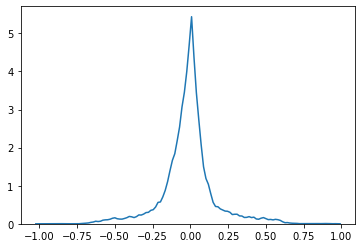

In [45]:
ax = sns.kdeplot(x_0)
ax.get_lines()[0].get_data()

### Thought experiment:
2000x2000 real comp dist scores vs 50Kx50K artificial dist scores (all features drawn with null model= normal dist) 

where do they all sit? 
How do they all compare?

In [ ]:
unitNormal_null_model = pd.DataFrame(np.random.normal(0,1,(50000,245)),index=pd.RangeIndex(50000),
                                     columns=[x for x in refData.columns if x!='WellID'])
unitNormal_nullModel_corDistMat = sp.spatial.distance.squareform(sp.spatial.distance.pdist(
    unitNormal_null_model.to_numpy(),'correlation'))
unitNormal_nullModel_corDistMat = unitNormal_nullModel_corDistMat.where(
    np.triu(np.ones(unitNormal_nullModel_corDistMat.shape)).astype(np.bool))

# data = pd.read_csv('allCPexps.csv',index_col=[0,1,2,3])
normal_null_model = pd.DataFrame({x:np.random.normal(np.mean(data[x]),np.std(data[x]),50000) for x in data.columns})
normal_nullModel_corDistMat = sp.spatial.distance.squareform(sp.spatial.distance.pdist(
    normal_null_model.to_numpy(),'correlation'))
normal_nullModel_corDistMat = normal_nullModel_corDistMat.where(
    np.triu(np.ones(normal_nullModel_corDistMat.shape)).astype(np.bool))

unitNormaldraws_null_model = pd.DataFrame({x:np.random.normal(np.mean(data[x]),np.std(data[x]),50000) for x in data.columns})
unitNormaldraws_nullModel_corDistMat = sp.spatial.distance.squareform(sp.spatial.distance.pdist(
    unitNormaldraws_null_model.to_numpy(),'correlation'))
unitNormaldraws_nullModel_corDistMat = unitNormaldraws_nullModel_corDistMat.where(
    np.triu(np.ones(unitNormaldraws_nullModel_corDistMat.shape)).astype(np.bool))

Might also need the ~2k real vs 50K artificial dist scores on the same plots as the pure nullModel distscores

3 null models to consider: 
1. unitNormal distribution for all features (and unit Normal noise added before draws)
2. normal distribution with feature's mean/std (and this normal distribution noise added before draws)
3. KDE of feature + scalar and renormalized before draws. (flattening the KDE..)

In [ ]:
ax = sns.distplot(unitNormal_nullModel_corDistMat.to_numpy().flatten(),kde_kws={'kernel':'gau','bw':'silverman','gridsize':1000},
                  color='red',label='unitNormal_nullmodel',kde=True,hist=False,rug=False)
sns.distplot(refData_50_corDistMat.to_numpy().flatten(),bins='auto',kde=True,rug=True,rug_kws={'height':0.03},
             hist_kws={'histtype':'stepfilled','alpha':0.5},ax=ax,label='50uM SChem pairwise CorDist')
sns.distplot(refData_10_corDistMat.to_numpy().flatten(),bins='auto',kde=True,rug=True,rug_kws={'height':0.025},
             hist_kws={'histtype':'stepfilled','alpha':0.5},ax=ax,label='10uM SChem pairwise CorDist')
plt.legend(loc='best')
plt.savefig('KDE_thought_exp_unitNormalNull.png')
plt.close()


ax = sns.distplot(normal_nullModel_corDistMat.to_numpy().flatten(),kde_kws={'kernel':'gau','bw':'silverman','gridsize':1000},
                  color='red',label='featureNormal_nullmodel',kde=True,hist=False,rug=False)
sns.distplot(refData_50_corDistMat.to_numpy().flatten(),bins='auto',kde=True,rug=True,rug_kws={'height':0.03},
             hist_kws={'histtype':'stepfilled','alpha':0.5},ax=ax,label='50uM SChem pairwise CorDist')
sns.distplot(refData_10_corDistMat.to_numpy().flatten(),bins='auto',kde=True,rug=True,rug_kws={'height':0.025},
             hist_kws={'histtype':'stepfilled','alpha':0.5},ax=ax,label='10uM SChem pairwise CorDist')
plt.legend(loc='best')
plt.savefig('KDE_thought_exp_featureNormalNull.png')
plt.close()


ax = sns.distplot(normal_nullModel_corDistMat.to_numpy().flatten(),kde_kws={'kernel':'gau','bw':'silverman','gridsize':1000},
                  color='red',label='featureNormal_nullmodel',kde=True,hist=False,rug=False)
sns.distplot(unitNormal_nullModel_corDistMat.to_numpy().flatten(),kde_kws={'kernel':'gau','bw':'silverman','gridsize':1000},
             color='blue',label='unitNormal_nullmodel',kde=True,hist=False,rug=False,ax=ax)
plt.legend(loc='best')
plt.savefig('KDE_thought_exp_NullModels.png')
plt.close()

#### Hummingbird interactive sessions:

In [ ]:
>>> import matplotlib.pyplot as plt, seaborn as sns, numpy as np, scipy as sp, pandas as pd, statsmodels as sm
>>> from scipy.spatial import distance as sp_distance
>>> from scipy import stats as sp_stats
>>> import os, sys, subprocess, itertools
>>> import KDEpy as kdeOpt
>>>
>>> #os.environ["MODIN_ENGINE"] = "ray"
... #os.environ["MODIN_CPUS"] = "2"
... #import modin.pandas as pd
...
>>> os.environ["MODIN_CPUS"] = "4"
>>> os.environ["MODIN_ENGINE"] = "ray"
>>> import modin.pandas as pd
>>> refData_corDistMat = pd.read_pickle('AllReferenceExp_20191018_commonFeaturesOrder_corDistMat.pkl.gz')
UserWarning: `read_pickle` defaulting to pandas implementation.
To request implementation, send an email to feature_requests@modin.org.
>>> key = pd.read_excel('../Mar2020_SChemInflam+NPFs_PRISMmod_annot.xlsx',sheet_name = -1)
UserWarning: Python 3.7 or higher required for parallel `read_excel`.
UserWarning: Parameters provided defaulting to pandas implementation.
>>> #sheet_name = -1,index_col=[0,9,8] #['SWID','DoseConcentration(mM)','CSCPlateID']
... labeledCompsPlates = [x for x in key.CSCPlateID.unique() if int(x[2:]) <1000 ]
>>>
>>> #slice out only SChem from the key
... SCHEM_key = key.loc[key.CSCPlateID.isin(labeledCompsPlates)]
>>> # convert the DoseConcentration(mM) into a float value
... SCHEM_key['DoseConcentration(mM)'] = SCHEM_key.loc[:,'DoseConcentration(mM)'].copy().astype(float).astype(str)
>>>
>>> filterSCHEM_key = SCHEM_key[~(SCHEM_key['PRISMmod_Class'].isin(['POSctrl','NEGctrl','Others','none']))].copy()
>>>
>>> nullModel_corDistMat = list()
>>> for nullModel,nullModelName in zip(nullModelFingerprints,['unitNormal','normalOnFeatures','postFlatten']):
...     nullModel_corDistMat.append(pd.read_pickle(f'{nullModelName}_nullModelDistMat.pkl.gz'))
...
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
NameError: name 'nullModelFingerprints' is not defined
>>> for nullModelName in ['unitNormal','normalOnFeatures','postFlatten']:
...     nullModel_corDistMat.append(pd.read_pickle(f'{nullModelName}_nullModelDistMat.pkl.gz'))
...
UserWarning: `read_pickle` defaulting to pandas implementation.

>>> ref50_plates = [x for x in labeledCompsPlates if int(x[2:])<142]
>>> ref50_plates
['SP0135', 'SP0136', 'SP0137', 'SP0138', 'SP0139', 'SP0140', 'SP0141']
>>> ref10_plates = [x for x in labeledCompsPlates if int(x[2:])>141]
>>> SCHEM_key.index
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4956, 4957, 4958, 4959, 4960, 4961, 4962, 4963, 4964, 4965],
           dtype='int64', length=4966)
>>> comps_50 = SCHEM_key.loc[SCHEM_key.CSCPlateID.isin(ref50_plates)][['SWID','DoseConcentration(mM)','CSCPlateID']].copy()
>>> comps_50
            SWID DoseConcentration(mM) CSCPlateID
0     SW100810-5                  10.0     SP0135
1     SW102053-5                  10.0     SP0135
2     SW148216-2                  10.0     SP0135
3     SW196369-4                  10.0     SP0135
4     SW196399-3                  10.0     SP0135
...          ...                   ...        ...
2478         NaN                  -1.0     SP0141
2479         NaN                  -1.0     SP0141
2480         NaN                  -1.0     SP0141
2481         NaN                  -1.0     SP0141
2482         NaN                  -1.0     SP0141

[2483 rows x 3 columns]
>>> comps_50 = filterSCHEM_key.loc[filterSCHEM_key.CSCPlateID.isin(ref50_plates)][['SWID','DoseConcentration(mM)','CSCPlateID']].copy()
>>> comps_50
            SWID DoseConcentration(mM) CSCPlateID
0     SW100810-5                  10.0     SP0135
1     SW102053-5                  10.0     SP0135
3     SW196369-4                  10.0     SP0135
4     SW196399-3                  10.0     SP0135
5     SW196414-3                  10.0     SP0135
...          ...                   ...        ...
2412  SW220297-1                  10.0     SP0141
2413  SW220299-1                  10.0     SP0141
2415  SW222230-1                  10.0     SP0141
2416  SW222232-1                  10.0     SP0141
2418  SW222245-1                  10.0     SP0141

[1621 rows x 3 columns]
>>> filterSCHEM_key_2 = SCHEM_key[~(SCHEM_key['PRISMmod_Class'].isin(['POSctrl','NEGctrl']))].copy()
KeyboardInterrupt
>>> comps_50=[tuple(comps_50.iloc[i].tolist()) for i in range(comps_50.shape[0])]
UserWarning: `Series.tolist` defaulting to pandas implementation.

>>>
>>> comps_10 = filterSCHEM_key.loc[filterSCHEM_key.CSCPlateID.isin(ref10_plates)][['SWID','DoseConcentration(mM)','CSCPlateID']].copy()
>>> comps_10=[tuple(comps_10.iloc[i].tolist()) for i in range(comps_10.shape[0])]

>>> comps_50
[('SW100810-5', '10.0', 'SP0135'), ('SW102053-5', '10.0', 'SP0135'), ('SW196369-4', '10.0', 'SP0135'), ('SW196399-3', '10.0', 'SP0135'), ('SW196414-3', '10.0', 'SP0135'), ('SW196570-5', '10.0', 'SP0135'), ('SW196583-4', '10.0', 'SP0135'), ('SW196598-4', '10.0', 'SP0135'), ('SW196607-4', '10.0', 'SP0135'), ('SW196678-4', '10.0', 'SP0135'), ('SW196707-3', '10.0', 'SP0135'), ('SW196786-4', '10.0', 'SP0135'), ('SW196834-3', '10.0', 'SP0135'), ('SW196888-4', '10.0', 'SP0135'), ('SW196913-4', '10.0', 'SP0135'), ('SW196934-4', '10.0', 'SP0135'), ('SW196942-4', '10.0', 'SP0135'), ('SW196970-2', '10.0', 'SP0135'), ('SW196972-3', '10.0', 'SP0135'), ('SW197099-3', '10.0', 'SP0135'), ('SW197151-3', '10.0', 'SP0135'), ('SW197177-4', '10.0', 'SP0135'), ('SW197226-4', '10.0', 'SP0135'), ('SW197275-2', '10.0', 'SP0135'), ('SW197282-4', '10.0', 'SP0135'), ('SW197294-4', '10.0', 'SP0135'), ('SW197344-4', '10.0', 'SP0135'), ('SW197416-3', '10.0', 'SP0135'), ('SW197468-3', '10.0', 'SP0135'), ('SW197490-3', '10.0', 'SP0135'), ('SW197496-2', '10.0', 'SP0135'), ('SW197500-4', '10.0', 'SP0135'), ('SW197531-3', '10.0', 'SP0135'), ('SW197551-3', '10.0', 'SP0135'), ('SW197554-3', '10.0', 'SP0135'), ('SW197557-5', '10.0', 'SP0135'), ('SW197558-3', '10.0', 'SP0135'), ('SW197570-3', '10.0', 'SP0135'), ('SW197571-2', '10.0', 'SP0135'), ('SW197581-4', '10.0', 'SP0135'), ('SW197591-3', '10.0', 'SP0135'), ('SW197596-2', '10.0', 'SP0135'), ('SW197598-2', '10.0', 'SP0135'), ('SW197609-3', '10.0', 'SP0135'), ('SW197620-3', '10.0', 'SP0135'), ('SW197624-3', '10.0', 'SP0135'), ('SW197633-2', '10.0', 'SP0135'), ('SW197637-2', '10.0', 'SP0135'), ('SW197639-3', '10.0', 'SP0135'), ('SW197705-2', '10.0', 'SP0135'), ('SW197739-4', '10.0', 'SP0135'), ('SW197746-4', '10.0', 'SP0135'), ('SW197805-4', '10.0', 'SP0135'), ('SW198601-3', '10.0', 'SP0135'), ('SW198937-2', '10.0', 'SP0135'), ('SW199052-2', '10.0', 'SP0135'), ('SW199053-2', '10.0', 'SP0135'), ('SW199068-2', '10.0', 'SP0135'), ('SW199090-2', '10.0', 'SP0135'), ('SW199095-2', '10.0', 'SP0135'), ('SW199101-4', '10.0', 'SP0135'), ('SW199108-4', '10.0', 'SP0135'), ('SW199135-2', '10.0', 'SP0135'), ('SW199198-2', '10.0', 'SP0135'), ('SW199536-4', '10.0', 'SP0135'), ('SW199611-3', '10.0', 'SP0135'), ('SW199616-2', '10.0', 'SP0135'), ('SW199617-3', '10.0', 'SP0135'), ('SW199641-2', '10.0', 'SP0135'), ('SW199664-3', '10.0', 'SP0135'), ('SW202555-3', '10.0', 'SP0135'), ('SW202556-4', '10.0', 'SP0135'), ('SW202557-3', '10.0', 'SP0135'), ('SW202562-3', '10.0', 'SP0135'), ('SW203749-3', '10.0', 'SP0135'), ('SW203763-2', '10.0', 'SP0135'), ('SW208076-5', '10.0', 'SP0135'), ('SW208077-3', '10.0', 'SP0135'), ('SW208681-3', '10.0', 'SP0135'), ('SW212665-2', '10.0', 'SP0135'), ('SW212828-2', '10.0', 'SP0135'), ('SW217688-2', '10.0', 'SP0135'), ('SW218039-2', '10.0', 'SP0135'), ('SW218076-2', '10.0', 'SP0135'), ('SW218080-2', '10.0', 'SP0135'), ('SW218082-2', '10.0', 'SP0135'), ('SW218083-2', '10.0', 'SP0135'), ('SW218084-2', '10.0', 'SP0135'), ('SW218086-2', '10.0', 'SP0135'), ('SW218087-2', '10.0', 'SP0135'), ('SW218091-2', '10.0', 'SP0135'), ('SW218092-2', '10.0', 'SP0135'), ('SW218095-2', '10.0', 'SP0135'), ('SW218097-2', '10.0', 'SP0135'), ('SW218101-2', '10.0', 'SP0135'), ('SW218104-2', '10.0', 'SP0135'), ('SW218106-2', '10.0', 'SP0135'), ('SW218110-2', '10.0', 'SP0135'), ('SW218112-2', '10.0', 'SP0135'), ('SW218117-2', '10.0', 'SP0135'), ('SW218119-2', '10.0', 'SP0135'), ('SW218124-2', '10.0', 'SP0135'), ('SW218125-2', '10.0', 'SP0135'), ('SW218126-2', '10.0', 'SP0135'), ('SW218129-2', '10.0', 'SP0135'), ('SW218130-2', '10.0', 'SP0135'), ('SW218136-2', '10.0', 'SP0135'), ('SW218138-2', '10.0', 'SP0135'), ('SW218141-2', '10.0', 'SP0135'), ('SW218142-2', '10.0', 'SP0135'), ('SW218144-2', '10.0', 'SP0135'), ('SW218146-2', '10.0', 'SP0135'), ('SW218150-2', '10.0', 'SP0135'), ('SW218151-2', '10.0', 'SP0135'), ('SW218152-2', '10.0', 'SP0135'), ('SW218156-2', '10.0', 'SP0135'), ('SW218162-2', '10.0', 'SP0135'), ('SW218249-2', '10.0', 'SP0135'), ('SW218254-2', '10.0', 'SP0135'), ('SW218266-2', '10.0', 'SP0135'), ('SW218289-2', '10.0', 'SP0135'), ('SW218300-2', '10.0', 'SP0135'), ('SW218301-2', '10.0', 'SP0135'), ('SW218311-2', '10.0', 'SP0135'), ('SW219057-1', '10.0', 'SP0135'), ('SW219069-1', '10.0', 'SP0135'), ('SW219073-1', '10.0', 'SP0135'), ('SW219079-1', '10.0', 'SP0135'), ('SW219083-1', '10.0', 'SP0135'), ('SW219086-1', '10.0', 'SP0135'), ('SW219089-1', '10.0', 'SP0135'), ('SW219099-1', '10.0', 'SP0135'), ('SW219130-1', '10.0', 'SP0135'), ('SW219138-1', '10.0', 'SP0135'), ('SW219140-1', '10.0', 'SP0135'), ('SW219159-1', '10.0', 'SP0135'), ('SW219160-1', '10.0', 'SP0135'), ('SW219161-1', '10.0', 'SP0135'), ('SW219169-2', '10.0', 'SP0135'), ('SW219171-1', '10.0', 'SP0135'), ('SW219173-1', '10.0', 'SP0135'), ('SW219175-1', '10.0', 'SP0135'), ('SW219177-1', '10.0', 'SP0135'), ('SW219187-1', '10.0', 'SP0135'), ('SW219192-2', '10.0', 'SP0135'), ('SW219197-1', '10.0', 'SP0135'), ('SW219204-1', '10.0', 'SP0135'), ('SW219218-1', '10.0', 'SP0135'), ('SW219227-1', '10.0', 'SP0135'), ('SW219245-1', '10.0', 'SP0135'), ('SW219246-1', '10.0', 'SP0135'), ('SW219247-1', '10.0', 'SP0135'), ('SW219248-1', '10.0', 'SP0135'), ('SW219255-1', '10.0', 'SP0135'), ('SW219256-1', '10.0', 'SP0135'), ('SW219259-1', '10.0', 'SP0135'), ('SW219261-1', '10.0', 'SP0135'), ('SW219267-1', '10.0', 'SP0135'), ('SW219272-1', '10.0', 'SP0135'), ('SW219279-1', '10.0', 'SP0135'), ('SW219280-1', '10.0', 'SP0135'), ('SW219282-1', '10.0', 'SP0135'), ('SW219288-1', '10.0', 'SP0135'), ('SW219297-1', '10.0', 'SP0135'), ('SW219302-1', '10.0', 'SP0135'), ('SW219303-1', '10.0', 'SP0135'), ('SW219315-1', '10.0', 'SP0135'), ('SW219319-1', '10.0', 'SP0135'), ('SW219364-1', '10.0', 'SP0135'), ('SW219366-1', '10.0', 'SP0135'), ('SW219369-1', '10.0', 'SP0135'), ('SW219373-1', '10.0', 'SP0135'), ('SW219385-1', '10.0', 'SP0135'), ('SW219388-1', '10.0', 'SP0135'), ('SW219390-1', '10.0', 'SP0135'), ('SW219391-1', '10.0', 'SP0135'), ('SW219392-1', '10.0', 'SP0135'), ('SW219394-1', '10.0', 'SP0135'), ('SW219395-1', '10.0', 'SP0135'), ('SW219396-1', '10.0', 'SP0135'), ('SW219398-1', '10.0', 'SP0135'), ('SW219407-1', '10.0', 'SP0135'), ('SW219415-1', '10.0', 'SP0135'), ('SW219416-1', '10.0', 'SP0135'), ('SW219420-1', '10.0', 'SP0135'), ('SW219421-1', '10.0', 'SP0135'), ('SW219422-1', '10.0', 'SP0135'), ('SW219425-1', '10.0', 'SP0135'), ('SW219427-1', '10.0', 'SP0135'), ('SW219430-1', '10.0', 'SP0135'), ('SW219431-1', '10.0', 'SP0135'), ('SW219439-1', '10.0', 'SP0135'), ('SW219441-1', '10.0', 'SP0135'), ('SW219445-1', '10.0', 'SP0135'), ('SW219447-1', '10.0', 'SP0135'), ('SW219452-1', '10.0', 'SP0135'), ('SW219453-1', '10.0', 'SP0135'), ('SW219457-1', '10.0', 'SP0135'), ('SW219462-1', '10.0', 'SP0135'), ('SW219463-1', '10.0', 'SP0135'), ('SW219468-1', '10.0', 'SP0135'), ('SW219478-1', '10.0', 'SP0135'), ('SW219491-1', '10.0', 'SP0135'), ('SW219504-1', '10.0', 'SP0135'), ('SW219506-1', '10.0', 'SP0135'), ('SW219527-1', '10.0', 'SP0135'), ('SW219538-1', '10.0', 'SP0135'), ('SW219544-1', '10.0', 'SP0135'), ('SW219547-1', '10.0', 'SP0135'), ('SW219550-1', '10.0', 'SP0135'), ('SW219554-1', '10.0', 'SP0135'), ('SW219559-1', '10.0', 'SP0135'), ('SW219567-1', '10.0', 'SP0135'), ('SW219580-1', '10.0', 'SP0135'), ('SW219584-1', '10.0', 'SP0135'), ('SW219602-1', '10.0', 'SP0135'), ('SW219604-1', '10.0', 'SP0135'), ('SW219610-1', '10.0', 'SP0135'), ('SW219620-1', '10.0', 'SP0135'), ('SW219627-1', '10.0', 'SP0135'), ('SW219642-1', '10.0', 'SP0135'), ('SW219643-1', '10.0', 'SP0135'), ('SW219664-1', '10.0', 'SP0135'), ('SW219667-1', '10.0', 'SP0135'), ('SW219671-1', '10.0', 'SP0135'), ('SW219685-1', '10.0', 'SP0135'), ('SW219691-1', '10.0', 'SP0135'), ('SW219693-1', '10.0', 'SP0135'), ('SW219712-1', '10.0', 'SP0135'), ('SW219738-1', '10.0', 'SP0135'), ('SW219740-1', '10.0', 'SP0135'), ('SW219747-1', '10.0', 'SP0135'), ('SW219749-1', '10.0', 'SP0135'), ('SW219754-1', '10.0', 'SP0135'), ('SW219767-1', '10.0', 'SP0135'), ('SW219768-1', '10.0', 'SP0135'), ('SW219770-1', '10.0', 'SP0135'), ('SW219771-1', '10.0', 'SP0135'), ('SW219775-1', '10.0', 'SP0135'), ('SW219778-1', '10.0', 'SP0135'), ('SW219784-1', '10.0', 'SP0135'), ('SW219787-1', '10.0', 'SP0135'), ('SW219790-1', '10.0', 'SP0135'), ('SW219796-1', '10.0', 'SP0135'), ('SW219797-1', '10.0', 'SP0135'), ('SW219803-1', '10.0', 'SP0135'), ('SW219808-1', '10.0', 'SP0135'), ('SW219818-1', '10.0', 'SP0135'), ('SW219827-1', '10.0', 'SP0135'), ('SW219830-1', '10.0', 'SP0135'), ('SW219839-1', '10.0', 'SP0135'), ('SW219841-1', '10.0', 'SP0135'), ('SW219842-1', '10.0', 'SP0135'), ('SW219847-1', '10.0', 'SP0135'), ('SW219850-1', '10.0', 'SP0135'), ('SW219855-1', '10.0', 'SP0135'), ('SW219869-1', '10.0', 'SP0135'), ('SW219879-1', '10.0', 'SP0135'), ('SW219882-1', '10.0', 'SP0135'), ('SW219884-1', '10.0', 'SP0135'), ('SW219886-1', '10.0', 'SP0135'), ('SW219893-1', '10.0', 'SP0135'), ('SW219896-1', '10.0', 'SP0135'), ('SW219897-1', '10.0', 'SP0135'), ('SW219927-1', '10.0', 'SP0135'), ('SW219932-1', '10.0', 'SP0135'), ('SW219934-1', '10.0', 'SP0135'), ('SW219939-1', '10.0', 'SP0135'), ('SW219940-1', '10.0', 'SP0135'), ('SW219953-1', '10.0', 'SP0135'), ('SW219971-1', '10.0', 'SP0135'), ('SW219991-1', '10.0', 'SP0135'), ('SW220005-1', '10.0', 'SP0135'), ('SW220006-1', '10.0', 'SP0135'), ('SW220010-1', '10.0', 'SP0135'), ('SW220013-1', '10.0', 'SP0135'), ('SW220068-1', '10.0', 'SP0135'), ('SW220119-1', '10.0', 'SP0135'), ('SW220144-1', '10.0', 'SP0135'), ('SW220151-1', '10.0', 'SP0135'), ('SW220162-1', '10.0', 'SP0135'), ('SW220163-1', '10.0', 'SP0135'), ('SW220171-1', '10.0', 'SP0135'), ('SW220182-1', '10.0', 'SP0135'), ('SW220186-1', '10.0', 'SP0135'), ('SW220187-1', '10.0', 'SP0135'), ('SW220195-1', '10.0', 'SP0135'), ('SW220197-1', '10.0', 'SP0135'), ('SW220199-1', '10.0', 'SP0135'), ('SW220203-1', '10.0', 'SP0135'), ('SW220241-1', '10.0', 'SP0135'), ('SW220251-1', '10.0', 'SP0135'), ('SW220252-1', '10.0', 'SP0135'), ('SW220253-1', '10.0', 'SP0135'), ('SW220254-1', '10.0', 'SP0135'), ('SW220258-1', '10.0', 'SP0135'), ('SW220269-1', '10.0', 'SP0135'), ('SW220273-1', '10.0', 'SP0135'), ('SW220274-1', '10.0', 'SP0135'), ('SW220279-1', '10.0', 'SP0135'), ('SW220281-1', '10.0', 'SP0135'), ('SW220282-1', '10.0', 'SP0135'), ('SW220298-1', '10.0', 'SP0135'), ('SW222224-1', '10.0', 'SP0135'), ('SW222225-1', '10.0', 'SP0135'), ('SW222226-1', '10.0', 'SP0135'), ('SW222227-1', '10.0', 'SP0135'), ('SW222338-1', '10.0', 'SP0135'), ('SW060653-4', '10.0', 'SP0136'), ('SW102176-4', '10.0', 'SP0136'), ('SW149624-4', '10.0', 'SP0136'), ('SW167762-4', '10.0', 'SP0136'), ('SW196221-2', '10.0', 'SP0136'), ('SW196324-3', '10.0', 'SP0136'), ('SW196353-3', '10.0', 'SP0136'), ('SW196372-4', '10.0', 'SP0136'), ('SW196380-2', '10.0', 'SP0136'), ('SW196404-3', '10.0', 'SP0136'), ('SW196431-5', '10.0', 'SP0136'), ('SW196448-3', '10.0', 'SP0136'), ('SW196450-4', '10.0', 'SP0136'), ('SW196456-3', '10.0', 'SP0136'), ('SW196457-4', '10.0', 'SP0136'), ('SW196458-3', '10.0', 'SP0136'), ('SW196502-4', '10.0', 'SP0136'), ('SW196508-3', '10.0', 'SP0136'), ('SW196530-3', '10.0', 'SP0136'), ('SW196536-4', '10.0', 'SP0136'), ('SW196550-3', '10.0', 'SP0136'), ('SW196569-3', '10.0', 'SP0136'), ('SW196619-3', '10.0', 'SP0136'), ('SW196637-3', '10.0', 'SP0136'), ('SW196645-3', '10.0', 'SP0136'), ('SW196657-3', '10.0', 'SP0136'), ('SW196670-3', '10.0', 'SP0136'), ('SW196682-3', '10.0', 'SP0136'), ('SW196691-3', '10.0', 'SP0136'), ('SW196698-3', '10.0', 'SP0136'), ('SW196745-6', '10.0', 'SP0136'), ('SW196752-3', '10.0', 'SP0136'), ('SW196753-3', '10.0', 'SP0136'), ('SW196783-3', '10.0', 'SP0136'), ('SW196784-3', '10.0', 'SP0136'), ('SW196785-3', '10.0', 'SP0136'), ('SW196787-3', '10.0', 'SP0136'), ('SW196805-4', '10.0', 'SP0136'), ('SW196830-3', '10.0', 'SP0136'), ('SW196835-3', '10.0', 'SP0136'), ('SW196872-3', '10.0', 'SP0136'), ('SW196887-4', '10.0', 'SP0136'), ('SW196895-3', '10.0', 'SP0136'), ('SW196917-4', '10.0', 'SP0136'), ('SW196917-5', '10.0', 'SP0136'), ('SW196940-3', '10.0', 'SP0136'), ('SW196944-3', '10.0', 'SP0136'), ('SW196945-3', '10.0', 'SP0136'), ('SW196947-3', '10.0', 'SP0136'), ('SW196966-4', '10.0', 'SP0136'), ('SW196973-3', '10.0', 'SP0136'), ('SW196979-4', '10.0', 'SP0136'), ('SW196997-3', '10.0', 'SP0136'), ('SW197104-2', '10.0', 'SP0136'), ('SW197105-3', '10.0', 'SP0136'), ('SW197135-3', '10.0', 'SP0136'), ('SW197137-4', '10.0', 'SP0136'), ('SW197229-3', '10.0', 'SP0136'), ('SW197244-4', '10.0', 'SP0136'), ('SW197278-3', '10.0', 'SP0136'), ('SW197284-3', '10.0', 'SP0136'), ('SW197293-4', '10.0', 'SP0136'), ('SW197303-4', '10.0', 'SP0136'), ('SW197338-3', '10.0', 'SP0136'), ('SW197348-4', '10.0', 'SP0136'), ('SW197364-4', '10.0', 'SP0136'), ('SW197393-3', '10.0', 'SP0136'), ('SW197397-2', '10.0', 'SP0136'), ('SW197477-2', '10.0', 'SP0136'), ('SW197522-2', '10.0', 'SP0136'), ('SW197542-3', '10.0', 'SP0136'), ('SW197547-3', '10.0', 'SP0136'), ('SW197561-4', '10.0', 'SP0136'), ('SW197569-2', '10.0', 'SP0136'), ('SW197573-5', '10.0', 'SP0136'), ('SW197582-2', '10.0', 'SP0136'), ('SW197614-3', '10.0', 'SP0136'), ('SW197623-3', '10.0', 'SP0136'), ('SW197626-2', '10.0', 'SP0136'), ('SW197646-3', '10.0', 'SP0136'), ('SW197658-2', '10.0', 'SP0136'), ('SW197669-2', '10.0', 'SP0136'), ('SW197676-3', '10.0', 'SP0136'), ('SW197702-3', '10.0', 'SP0136'), ('SW197779-3', '10.0', 'SP0136'), ('SW197784-4', '10.0', 'SP0136'), ('SW198484-2', '10.0', 'SP0136'), ('SW198497-2', '10.0', 'SP0136'), ('SW198560-2', '10.0', 'SP0136'), ('SW198590-2', '10.0', 'SP0136'), ('SW198618-2', '10.0', 'SP0136'), ('SW198619-2', '10.0', 'SP0136'), ('SW198780-2', '10.0', 'SP0136'), ('SW198927-2', '10.0', 'SP0136'), ('SW199029-2', '10.0', 'SP0136'), ('SW199101-5', '10.0', 'SP0136'), ('SW199113-2', '10.0', 'SP0136'), ('SW199147-2', '10.0', 'SP0136'), ('SW199199-2', '10.0', 'SP0136'), ('SW199286-2', '10.0', 'SP0136'), ('SW199406-4', '10.0', 'SP0136'), ('SW199450-2', '10.0', 'SP0136'), ('SW199597-2', '10.0', 'SP0136'), ('SW199606-2', '10.0', 'SP0136'), ('SW199612-2', '10.0', 'SP0136'), ('SW199632-2', '10.0', 'SP0136'), ('SW199649-2', '10.0', 'SP0136'), ('SW199650-2', '10.0', 'SP0136'), ('SW199659-2', '10.0', 'SP0136'), ('SW199663-2', '10.0', 'SP0136'), ('SW203738-2', '10.0', 'SP0136'), ('SW203810-3', '10.0', 'SP0136'), ('SW218071-2', '10.0', 'SP0136'), ('SW218099-2', '10.0', 'SP0136'), ('SW218107-2', '10.0', 'SP0136'), ('SW218114-2', '10.0', 'SP0136'), ('SW218122-2', '10.0', 'SP0136'), ('SW218131-2', '10.0', 'SP0136'), ('SW218139-2', '10.0', 'SP0136'), ('SW218147-2', '10.0', 'SP0136'), ('SW218155-2', '10.0', 'SP0136'), ('SW218287-2', '10.0', 'SP0136'), ('SW219052-1', '10.0', 'SP0136'), ('SW219054-1', '10.0', 'SP0136'), ('SW219060-1', '10.0', 'SP0136'), ('SW219062-1', '10.0', 'SP0136'), ('SW219133-1', '10.0', 'SP0136'), ('SW219142-1', '10.0', 'SP0136'), ('SW219144-1', '10.0', 'SP0136'), ('SW219163-1', '10.0', 'SP0136'), ('SW219164-1', '10.0', 'SP0136'), ('SW219166-1', '10.0', 'SP0136'), ('SW219169-1', '10.0', 'SP0136'), ('SW219212-1', '10.0', 'SP0136'), ('SW219238-1', '10.0', 'SP0136'), ('SW219254-1', '10.0', 'SP0136'), ('SW219262-1', '10.0', 'SP0136'), ('SW219263-1', '10.0', 'SP0136'), ('SW219268-1', '10.0', 'SP0136'), ('SW219269-1', '10.0', 'SP0136'), ('SW219283-1', '10.0', 'SP0136'), ('SW219298-1', '10.0', 'SP0136'), ('SW219299-1', '10.0', 'SP0136'), ('SW219300-1', '10.0', 'SP0136'), ('SW219351-1', '10.0', 'SP0136'), ('SW219356-1', '10.0', 'SP0136'), ('SW219361-1', '10.0', 'SP0136'), ('SW219380-1', '10.0', 'SP0136'), ('SW219383-1', '10.0', 'SP0136'), ('SW219404-1', '10.0', 'SP0136'), ('SW219406-1', '10.0', 'SP0136'), ('SW219410-1', '10.0', 'SP0136'), ('SW219411-1', '10.0', 'SP0136'), ('SW219418-1', '10.0', 'SP0136'), ('SW219444-1', '10.0', 'SP0136'), ('SW219451-1', '10.0', 'SP0136'), ('SW219456-1', '10.0', 'SP0136'), ('SW219483-1', '10.0', 'SP0136'), ('SW219562-1', '10.0', 'SP0136'), ('SW219591-1', '10.0', 'SP0136'), ('SW219595-1', '10.0', 'SP0136'), ('SW219597-1', '10.0', 'SP0136'), ('SW219599-1', '10.0', 'SP0136'), ('SW219605-1', '10.0', 'SP0136'), ('SW219607-2', '10.0', 'SP0136'), ('SW219609-1', '10.0', 'SP0136'), ('SW219612-1', '10.0', 'SP0136'), ('SW219634-1', '10.0', 'SP0136'), ('SW219635-1', '10.0', 'SP0136'), ('SW219636-1', '10.0', 'SP0136'), ('SW219641-1', '10.0', 'SP0136'), ('SW219651-1', '10.0', 'SP0136'), ('SW219665-1', '10.0', 'SP0136'), ('SW219686-1', '10.0', 'SP0136'), ('SW219687-1', '10.0', 'SP0136'), ('SW219699-1', '10.0', 'SP0136'), ('SW219700-1', '10.0', 'SP0136'), ('SW219706-1', '10.0', 'SP0136'), ('SW219717-1', '10.0', 'SP0136'), ('SW219721-1', '10.0', 'SP0136'), ('SW219734-1', '10.0', 'SP0136'), ('SW219765-1', '10.0', 'SP0136'), ('SW219785-1', '10.0', 'SP0136'), ('SW219798-1', '10.0', 'SP0136'), ('SW219826-1', '10.0', 'SP0136'), ('SW219829-1', '10.0', 'SP0136'), ('SW219840-1', '10.0', 'SP0136'), ('SW219858-1', '10.0', 'SP0136'), ('SW219862-1', '10.0', 'SP0136'), ('SW219874-1', '10.0', 'SP0136'), ('SW219898-1', '10.0', 'SP0136'), ('SW219911-1', '10.0', 'SP0136'), ('SW219912-1', '10.0', 'SP0136'), ('SW219921-1', '10.0', 'SP0136'), ('SW219933-1', '10.0', 'SP0136'), ('SW219935-1', '10.0', 'SP0136'), ('SW219957-1', '10.0', 'SP0136'), ('SW219964-1', '10.0', 'SP0136'), ('SW219973-1', '10.0', 'SP0136'), ('SW219974-1', '10.0', 'SP0136'), ('SW219983-1', '10.0', 'SP0136'), ('SW219985-1', '10.0', 'SP0136'), ('SW219996-1', '10.0', 'SP0136'), ('SW220017-1', '10.0', 'SP0136'), ('SW220022-1', '10.0', 'SP0136'), ('SW220041-1', '10.0', 'SP0136'), ('SW220050-1', '10.0', 'SP0136'), ('SW220087-1', '10.0', 'SP0136'), ('SW220093-1', '10.0', 'SP0136'), ('SW220125-1', '10.0', 'SP0136'), ('SW220138-1', '10.0', 'SP0136'), ('SW220141-1', '10.0', 'SP0136'), ('SW220150-1', '10.0', 'SP0136'), ('SW220155-1', '10.0', 'SP0136'), ('SW220172-1', '10.0', 'SP0136'), ('SW220177-1', '10.0', 'SP0136'), ('SW220224-1', '10.0', 'SP0136'), ('SW220228-1', '10.0', 'SP0136'), ('SW220237-1', '10.0', 'SP0136'), ('SW220240-1', '10.0', 'SP0136'), ('SW220256-1', '10.0', 'SP0136'), ('SW220262-1', '10.0', 'SP0136'), ('SW220263-1', '10.0', 'SP0136'), ('SW220271-1', '10.0', 'SP0136'), ('SW220283-1', '10.0', 'SP0136'), ('SW220302-1', '10.0', 'SP0136'), ('SW220306-1', '10.0', 'SP0136'), ('SW222228-1', '10.0', 'SP0136'), ('SW222229-1', '10.0', 'SP0136'), ('SW000346-2', '10.0', 'SP0137'), ('SW101224-2', '10.0', 'SP0137'), ('SW148203-4', '10.0', 'SP0137'), ('SW196333-5', '10.0', 'SP0137'), ('SW196373-5', '10.0', 'SP0137'), ('SW196384-4', '10.0', 'SP0137'), ('SW196391-3', '10.0', 'SP0137'), ('SW196411-3', '10.0', 'SP0137'), ('SW196433-3', '10.0', 'SP0137'), ('SW196544-3', '10.0', 'SP0137'), ('SW196552-2', '10.0', 'SP0137'), ('SW196570-4', '10.0', 'SP0137'), ('SW196602-3', '10.0', 'SP0137'), ('SW196616-2', '10.0', 'SP0137'), ('SW196632-3', '10.0', 'SP0137'), ('SW196633-2', '10.0', 'SP0137'), ('SW196642-2', '10.0', 'SP0137'), ('SW196681-3', '10.0', 'SP0137'), ('SW196701-3', '10.0', 'SP0137'), ('SW196731-3', '10.0', 'SP0137'), ('SW196782-3', '10.0', 'SP0137'), ('SW196823-6', '10.0', 'SP0137'), ('SW196824-3', '10.0', 'SP0137'), ('SW196866-2', '10.0', 'SP0137'), ('SW196882-3', '10.0', 'SP0137'), ('SW196898-3', '10.0', 'SP0137'), ('SW196931-3', '10.0', 'SP0137'), ('SW196964-3', '10.0', 'SP0137'), ('SW196989-3', '10.0', 'SP0137'), ('SW196994-3', '10.0', 'SP0137'), ('SW197006-3', '10.0', 'SP0137'), ('SW197015-3', '10.0', 'SP0137'), ('SW197026-2', '10.0', 'SP0137'), ('SW197031-3', '10.0', 'SP0137'), ('SW197043-4', '10.0', 'SP0137'), ('SW197045-3', '10.0', 'SP0137'), ('SW197051-3', '10.0', 'SP0137'), ('SW197103-2', '10.0', 'SP0137'), ('SW197138-3', '10.0', 'SP0137'), ('SW197163-3', '10.0', 'SP0137'), ('SW197197-2', '10.0', 'SP0137'), ('SW197199-2', '10.0', 'SP0137'), ('SW197202-3', '10.0', 'SP0137'), ('SW197212-2', '10.0', 'SP0137'), ('SW197214-4', '10.0', 'SP0137'), ('SW197214-5', '10.0', 'SP0137'), ('SW197254-3', '10.0', 'SP0137'), ('SW197287-3', '10.0', 'SP0137'), ('SW197308-3', '10.0', 'SP0137'), ('SW197327-3', '10.0', 'SP0137'), ('SW197369-5', '10.0', 'SP0137'), ('SW197453-4', '10.0', 'SP0137'), ('SW197471-3', '10.0', 'SP0137'), ('SW197494-3', '10.0', 'SP0137'), ('SW197495-2', '10.0', 'SP0137'), ('SW197528-2', '10.0', 'SP0137'), ('SW197539-2', '10.0', 'SP0137'), ('SW197566-2', '10.0', 'SP0137'), ('SW197573-4', '10.0', 'SP0137'), ('SW197573-6', '10.0', 'SP0137'), ('SW197593-2', '10.0', 'SP0137'), ('SW197681-3', '10.0', 'SP0137'), ('SW197771-3', '10.0', 'SP0137'), ('SW197790-4', '10.0', 'SP0137'), ('SW197805-5', '10.0', 'SP0137'), ('SW198799-2', '10.0', 'SP0137'), ('SW199393-2', '10.0', 'SP0137'), ('SW199608-2', '10.0', 'SP0137'), ('SW203757-2', '10.0', 'SP0137'), ('SW218115-2', '10.0', 'SP0137'), ('SW218123-2', '10.0', 'SP0137'), ('SW218133-2', '10.0', 'SP0137'), ('SW218140-2', '10.0', 'SP0137'), ('SW218149-2', '10.0', 'SP0137'), ('SW218157-2', '10.0', 'SP0137'), ('SW218262-2', '10.0', 'SP0137'), ('SW219041-1', '10.0', 'SP0137'), ('SW219043-1', '10.0', 'SP0137'), ('SW219049-1', '10.0', 'SP0137'), ('SW219051-1', '10.0', 'SP0137'), ('SW219065-1', '10.0', 'SP0137'), ('SW219072-1', '10.0', 'SP0137'), ('SW219075-1', '10.0', 'SP0137'), ('SW219077-1', '10.0', 'SP0137'), ('SW219084-1', '10.0', 'SP0137'), ('SW219087-1', '10.0', 'SP0137'), ('SW219096-1', '10.0', 'SP0137'), ('SW219105-1', '10.0', 'SP0137'), ('SW219114-1', '10.0', 'SP0137'), ('SW219122-1', '10.0', 'SP0137'), ('SW219123-1', '10.0', 'SP0137'), ('SW219124-1', '10.0', 'SP0137'), ('SW219125-1', '10.0', 'SP0137'), ('SW219131-1', '10.0', 'SP0137'), ('SW219132-1', '10.0', 'SP0137'), ('SW219134-1', '10.0', 'SP0137'), ('SW219136-1', '10.0', 'SP0137'), ('SW219143-1', '10.0', 'SP0137'), ('SW219146-1', '10.0', 'SP0137'), ('SW219154-1', '10.0', 'SP0137'), ('SW219170-1', '10.0', 'SP0137'), ('SW219172-1', '10.0', 'SP0137'), ('SW219180-1', '10.0', 'SP0137'), ('SW219182-1', '10.0', 'SP0137'), ('SW219225-1', '10.0', 'SP0137'), ('SW219232-1', '10.0', 'SP0137'), ('SW219234-1', '10.0', 'SP0137'), ('SW219240-1', '10.0', 'SP0137'), ('SW219241-1', '10.0', 'SP0137'), ('SW219244-1', '10.0', 'SP0137'), ('SW219250-1', '10.0', 'SP0137'), ('SW219254-2', '10.0', 'SP0137'), ('SW219260-1', '10.0', 'SP0137'), ('SW219270-1', '10.0', 'SP0137'), ('SW219274-1', '10.0', 'SP0137'), ('SW219274-2', '10.0', 'SP0137'), ('SW219275-1', '10.0', 'SP0137'), ('SW219281-1', '10.0', 'SP0137'), ('SW219287-1', '10.0', 'SP0137'), ('SW219290-1', '10.0', 'SP0137'), ('SW219293-1', '10.0', 'SP0137'), ('SW219295-1', '10.0', 'SP0137'), ('SW219308-1', '10.0', 'SP0137'), ('SW219313-1', '10.0', 'SP0137'), ('SW219324-1', '10.0', 'SP0137'), ('SW219329-1', '10.0', 'SP0137'), ('SW219330-1', '10.0', 'SP0137'), ('SW219331-1', '10.0', 'SP0137'), ('SW219333-1', '10.0', 'SP0137'), ('SW219339-1', '10.0', 'SP0137'), ('SW219344-1', '10.0', 'SP0137'), ('SW219346-1', '10.0', 'SP0137'), ('SW219347-1', '10.0', 'SP0137'), ('SW219348-1', '10.0', 'SP0137'), ('SW219409-1', '10.0', 'SP0137'), ('SW219417-1', '10.0', 'SP0137'), ('SW219428-1', '10.0', 'SP0137'), ('SW219434-1', '10.0', 'SP0137'), ('SW219438-1', '10.0', 'SP0137'), ('SW219446-1', '10.0', 'SP0137'), ('SW219459-1', '10.0', 'SP0137'), ('SW219460-1', '10.0', 'SP0137'), ('SW219461-1', '10.0', 'SP0137'), ('SW219469-1', '10.0', 'SP0137'), ('SW219486-1', '10.0', 'SP0137'), ('SW219490-1', '10.0', 'SP0137'), ('SW219495-1', '10.0', 'SP0137'), ('SW219526-1', '10.0', 'SP0137'), ('SW219532-1', '10.0', 'SP0137'), ('SW219556-1', '10.0', 'SP0137'), ('SW219560-1', '10.0', 'SP0137'), ('SW219576-1', '10.0', 'SP0137'), ('SW219582-1', '10.0', 'SP0137'), ('SW219586-1', '10.0', 'SP0137'), ('SW219592-1', '10.0', 'SP0137'), ('SW219593-1', '10.0', 'SP0137'), ('SW219594-1', '10.0', 'SP0137'), ('SW219608-1', '10.0', 'SP0137'), ('SW219613-1', '10.0', 'SP0137'), ('SW219621-1', '10.0', 'SP0137'), ('SW219623-1', '10.0', 'SP0137'), ('SW219628-1', '10.0', 'SP0137'), ('SW219637-1', '10.0', 'SP0137'), ('SW219652-1', '10.0', 'SP0137'), ('SW219654-1', '10.0', 'SP0137'), ('SW219658-1', '10.0', 'SP0137'), ('SW219659-1', '10.0', 'SP0137'), ('SW219662-1', '10.0', 'SP0137'), ('SW219676-1', '10.0', 'SP0137'), ('SW219679-1', '10.0', 'SP0137'), ('SW219680-1', '10.0', 'SP0137'), ('SW219688-1', '10.0', 'SP0137'), ('SW219692-1', '10.0', 'SP0137'), ('SW219694-1', '10.0', 'SP0137'), ('SW219716-1', '10.0', 'SP0137'), ('SW219720-1', '10.0', 'SP0137'), ('SW219728-1', '10.0', 'SP0137'), ('SW219732-1', '10.0', 'SP0137'), ('SW219737-1', '10.0', 'SP0137'), ('SW219741-1', '10.0', 'SP0137'), ('SW219743-1', '10.0', 'SP0137'), ('SW219744-1', '10.0', 'SP0137'), ('SW219756-1', '10.0', 'SP0137'), ('SW219759-1', '10.0', 'SP0137'), ('SW219772-1', '10.0', 'SP0137'), ('SW219780-1', '10.0', 'SP0137'), ('SW219800-1', '10.0', 'SP0137'), ('SW219810-1', '10.0', 'SP0137'), ('SW219821-1', '10.0', 'SP0137'), ('SW219823-1', '10.0', 'SP0137'), ('SW219849-1', '10.0', 'SP0137'), ('SW219852-1', '10.0', 'SP0137'), ('SW219885-1', '10.0', 'SP0137'), ('SW219892-1', '10.0', 'SP0137'), ('SW219894-1', '10.0', 'SP0137'), ('SW219906-1', '10.0', 'SP0137'), ('SW219908-1', '10.0', 'SP0137'), ('SW219915-1', '10.0', 'SP0137'), ('SW219916-1', '10.0', 'SP0137'), ('SW219920-1', '10.0', 'SP0137'), ('SW219923-1', '10.0', 'SP0137'), ('SW219930-1', '10.0', 'SP0137'), ('SW219936-1', '10.0', 'SP0137'), ('SW219952-1', '10.0', 'SP0137'), ('SW219958-1', '10.0', 'SP0137'), ('SW219960-1', '10.0', 'SP0137'), ('SW219962-1', '10.0', 'SP0137'), ('SW219970-1', '10.0', 'SP0137'), ('SW219990-1', '10.0', 'SP0137'), ('SW219999-1', '10.0', 'SP0137'), ('SW220011-1', '10.0', 'SP0137'), ('SW220012-1', '10.0', 'SP0137'), ('SW220024-1', '10.0', 'SP0137'), ('SW220027-1', '10.0', 'SP0137'), ('SW220044-1', '10.0', 'SP0137'), ('SW220052-1', '10.0', 'SP0137'), ('SW220053-1', '10.0', 'SP0137'), ('SW220057-1', '10.0', 'SP0137'), ('SW220143-1', '10.0', 'SP0137'), ('SW220152-1', '10.0', 'SP0137'), ('SW220169-1', '10.0', 'SP0137'), ('SW220176-1', '10.0', 'SP0137'), ('SW220196-1', '10.0', 'SP0137'), ('SW220198-1', '10.0', 'SP0137'), ('SW220211-1', '10.0', 'SP0137'), ('SW220212-1', '10.0', 'SP0137'), ('SW220226-1', '10.0', 'SP0137'), ('SW220229-1', '10.0', 'SP0137'), ('SW220233-1', '10.0', 'SP0137'), ('SW220246-1', '10.0', 'SP0137'), ('SW220247-1', '10.0', 'SP0137'), ('SW220248-1', '10.0', 'SP0137'), ('SW220272-1', '10.0', 'SP0137'), ('SW220275-1', '10.0', 'SP0137'), ('SW220280-1', '10.0', 'SP0137'), ('SW220289-1', '10.0', 'SP0137'), ('SW220294-1', '10.0', 'SP0137'), ('SW220296-1', '10.0', 'SP0137'), ('SW220305-1', '10.0', 'SP0137'), ('SW220315-1', '10.0', 'SP0137'), ('SW222231-1', '10.0', 'SP0137'), ('SW102000-2', '10.0', 'SP0138'), ('SW113275-2', '10.0', 'SP0138'), ('SW131228-2', '10.0', 'SP0138'), ('SW148473-2', '10.0', 'SP0138'), ('SW149625-4', '10.0', 'SP0138'), ('SW168675-6', '10.0', 'SP0138'), ('SW196332-3', '10.0', 'SP0138'), ('SW196337-3', '10.0', 'SP0138'), ('SW196343-3', '10.0', 'SP0138'), ('SW196388-3', '10.0', 'SP0138'), ('SW196396-3', '10.0', 'SP0138'), ('SW196475-3', '10.0', 'SP0138'), ('SW196529-3', '10.0', 'SP0138'), ('SW196577-3', '10.0', 'SP0138'), ('SW196705-3', '10.0', 'SP0138'), ('SW196713-3', '10.0', 'SP0138'), ('SW196719-3', '10.0', 'SP0138'), ('SW196774-3', '10.0', 'SP0138'), ('SW196831-3', '10.0', 'SP0138'), ('SW196923-4', '10.0', 'SP0138'), ('SW196969-3', '10.0', 'SP0138'), ('SW196982-3', '10.0', 'SP0138'), ('SW196985-3', '10.0', 'SP0138'), ('SW196995-3', '10.0', 'SP0138'), ('SW197001-3', '10.0', 'SP0138'), ('SW197005-3', '10.0', 'SP0138'), ('SW197011-3', '10.0', 'SP0138'), ('SW197022-4', '10.0', 'SP0138'), ('SW197085-3', '10.0', 'SP0138'), ('SW197098-3', '10.0', 'SP0138'), ('SW197103-3', '10.0', 'SP0138'), ('SW197152-3', '10.0', 'SP0138'), ('SW197242-4', '10.0', 'SP0138'), ('SW197285-3', '10.0', 'SP0138'), ('SW197446-3', '10.0', 'SP0138'), ('SW197457-4', '10.0', 'SP0138'), ('SW197462-2', '10.0', 'SP0138'), ('SW197486-3', '10.0', 'SP0138'), ('SW197504-3', '10.0', 'SP0138'), ('SW197509-3', '10.0', 'SP0138'), ('SW197648-2', '10.0', 'SP0138'), ('SW197754-2', '10.0', 'SP0138'), ('SW197792-3', '10.0', 'SP0138'), ('SW198791-2', '10.0', 'SP0138'), ('SW198832-2', '10.0', 'SP0138'), ('SW199035-2', '10.0', 'SP0138'), ('SW199401-2', '10.0', 'SP0138'), ('SW199566-2', '10.0', 'SP0138'), ('SW199568-2', '10.0', 'SP0138'), ('SW199648-2', '10.0', 'SP0138'), ('SW199665-2', '10.0', 'SP0138'), ('SW203813-2', '10.0', 'SP0138'), ('SW203830-2', '10.0', 'SP0138'), ('SW212797-2', '10.0', 'SP0138'), ('SW218082-3', '10.0', 'SP0138'), ('SW218089-2', '10.0', 'SP0138'), ('SW218090-2', '10.0', 'SP0138'), ('SW218093-2', '10.0', 'SP0138'), ('SW218096-2', '10.0', 'SP0138'), ('SW218185-2', '10.0', 'SP0138'), ('SW218187-2', '10.0', 'SP0138'), ('SW218198-2', '10.0', 'SP0138'), ('SW218246-2', '10.0', 'SP0138'), ('SW218293-2', '10.0', 'SP0138'), ('SW218309-2', '10.0', 'SP0138'), ('SW219039-1', '10.0', 'SP0138'), ('SW219042-1', '10.0', 'SP0138'), ('SW219047-1', '10.0', 'SP0138'), ('SW219055-1', '10.0', 'SP0138'), ('SW219056-1', '10.0', 'SP0138'), ('SW219058-1', '10.0', 'SP0138'), ('SW219082-1', '10.0', 'SP0138'), ('SW219085-1', '10.0', 'SP0138'), ('SW219088-1', '10.0', 'SP0138'), ('SW219101-1', '10.0', 'SP0138'), ('SW219104-1', '10.0', 'SP0138'), ('SW219116-1', '10.0', 'SP0138'), ('SW219119-1', '10.0', 'SP0138'), ('SW219128-1', '10.0', 'SP0138'), ('SW219137-1', '10.0', 'SP0138'), ('SW219139-1', '10.0', 'SP0138'), ('SW219141-1', '10.0', 'SP0138'), ('SW219152-1', '10.0', 'SP0138'), ('SW219153-1', '10.0', 'SP0138'), ('SW219155-1', '10.0', 'SP0138'), ('SW219158-1', '10.0', 'SP0138'), ('SW219167-1', '10.0', 'SP0138'), ('SW219176-1', '10.0', 'SP0138'), ('SW219184-1', '10.0', 'SP0138'), ('SW219185-1', '10.0', 'SP0138'), ('SW219186-1', '10.0', 'SP0138'), ('SW219194-1', '10.0', 'SP0138'), ('SW219195-1', '10.0', 'SP0138'), ('SW219196-1', '10.0', 'SP0138'), ('SW219198-2', '10.0', 'SP0138'), ('SW219202-1', '10.0', 'SP0138'), ('SW219205-1', '10.0', 'SP0138'), ('SW219209-1', '10.0', 'SP0138'), ('SW219214-1', '10.0', 'SP0138'), ('SW219217-1', '10.0', 'SP0138'), ('SW219221-1', '10.0', 'SP0138'), ('SW219222-1', '10.0', 'SP0138'), ('SW219231-1', '10.0', 'SP0138'), ('SW219235-1', '10.0', 'SP0138'), ('SW219236-1', '10.0', 'SP0138'), ('SW219239-1', '10.0', 'SP0138'), ('SW219252-1', '10.0', 'SP0138'), ('SW219274-3', '10.0', 'SP0138'), ('SW219277-1', '10.0', 'SP0138'), ('SW219294-1', '10.0', 'SP0138'), ('SW219311-1', '10.0', 'SP0138'), ('SW219312-1', '10.0', 'SP0138'), ('SW219314-1', '10.0', 'SP0138'), ('SW219317-1', '10.0', 'SP0138'), ('SW219335-1', '10.0', 'SP0138'), ('SW219340-1', '10.0', 'SP0138'), ('SW219341-1', '10.0', 'SP0138'), ('SW219342-1', '10.0', 'SP0138'), ('SW219358-1', '10.0', 'SP0138'), ('SW219365-1', '10.0', 'SP0138'), ('SW219372-1', '10.0', 'SP0138'), ('SW219375-1', '10.0', 'SP0138'), ('SW219378-1', '10.0', 'SP0138'), ('SW219381-1', '10.0', 'SP0138'), ('SW219412-1', '10.0', 'SP0138'), ('SW219419-1', '10.0', 'SP0138'), ('SW219423-1', '10.0', 'SP0138'), ('SW219426-1', '10.0', 'SP0138'), ('SW219437-1', '10.0', 'SP0138'), ('SW219443-1', '10.0', 'SP0138'), ('SW219448-1', '10.0', 'SP0138'), ('SW219454-1', '10.0', 'SP0138'), ('SW219465-1', '10.0', 'SP0138'), ('SW219467-1', '10.0', 'SP0138'), ('SW219471-1', '10.0', 'SP0138'), ('SW219472-1', '10.0', 'SP0138'), ('SW219481-1', '10.0', 'SP0138'), ('SW219484-1', '10.0', 'SP0138'), ('SW219484-2', '10.0', 'SP0138'), ('SW219487-1', '10.0', 'SP0138'), ('SW219488-1', '10.0', 'SP0138'), ('SW219493-1', '10.0', 'SP0138'), ('SW219494-1', '10.0', 'SP0138'), ('SW219496-1', '10.0', 'SP0138'), ('SW219498-1', '10.0', 'SP0138'), ('SW219499-1', '10.0', 'SP0138'), ('SW219500-1', '10.0', 'SP0138'), ('SW219501-1', '10.0', 'SP0138'), ('SW219502-1', '10.0', 'SP0138'), ('SW219503-1', '10.0', 'SP0138'), ('SW219510-1', '10.0', 'SP0138'), ('SW219511-1', '10.0', 'SP0138'), ('SW219521-1', '10.0', 'SP0138'), ('SW219525-1', '10.0', 'SP0138'), ('SW219530-1', '10.0', 'SP0138'), ('SW219531-1', '10.0', 'SP0138'), ('SW219533-1', '10.0', 'SP0138'), ('SW219536-1', '10.0', 'SP0138'), ('SW219537-1', '10.0', 'SP0138'), ('SW219542-1', '10.0', 'SP0138'), ('SW219545-1', '10.0', 'SP0138'), ('SW219546-1', '10.0', 'SP0138'), ('SW219548-1', '10.0', 'SP0138'), ('SW219549-1', '10.0', 'SP0138'), ('SW219553-1', '10.0', 'SP0138'), ('SW219555-1', '10.0', 'SP0138'), ('SW219557-1', '10.0', 'SP0138'), ('SW219570-1', '10.0', 'SP0138'), ('SW219571-1', '10.0', 'SP0138'), ('SW219572-1', '10.0', 'SP0138'), ('SW219578-1', '10.0', 'SP0138'), ('SW219589-1', '10.0', 'SP0138'), ('SW219590-1', '10.0', 'SP0138'), ('SW219606-1', '10.0', 'SP0138'), ('SW219607-1', '10.0', 'SP0138'), ('SW219622-1', '10.0', 'SP0138'), ('SW219625-1', '10.0', 'SP0138'), ('SW219632-1', '10.0', 'SP0138'), ('SW219640-1', '10.0', 'SP0138'), ('SW219666-1', '10.0', 'SP0138'), ('SW219668-1', '10.0', 'SP0138'), ('SW219670-1', '10.0', 'SP0138'), ('SW219675-1', '10.0', 'SP0138'), ('SW219678-1', '10.0', 'SP0138'), ('SW219690-1', '10.0', 'SP0138'), ('SW219698-1', '10.0', 'SP0138'), ('SW219704-1', '10.0', 'SP0138'), ('SW219708-1', '10.0', 'SP0138'), ('SW219714-1', '10.0', 'SP0138'), ('SW219731-1', '10.0', 'SP0138'), ('SW219736-1', '10.0', 'SP0138'), ('SW219739-1', '10.0', 'SP0138'), ('SW219742-1', '10.0', 'SP0138'), ('SW219746-1', '10.0', 'SP0138'), ('SW219755-1', '10.0', 'SP0138'), ('SW219764-1', '10.0', 'SP0138'), ('SW219779-1', '10.0', 'SP0138'), ('SW219781-1', '10.0', 'SP0138'), ('SW219787-2', '10.0', 'SP0138'), ('SW219791-1', '10.0', 'SP0138'), ('SW219801-1', '10.0', 'SP0138'), ('SW219807-1', '10.0', 'SP0138'), ('SW219809-1', '10.0', 'SP0138'), ('SW219811-1', '10.0', 'SP0138'), ('SW219813-1', '10.0', 'SP0138'), ('SW219834-1', '10.0', 'SP0138'), ('SW219843-1', '10.0', 'SP0138'), ('SW219846-1', '10.0', 'SP0138'), ('SW219871-1', '10.0', 'SP0138'), ('SW219878-1', '10.0', 'SP0138'), ('SW219888-1', '10.0', 'SP0138'), ('SW219889-1', '10.0', 'SP0138'), ('SW219890-1', '10.0', 'SP0138'), ('SW219891-2', '10.0', 'SP0138'), ('SW219899-1', '10.0', 'SP0138'), ('SW219901-1', '10.0', 'SP0138'), ('SW219902-1', '10.0', 'SP0138'), ('SW219909-1', '10.0', 'SP0138'), ('SW219919-1', '10.0', 'SP0138'), ('SW219922-1', '10.0', 'SP0138'), ('SW219926-1', '10.0', 'SP0138'), ('SW219928-1', '10.0', 'SP0138'), ('SW219941-1', '10.0', 'SP0138'), ('SW219943-1', '10.0', 'SP0138'), ('SW219944-1', '10.0', 'SP0138'), ('SW219947-1', '10.0', 'SP0138'), ('SW219949-1', '10.0', 'SP0138'), ('SW219954-1', '10.0', 'SP0138'), ('SW219959-1', '10.0', 'SP0138'), ('SW219978-1', '10.0', 'SP0138'), ('SW220000-1', '10.0', 'SP0138'), ('SW220016-1', '10.0', 'SP0138'), ('SW220018-1', '10.0', 'SP0138'), ('SW220029-1', '10.0', 'SP0138'), ('SW220034-1', '10.0', 'SP0138'), ('SW220046-1', '10.0', 'SP0138'), ('SW220049-1', '10.0', 'SP0138'), ('SW220051-1', '10.0', 'SP0138'), ('SW220096-1', '10.0', 'SP0138'), ('SW220097-1', '10.0', 'SP0138'), ('SW220123-1', '10.0', 'SP0138'), ('SW220124-1', '10.0', 'SP0138'), ('SW220128-1', '10.0', 'SP0138'), ('SW220129-1', '10.0', 'SP0138'), ('SW220133-2', '10.0', 'SP0138'), ('SW220139-1', '10.0', 'SP0138'), ('SW220142-1', '10.0', 'SP0138'), ('SW220145-1', '10.0', 'SP0138'), ('SW220149-1', '10.0', 'SP0138'), ('SW220153-1', '10.0', 'SP0138'), ('SW220161-1', '10.0', 'SP0138'), ('SW220164-1', '10.0', 'SP0138'), ('SW220165-1', '10.0', 'SP0138'), ('SW220166-1', '10.0', 'SP0138'), ('SW220167-1', '10.0', 'SP0138'), ('SW220168-1', '10.0', 'SP0138'), ('SW220174-1', '10.0', 'SP0138'), ('SW220185-1', '10.0', 'SP0138'), ('SW220189-1', '10.0', 'SP0138'), ('SW220190-1', '10.0', 'SP0138'), ('SW220191-1', '10.0', 'SP0138'), ('SW220193-1', '10.0', 'SP0138'), ('SW220210-1', '10.0', 'SP0138'), ('SW220216-1', '10.0', 'SP0138'), ('SW220219-1', '10.0', 'SP0138'), ('SW220235-1', '10.0', 'SP0138'), ('SW220242-1', '10.0', 'SP0138'), ('SW220243-1', '10.0', 'SP0138'), ('SW220244-1', '10.0', 'SP0138'), ('SW220250-1', '10.0', 'SP0138'), ('SW220261-1', '10.0', 'SP0138'), ('SW220276-1', '10.0', 'SP0138'), ('SW220277-1', '10.0', 'SP0138'), ('SW220300-1', '10.0', 'SP0138'), ('SW220301-1', '10.0', 'SP0138'), ('SW220304-1', '10.0', 'SP0138'), ('SW222233-1', '10.0', 'SP0138'), ('SW222234-1', '10.0', 'SP0138'), ('SW222235-1', '10.0', 'SP0138'), ('SW028069-4', '10.0', 'SP0139'), ('SW089640-2', '10.0', 'SP0139'), ('SW100974-2', '10.0', 'SP0139'), ('SW101231-2', '10.0', 'SP0139'), ('SW149238-4', '10.0', 'SP0139'), ('SW196346-3', '10.0', 'SP0139'), ('SW196355-3', '10.0', 'SP0139'), ('SW196377-3', '10.0', 'SP0139'), ('SW196387-3', '10.0', 'SP0139'), ('SW196402-3', '10.0', 'SP0139'), ('SW196408-2', '10.0', 'SP0139'), ('SW196429-3', '10.0', 'SP0139'), ('SW196447-4', '10.0', 'SP0139'), ('SW196546-3', '10.0', 'SP0139'), ('SW196595-3', '10.0', 'SP0139'), ('SW196611-3', '10.0', 'SP0139'), ('SW196639-3', '10.0', 'SP0139'), ('SW196641-3', '10.0', 'SP0139'), ('SW196656-2', '10.0', 'SP0139'), ('SW196658-2', '10.0', 'SP0139'), ('SW196661-4', '10.0', 'SP0139'), ('SW196677-3', '10.0', 'SP0139'), ('SW196688-3', '10.0', 'SP0139'), ('SW196700-3', '10.0', 'SP0139'), ('SW196756-3', '10.0', 'SP0139'), ('SW196777-4', '10.0', 'SP0139'), ('SW196825-3', '10.0', 'SP0139'), ('SW196840-4', '10.0', 'SP0139'), ('SW196858-4', '10.0', 'SP0139'), ('SW196871-4', '10.0', 'SP0139'), ('SW196878-3', '10.0', 'SP0139'), ('SW196897-2', '10.0', 'SP0139'), ('SW196906-3', '10.0', 'SP0139'), ('SW196909-3', '10.0', 'SP0139'), ('SW196915-3', '10.0', 'SP0139'), ('SW196927-3', '10.0', 'SP0139'), ('SW196991-3', '10.0', 'SP0139'), ('SW197002-3', '10.0', 'SP0139'), ('SW197003-3', '10.0', 'SP0139'), ('SW197007-3', '10.0', 'SP0139'), ('SW197017-3', '10.0', 'SP0139'), ('SW197044-3', '10.0', 'SP0139'), ('SW197068-3', '10.0', 'SP0139'), ('SW197074-3', '10.0', 'SP0139'), ('SW197075-3', '10.0', 'SP0139'), ('SW197107-3', '10.0', 'SP0139'), ('SW197155-3', '10.0', 'SP0139'), ('SW197184-3', '10.0', 'SP0139'), ('SW197218-3', '10.0', 'SP0139'), ('SW197220-3', '10.0', 'SP0139'), ('SW197224-3', '10.0', 'SP0139'), ('SW197230-4', '10.0', 'SP0139'), ('SW197234-3', '10.0', 'SP0139'), ('SW197236-3', '10.0', 'SP0139'), ('SW197240-3', '10.0', 'SP0139'), ('SW197258-4', '10.0', 'SP0139'), ('SW197264-3', '10.0', 'SP0139'), ('SW197271-3', '10.0', 'SP0139'), ('SW197319-4', '10.0', 'SP0139'), ('SW197469-2', '10.0', 'SP0139'), ('SW197511-2', '10.0', 'SP0139'), ('SW197555-2', '10.0', 'SP0139'), ('SW197608-4', '10.0', 'SP0139'), ('SW197630-2', '10.0', 'SP0139'), ('SW197652-4', '10.0', 'SP0139'), ('SW197745-2', '10.0', 'SP0139'), ('SW198639-2', '10.0', 'SP0139'), ('SW198946-2', '10.0', 'SP0139'), ('SW199118-2', '10.0', 'SP0139'), ('SW199569-2', '10.0', 'SP0139'), ('SW199610-3', '10.0', 'SP0139'), ('SW199648-3', '10.0', 'SP0139'), ('SW203816-2', '10.0', 'SP0139'), ('SW218184-2', '10.0', 'SP0139'), ('SW219059-1', '10.0', 'SP0139'), ('SW219061-1', '10.0', 'SP0139'), ('SW219066-1', '10.0', 'SP0139'), ('SW219074-1', '10.0', 'SP0139'), ('SW219093-1', '10.0', 'SP0139'), ('SW219106-1', '10.0', 'SP0139'), ('SW219113-1', '10.0', 'SP0139'), ('SW219115-1', '10.0', 'SP0139'), ('SW219149-1', '10.0', 'SP0139'), ('SW219162-1', '10.0', 'SP0139'), ('SW219188-1', '10.0', 'SP0139'), ('SW219189-1', '10.0', 'SP0139'), ('SW219193-1', '10.0', 'SP0139'), ('SW219199-1', '10.0', 'SP0139'), ('SW219213-1', '10.0', 'SP0139'), ('SW219226-1', '10.0', 'SP0139'), ('SW219253-1', '10.0', 'SP0139'), ('SW219258-1', '10.0', 'SP0139'), ('SW219271-1', '10.0', 'SP0139'), ('SW219273-1', '10.0', 'SP0139'), ('SW219289-1', '10.0', 'SP0139'), ('SW219304-1', '10.0', 'SP0139'), ('SW219322-1', '10.0', 'SP0139'), ('SW219326-1', '10.0', 'SP0139'), ('SW219376-1', '10.0', 'SP0139'), ('SW219384-1', '10.0', 'SP0139'), ('SW219393-1', '10.0', 'SP0139'), ('SW219414-1', '10.0', 'SP0139'), ('SW219435-1', '10.0', 'SP0139'), ('SW219440-2', '10.0', 'SP0139'), ('SW219450-1', '10.0', 'SP0139'), ('SW219458-1', '10.0', 'SP0139'), ('SW219466-1', '10.0', 'SP0139'), ('SW219482-1', '10.0', 'SP0139'), ('SW219508-1', '10.0', 'SP0139'), ('SW219514-1', '10.0', 'SP0139'), ('SW219514-2', '10.0', 'SP0139'), ('SW219515-1', '10.0', 'SP0139'), ('SW219528-1', '10.0', 'SP0139'), ('SW219540-1', '10.0', 'SP0139'), ('SW219541-1', '10.0', 'SP0139'), ('SW219552-1', '10.0', 'SP0139'), ('SW219566-1', '10.0', 'SP0139'), ('SW219573-1', '10.0', 'SP0139'), ('SW219575-1', '10.0', 'SP0139'), ('SW219579-1', '10.0', 'SP0139'), ('SW219583-1', '10.0', 'SP0139'), ('SW219603-1', '10.0', 'SP0139'), ('SW219614-1', '10.0', 'SP0139'), ('SW219615-1', '10.0', 'SP0139'), ('SW219638-1', '10.0', 'SP0139'), ('SW219655-1', '10.0', 'SP0139'), ('SW219657-1', '10.0', 'SP0139'), ('SW219681-1', '10.0', 'SP0139'), ('SW219684-1', '10.0', 'SP0139'), ('SW219696-1', '10.0', 'SP0139'), ('SW219703-1', '10.0', 'SP0139'), ('SW219722-1', '10.0', 'SP0139'), ('SW219723-1', '10.0', 'SP0139'), ('SW219725-1', '10.0', 'SP0139'), ('SW219757-1', '10.0', 'SP0139'), ('SW219789-1', '10.0', 'SP0139'), ('SW219799-1', '10.0', 'SP0139'), ('SW219802-1', '10.0', 'SP0139'), ('SW219817-1', '10.0', 'SP0139'), ('SW219822-1', '10.0', 'SP0139'), ('SW219833-1', '10.0', 'SP0139'), ('SW219837-1', '10.0', 'SP0139'), ('SW219866-1', '10.0', 'SP0139'), ('SW219910-1', '10.0', 'SP0139'), ('SW219913-1', '10.0', 'SP0139'), ('SW219917-1', '10.0', 'SP0139'), ('SW219918-1', '10.0', 'SP0139'), ('SW219937-1', '10.0', 'SP0139'), ('SW219938-1', '10.0', 'SP0139'), ('SW219948-1', '10.0', 'SP0139'), ('SW219963-1', '10.0', 'SP0139'), ('SW219966-1', '10.0', 'SP0139'), ('SW219967-1', '10.0', 'SP0139'), ('SW219989-1', '10.0', 'SP0139'), ('SW219993-1', '10.0', 'SP0139'), ('SW219997-1', '10.0', 'SP0139'), ('SW220003-1', '10.0', 'SP0139'), ('SW220015-1', '10.0', 'SP0139'), ('SW220019-1', '10.0', 'SP0139'), ('SW220061-1', '10.0', 'SP0139'), ('SW220062-1', '10.0', 'SP0139'), ('SW220069-1', '10.0', 'SP0139'), ('SW220072-1', '10.0', 'SP0139'), ('SW220080-1', '10.0', 'SP0139'), ('SW220095-1', '10.0', 'SP0139'), ('SW220103-1', '10.0', 'SP0139'), ('SW220111-1', '10.0', 'SP0139'), ('SW220116-1', '10.0', 'SP0139'), ('SW220122-1', '10.0', 'SP0139'), ('SW220133-1', '10.0', 'SP0139'), ('SW220134-1', '10.0', 'SP0139'), ('SW220148-1', '10.0', 'SP0139'), ('SW220154-1', '10.0', 'SP0139'), ('SW220159-1', '10.0', 'SP0139'), ('SW220173-1', '10.0', 'SP0139'), ('SW220201-1', '10.0', 'SP0139'), ('SW220208-1', '10.0', 'SP0139'), ('SW220209-1', '10.0', 'SP0139'), ('SW220230-1', '10.0', 'SP0139'), ('SW220245-1', '10.0', 'SP0139'), ('SW220257-1', '10.0', 'SP0139'), ('SW220303-1', '10.0', 'SP0139'), ('SW220308-1', '10.0', 'SP0139'), ('SW220311-1', '10.0', 'SP0139'), ('SW222238-1', '10.0', 'SP0139'), ('SW222242-1', '10.0', 'SP0139'), ('SW222243-1', '10.0', 'SP0139'), ('SW222244-1', '10.0', 'SP0139'), ('SW222260-1', '10.0', 'SP0139'), ('SW007400-2', '10.0', 'SP0140'), ('SW123515-2', '10.0', 'SP0140'), ('SW125737-2', '10.0', 'SP0140'), ('SW133688-2', '10.0', 'SP0140'), ('SW202562-4', '10.0', 'SP0140'), ('SW203787-2', '10.0', 'SP0140'), ('SW203822-2', '10.0', 'SP0140'), ('SW208073-2', '10.0', 'SP0140'), ('SW208365-2', '10.0', 'SP0140'), ('SW208651-2', '10.0', 'SP0140'), ('SW209502-2', '10.0', 'SP0140'), ('SW211728-2', '10.0', 'SP0140'), ('SW212510-3', '10.0', 'SP0140'), ('SW212662-2', '10.0', 'SP0140'), ('SW212674-2', '10.0', 'SP0140'), ('SW218167-2', '10.0', 'SP0140'), ('SW218168-2', '10.0', 'SP0140'), ('SW218170-2', '10.0', 'SP0140'), ('SW218183-2', '10.0', 'SP0140'), ('SW218200-2', '10.0', 'SP0140'), ('SW218202-2', '10.0', 'SP0140'), ('SW218212-2', '10.0', 'SP0140'), ('SW218449-2', '10.0', 'SP0140'), ('SW219092-1', '10.0', 'SP0140'), ('SW219108-1', '10.0', 'SP0140'), ('SW219120-1', '10.0', 'SP0140'), ('SW219156-1', '10.0', 'SP0140'), ('SW219157-1', '10.0', 'SP0140'), ('SW219168-1', '10.0', 'SP0140'), ('SW219181-1', '10.0', 'SP0140'), ('SW219191-1', '10.0', 'SP0140'), ('SW219203-1', '10.0', 'SP0140'), ('SW219207-1', '10.0', 'SP0140'), ('SW219211-1', '10.0', 'SP0140'), ('SW219216-1', '10.0', 'SP0140'), ('SW219220-1', '10.0', 'SP0140'), ('SW219230-1', '10.0', 'SP0140'), ('SW219243-1', '10.0', 'SP0140'), ('SW219249-1', '10.0', 'SP0140'), ('SW219287-2', '10.0', 'SP0140'), ('SW219291-1', '10.0', 'SP0140'), ('SW219296-1', '10.0', 'SP0140'), ('SW219301-1', '10.0', 'SP0140'), ('SW219305-2', '10.0', 'SP0140'), ('SW219306-1', '10.0', 'SP0140'), ('SW219307-1', '10.0', 'SP0140'), ('SW219316-1', '10.0', 'SP0140'), ('SW219327-1', '10.0', 'SP0140'), ('SW219336-1', '10.0', 'SP0140'), ('SW219337-1', '10.0', 'SP0140'), ('SW219338-1', '10.0', 'SP0140'), ('SW219345-1', '10.0', 'SP0140'), ('SW219350-1', '10.0', 'SP0140'), ('SW219355-1', '10.0', 'SP0140'), ('SW219359-1', '10.0', 'SP0140'), ('SW219360-1', '10.0', 'SP0140'), ('SW219363-1', '10.0', 'SP0140'), ('SW219374-1', '10.0', 'SP0140'), ('SW219382-1', '10.0', 'SP0140'), ('SW219399-1', '10.0', 'SP0140'), ('SW219400-1', '10.0', 'SP0140'), ('SW219401-1', '10.0', 'SP0140'), ('SW219402-1', '10.0', 'SP0140'), ('SW219405-1', '10.0', 'SP0140'), ('SW219408-1', '10.0', 'SP0140'), ('SW219432-1', '10.0', 'SP0140'), ('SW219440-1', '10.0', 'SP0140'), ('SW219449-1', '10.0', 'SP0140'), ('SW219473-1', '10.0', 'SP0140'), ('SW219474-1', '10.0', 'SP0140'), ('SW219475-1', '10.0', 'SP0140'), ('SW219476-1', '10.0', 'SP0140'), ('SW219477-1', '10.0', 'SP0140'), ('SW219479-1', '10.0', 'SP0140'), ('SW219484-3', '10.0', 'SP0140'), ('SW219489-1', '10.0', 'SP0140'), ('SW219497-1', '10.0', 'SP0140'), ('SW219507-1', '10.0', 'SP0140'), ('SW219523-1', '10.0', 'SP0140'), ('SW219524-1', '10.0', 'SP0140'), ('SW219535-1', '10.0', 'SP0140'), ('SW219568-1', '10.0', 'SP0140'), ('SW219569-1', '10.0', 'SP0140'), ('SW219619-1', '10.0', 'SP0140'), ('SW219629-1', '10.0', 'SP0140'), ('SW219646-1', '10.0', 'SP0140'), ('SW219647-1', '10.0', 'SP0140'), ('SW219648-1', '10.0', 'SP0140'), ('SW219649-1', '10.0', 'SP0140'), ('SW219650-1', '10.0', 'SP0140'), ('SW219660-1', '10.0', 'SP0140'), ('SW219661-1', '10.0', 'SP0140'), ('SW219672-1', '10.0', 'SP0140'), ('SW219674-1', '10.0', 'SP0140'), ('SW219677-1', '10.0', 'SP0140'), ('SW219695-1', '10.0', 'SP0140'), ('SW219701-1', '10.0', 'SP0140'), ('SW219702-1', '10.0', 'SP0140'), ('SW219705-1', '10.0', 'SP0140'), ('SW219709-1', '10.0', 'SP0140'), ('SW219710-1', '10.0', 'SP0140'), ('SW219711-1', '10.0', 'SP0140'), ('SW219715-1', '10.0', 'SP0140'), ('SW219719-1', '10.0', 'SP0140'), ('SW219726-1', '10.0', 'SP0140'), ('SW219727-1', '10.0', 'SP0140'), ('SW219729-1', '10.0', 'SP0140'), ('SW219730-1', '10.0', 'SP0140'), ('SW219733-1', '10.0', 'SP0140'), ('SW219745-1', '10.0', 'SP0140'), ('SW219758-1', '10.0', 'SP0140'), ('SW219761-1', '10.0', 'SP0140'), ('SW219762-1', '10.0', 'SP0140'), ('SW219766-1', '10.0', 'SP0140'), ('SW219776-1', '10.0', 'SP0140'), ('SW219777-1', '10.0', 'SP0140'), ('SW219782-1', '10.0', 'SP0140'), ('SW219792-1', '10.0', 'SP0140'), ('SW219795-1', '10.0', 'SP0140'), ('SW219804-1', '10.0', 'SP0140'), ('SW219814-1', '10.0', 'SP0140'), ('SW219816-1', '10.0', 'SP0140'), ('SW219824-1', '10.0', 'SP0140'), ('SW219825-1', '10.0', 'SP0140'), ('SW219831-1', '10.0', 'SP0140'), ('SW219832-1', '10.0', 'SP0140'), ('SW219835-1', '10.0', 'SP0140'), ('SW219836-1', '10.0', 'SP0140'), ('SW219838-1', '10.0', 'SP0140'), ('SW219844-1', '10.0', 'SP0140'), ('SW219845-1', '10.0', 'SP0140'), ('SW219853-1', '10.0', 'SP0140'), ('SW219854-1', '10.0', 'SP0140'), ('SW219856-1', '10.0', 'SP0140'), ('SW219857-1', '10.0', 'SP0140'), ('SW219859-1', '10.0', 'SP0140'), ('SW219860-1', '10.0', 'SP0140'), ('SW219861-1', '10.0', 'SP0140'), ('SW219863-1', '10.0', 'SP0140'), ('SW219868-1', '10.0', 'SP0140'), ('SW219870-1', '10.0', 'SP0140'), ('SW219872-1', '10.0', 'SP0140'), ('SW219873-1', '10.0', 'SP0140'), ('SW219875-1', '10.0', 'SP0140'), ('SW219876-1', '10.0', 'SP0140'), ('SW219877-1', '10.0', 'SP0140'), ('SW219891-1', '10.0', 'SP0140'), ('SW219895-1', '10.0', 'SP0140'), ('SW219907-1', '10.0', 'SP0140'), ('SW219924-1', '10.0', 'SP0140'), ('SW219925-1', '10.0', 'SP0140'), ('SW219929-1', '10.0', 'SP0140'), ('SW219931-1', '10.0', 'SP0140'), ('SW219942-1', '10.0', 'SP0140'), ('SW219950-1', '10.0', 'SP0140'), ('SW220002-1', '10.0', 'SP0140'), ('SW220004-1', '10.0', 'SP0140'), ('SW220007-1', '10.0', 'SP0140'), ('SW220009-1', '10.0', 'SP0140'), ('SW220020-1', '10.0', 'SP0140'), ('SW220021-1', '10.0', 'SP0140'), ('SW220030-1', '10.0', 'SP0140'), ('SW220033-1', '10.0', 'SP0140'), ('SW220036-1', '10.0', 'SP0140'), ('SW220038-1', '10.0', 'SP0140'), ('SW220039-1', '10.0', 'SP0140'), ('SW220043-1', '10.0', 'SP0140'), ('SW220045-1', '10.0', 'SP0140'), ('SW220047-1', '10.0', 'SP0140'), ('SW220048-1', '10.0', 'SP0140'), ('SW220060-1', '10.0', 'SP0140'), ('SW220063-1', '10.0', 'SP0140'), ('SW220064-1', '10.0', 'SP0140'), ('SW220065-1', '10.0', 'SP0140'), ('SW220066-1', '10.0', 'SP0140'), ('SW220067-1', '10.0', 'SP0140'), ('SW220073-1', '10.0', 'SP0140'), ('SW220074-1', '10.0', 'SP0140'), ('SW220076-1', '10.0', 'SP0140'), ('SW220077-1', '10.0', 'SP0140'), ('SW220078-1', '10.0', 'SP0140'), ('SW220079-1', '10.0', 'SP0140'), ('SW220082-1', '10.0', 'SP0140'), ('SW220083-1', '10.0', 'SP0140'), ('SW220089-1', '10.0', 'SP0140'), ('SW220090-1', '10.0', 'SP0140'), ('SW220094-1', '10.0', 'SP0140'), ('SW220101-1', '10.0', 'SP0140'), ('SW220102-1', '10.0', 'SP0140'), ('SW220104-1', '10.0', 'SP0140'), ('SW220106-1', '10.0', 'SP0140'), ('SW220107-1', '10.0', 'SP0140'), ('SW220112-1', '10.0', 'SP0140'), ('SW220115-1', '10.0', 'SP0140'), ('SW220118-1', '10.0', 'SP0140'), ('SW220120-1', '10.0', 'SP0140'), ('SW220121-1', '10.0', 'SP0140'), ('SW220126-1', '10.0', 'SP0140'), ('SW220127-1', '10.0', 'SP0140'), ('SW220130-1', '10.0', 'SP0140'), ('SW220158-1', '10.0', 'SP0140'), ('SW220160-1', '10.0', 'SP0140'), ('SW220175-1', '10.0', 'SP0140'), ('SW220178-1', '10.0', 'SP0140'), ('SW220179-1', '10.0', 'SP0140'), ('SW220180-1', '10.0', 'SP0140'), ('SW220181-1', '10.0', 'SP0140'), ('SW220194-1', '10.0', 'SP0140'), ('SW220200-1', '10.0', 'SP0140'), ('SW220202-1', '10.0', 'SP0140'), ('SW220204-1', '10.0', 'SP0140'), ('SW220213-1', '10.0', 'SP0140'), ('SW220214-1', '10.0', 'SP0140'), ('SW220215-1', '10.0', 'SP0140'), ('SW220225-1', '10.0', 'SP0140'), ('SW220231-1', '10.0', 'SP0140'), ('SW220232-1', '10.0', 'SP0140'), ('SW220249-1', '10.0', 'SP0140'), ('SW220259-1', '10.0', 'SP0140'), ('SW220265-1', '10.0', 'SP0140'), ('SW220293-1', '10.0', 'SP0140'), ('SW220312-1', '10.0', 'SP0140'), ('SW222246-1', '10.0', 'SP0140'), ('SW222248-1', '10.0', 'SP0140'), ('SW066807-3', '10.0', 'SP0141'), ('SW100591-2', '10.0', 'SP0141'), ('SW102861-5', '10.0', 'SP0141'), ('SW127713-2', '10.0', 'SP0141'), ('SW196334-3', '10.0', 'SP0141'), ('SW196528-3', '10.0', 'SP0141'), ('SW196646-3', '10.0', 'SP0141'), ('SW196648-3', '10.0', 'SP0141'), ('SW196679-3', '10.0', 'SP0141'), ('SW196690-3', '10.0', 'SP0141'), ('SW196758-4', '10.0', 'SP0141'), ('SW196787-4', '10.0', 'SP0141'), ('SW196800-3', '10.0', 'SP0141'), ('SW196839-3', '10.0', 'SP0141'), ('SW196856-4', '10.0', 'SP0141'), ('SW196892-3', '10.0', 'SP0141'), ('SW196918-3', '10.0', 'SP0141'), ('SW196926-3', '10.0', 'SP0141'), ('SW197048-3', '10.0', 'SP0141'), ('SW197106-5', '10.0', 'SP0141'), ('SW197312-3', '10.0', 'SP0141'), ('SW197352-4', '10.0', 'SP0141'), ('SW197521-3', '10.0', 'SP0141'), ('SW197564-2', '10.0', 'SP0141'), ('SW197603-2', '10.0', 'SP0141'), ('SW197672-2', '10.0', 'SP0141'), ('SW197675-3', '10.0', 'SP0141'), ('SW197688-2', '10.0', 'SP0141'), ('SW197737-2', '10.0', 'SP0141'), ('SW197762-2', '10.0', 'SP0141'), ('SW199084-2', '10.0', 'SP0141'), ('SW199134-2', '10.0', 'SP0141'), ('SW199176-2', '10.0', 'SP0141'), ('SW199343-2', '10.0', 'SP0141'), ('SW199350-2', '10.0', 'SP0141'), ('SW199355-2', '10.0', 'SP0141'), ('SW199492-2', '10.0', 'SP0141'), ('SW202561-3', '10.0', 'SP0141'), ('SW203823-2', '10.0', 'SP0141'), ('SW208097-4', '10.0', 'SP0141'), ('SW218055-2', '10.0', 'SP0141'), ('SW218093-3', '10.0', 'SP0141'), ('SW218108-2', '10.0', 'SP0141'), ('SW218116-2', '10.0', 'SP0141'), ('SW218127-2', '10.0', 'SP0141'), ('SW218134-2', '10.0', 'SP0141'), ('SW218182-2', '10.0', 'SP0141'), ('SW218196-2', '10.0', 'SP0141'), ('SW218209-2', '10.0', 'SP0141'), ('SW219038-1', '10.0', 'SP0141'), ('SW219040-1', '10.0', 'SP0141'), ('SW219048-1', '10.0', 'SP0141'), ('SW219053-1', '10.0', 'SP0141'), ('SW219063-1', '10.0', 'SP0141'), ('SW219068-1', '10.0', 'SP0141'), ('SW219070-1', '10.0', 'SP0141'), ('SW219078-1', '10.0', 'SP0141'), ('SW219102-1', '10.0', 'SP0141'), ('SW219112-1', '10.0', 'SP0141'), ('SW219117-1', '10.0', 'SP0141'), ('SW219135-1', '10.0', 'SP0141'), ('SW219151-1', '10.0', 'SP0141'), ('SW219192-1', '10.0', 'SP0141'), ('SW219228-1', '10.0', 'SP0141'), ('SW219229-1', '10.0', 'SP0141'), ('SW219242-1', '10.0', 'SP0141'), ('SW219251-1', '10.0', 'SP0141'), ('SW219257-1', '10.0', 'SP0141'), ('SW219264-1', '10.0', 'SP0141'), ('SW219310-1', '10.0', 'SP0141'), ('SW219321-1', '10.0', 'SP0141'), ('SW219332-1', '10.0', 'SP0141'), ('SW219357-1', '10.0', 'SP0141'), ('SW219368-1', '10.0', 'SP0141'), ('SW219377-1', '10.0', 'SP0141'), ('SW219379-1', '10.0', 'SP0141'), ('SW219386-1', '10.0', 'SP0141'), ('SW219387-1', '10.0', 'SP0141'), ('SW219424-1', '10.0', 'SP0141'), ('SW219429-1', '10.0', 'SP0141'), ('SW219442-1', '10.0', 'SP0141'), ('SW219455-1', '10.0', 'SP0141'), ('SW219464-1', '10.0', 'SP0141'), ('SW219480-1', '10.0', 'SP0141'), ('SW219485-1', '10.0', 'SP0141'), ('SW219505-1', '10.0', 'SP0141'), ('SW219543-1', '10.0', 'SP0141'), ('SW219564-1', '10.0', 'SP0141'), ('SW219565-1', '10.0', 'SP0141'), ('SW219600-1', '10.0', 'SP0141'), ('SW219617-1', '10.0', 'SP0141'), ('SW219630-1', '10.0', 'SP0141'), ('SW219631-1', '10.0', 'SP0141'), ('SW219633-1', '10.0', 'SP0141'), ('SW219639-1', '10.0', 'SP0141'), ('SW219645-1', '10.0', 'SP0141'), ('SW219656-1', '10.0', 'SP0141'), ('SW219656-2', '10.0', 'SP0141'), ('SW219669-1', '10.0', 'SP0141'), ('SW219683-1', '10.0', 'SP0141'), ('SW219689-1', '10.0', 'SP0141'), ('SW219713-1', '10.0', 'SP0141'), ('SW219735-1', '10.0', 'SP0141'), ('SW219753-1', '10.0', 'SP0141'), ('SW219769-1', '10.0', 'SP0141'), ('SW219783-1', '10.0', 'SP0141'), ('SW219788-1', '10.0', 'SP0141'), ('SW219794-1', '10.0', 'SP0141'), ('SW219806-1', '10.0', 'SP0141'), ('SW219812-1', '10.0', 'SP0141'), ('SW219820-1', '10.0', 'SP0141'), ('SW219848-1', '10.0', 'SP0141'), ('SW219864-1', '10.0', 'SP0141'), ('SW219865-1', '10.0', 'SP0141'), ('SW219867-1', '10.0', 'SP0141'), ('SW219880-1', '10.0', 'SP0141'), ('SW219881-1', '10.0', 'SP0141'), ('SW219900-1', '10.0', 'SP0141'), ('SW219903-1', '10.0', 'SP0141'), ('SW219905-1', '10.0', 'SP0141'), ('SW219946-1', '10.0', 'SP0141'), ('SW219972-1', '10.0', 'SP0141'), ('SW219988-1', '10.0', 'SP0141'), ('SW219994-1', '10.0', 'SP0141'), ('SW220014-1', '10.0', 'SP0141'), ('SW220028-1', '10.0', 'SP0141'), ('SW220042-1', '10.0', 'SP0141'), ('SW220056-1', '10.0', 'SP0141'), ('SW220071-1', '10.0', 'SP0141'), ('SW220084-1', '10.0', 'SP0141'), ('SW220092-1', '10.0', 'SP0141'), ('SW220114-1', '10.0', 'SP0141'), ('SW220117-1', '10.0', 'SP0141'), ('SW220131-1', '10.0', 'SP0141'), ('SW220136-1', '10.0', 'SP0141'), ('SW220137-1', '10.0', 'SP0141'), ('SW220156-1', '10.0', 'SP0141'), ('SW220157-1', '10.0', 'SP0141'), ('SW220170-1', '10.0', 'SP0141'), ('SW220188-1', '10.0', 'SP0141'), ('SW220205-1', '10.0', 'SP0141'), ('SW220206-1', '10.0', 'SP0141'), ('SW220207-1', '10.0', 'SP0141'), ('SW220217-1', '10.0', 'SP0141'), ('SW220268-1', '10.0', 'SP0141'), ('SW220278-1', '10.0', 'SP0141'), ('SW220297-1', '10.0', 'SP0141'), ('SW220299-1', '10.0', 'SP0141'), ('SW222230-1', '10.0', 'SP0141'), ('SW222232-1', '10.0', 'SP0141'), ('SW222245-1', '10.0', 'SP0141')]
>>> refData_corDistMat.index
MultiIndex([('SW218124-2', '10.0',  'SP0135'),
            ('SW219896-1', '10.0',  'SP0135'),
            ('SW197639-3', '10.0',  'SP0135'),
            ('SW218086-2', '10.0',  'SP0135'),
            ('SW219171-1', '10.0',  'SP0135'),
            ('SW219073-1', '10.0',  'SP0135'),
            ('SW222338-1', '10.0',  'SP0135'),
            ('SW219934-1', '10.0',  'SP0135'),
            ('SW218112-2', '10.0',  'SP0135'),
            ('SW196399-3', '10.0',  'SP0135'),
            ...
            (  'SW201532', '-1.0', 'SP20265'),
            (  'SW202321', '-1.0', 'SP20265'),
            (  'SW200801', '-1.0', 'SP20265'),
            (  'SW201563', '-1.0', 'SP20265'),
            (  'SW202283', '-1.0', 'SP20265'),
            (  'SW200864', '-1.0', 'SP20265'),
            (  'SW201529', '-1.0', 'SP20265'),
            (  'SW200821', '-1.0', 'SP20265'),
            (  'SW218625', '-1.0', 'SP20265'),
            (  'SW203104', '-1.0', 'SP20265')],
           names=['CompoundName', 'Concentration', 'PlateName'], length=4738)

>>> refData_corDistMat[comps_50]
CompoundName                         SW100810-5 SW102053-5 SW196369-4  ... SW222230-1 SW222232-1 SW222245-1
Concentration                              10.0       10.0       10.0  ...       10.0       10.0       10.0
PlateName                                SP0135     SP0135     SP0135  ...     SP0141     SP0141     SP0141
CompoundName Concentration PlateName                                   ...
SW218124-2   10.0          SP0135      1.245466   0.495131   1.251940  ...   0.645610   0.765248   1.194173
SW219896-1   10.0          SP0135      1.367672   0.726614   1.060604  ...   1.089773   0.997098   1.198992
SW197639-3   10.0          SP0135      0.553255   1.196716   0.877571  ...   1.108845   1.230039   1.389568
SW218086-2   10.0          SP0135      1.281420   0.923597   0.966066  ...   1.205066   0.879085   0.987381
SW219171-1   10.0          SP0135      1.371550   0.828184   1.034835  ...   0.891014   0.681779   0.447317
...                                         ...        ...        ...  ...        ...        ...        ...
SW200864     -1.0          SP20265     0.600642   1.293242   0.891786  ...   1.262413   1.399392   1.508245
SW201529     -1.0          SP20265     0.915746   1.343415   0.755370  ...   1.403790   1.353712   1.189938
SW200821     -1.0          SP20265     0.683094   1.429723   0.743060  ...   1.225845   1.247264   1.114455
SW218625     -1.0          SP20265     0.888354   0.952160   1.218273  ...   0.962421   1.119895   1.374377
SW203104     -1.0          SP20265     1.370748   0.555862   1.115624  ...   0.802998   0.764683   0.786471

[4738 rows x 1621 columns]

>>> refData_corDistMat.iloc[refData_corDistMat.index.isin(comps_50)]
CompoundName                         SW218124-2 SW219896-1 SW197639-3  ...  SW200821  SW218625  SW203104
Concentration                              10.0       10.0       10.0  ...      -1.0      -1.0      -1.0
PlateName                                SP0135     SP0135     SP0135  ...   SP20265   SP20265   SP20265
CompoundName Concentration PlateName                                   ...
SW218124-2   10.0          SP0135      0.000000   0.700293   1.112796  ...  1.049125  0.853655  0.637276
SW219896-1   10.0          SP0135      0.700293   0.000000   1.229601  ...  1.154750  0.902712  0.567348
SW197639-3   10.0          SP0135      1.112796   1.229601   0.000000  ...  0.740912  0.895238  1.250317
SW218086-2   10.0          SP0135      0.836231   0.408243   1.217285  ...  1.108905  1.102359  0.665487
SW219171-1   10.0          SP0135      0.681906   1.101571   1.326439  ...  1.086994  1.353600  0.673548
...                                         ...        ...        ...  ...       ...       ...       ...
SW219683-1   10.0          SP0141      0.611207   0.604713   1.425368  ...  1.321344  1.080177  0.575171
SW219865-1   10.0          SP0141      1.290512   1.407501   0.468577  ...  0.586611  0.963512  1.407132
SW219689-1   10.0          SP0141      1.119512   0.890715   0.920828  ...  1.135838  1.006884  0.841224
SW219368-1   10.0          SP0141      1.080215   1.183617   1.423084  ...  1.073808  1.119798  0.786915
SW196758-4   10.0          SP0141      1.162100   1.239002   0.514550  ...  0.783300  0.720178  1.188104

[1621 rows x 4738 columns]
>>> refData_corDistMat.iloc[refData_corDistMat.index.isin(comps_50)][comps_50]
CompoundName                         SW100810-5 SW102053-5 SW196369-4  ... SW222230-1 SW222232-1 SW222245-1
Concentration                              10.0       10.0       10.0  ...       10.0       10.0       10.0
PlateName                                SP0135     SP0135     SP0135  ...     SP0141     SP0141     SP0141
CompoundName Concentration PlateName                                   ...
SW218124-2   10.0          SP0135      1.245466   0.495131   1.251940  ...   0.645610   0.765248   1.194173
SW219896-1   10.0          SP0135      1.367672   0.726614   1.060604  ...   1.089773   0.997098   1.198992
SW197639-3   10.0          SP0135      0.553255   1.196716   0.877571  ...   1.108845   1.230039   1.389568
SW218086-2   10.0          SP0135      1.281420   0.923597   0.966066  ...   1.205066   0.879085   0.987381
SW219171-1   10.0          SP0135      1.371550   0.828184   1.034835  ...   0.891014   0.681779   0.447317
...                                         ...        ...        ...  ...        ...        ...        ...
SW219683-1   10.0          SP0141      1.405654   0.480508   1.070495  ...   0.739584   0.627650   0.707881
SW219865-1   10.0          SP0141      0.490024   1.408603   0.643165  ...   1.250751   1.292460   1.311333
SW219689-1   10.0          SP0141      1.236813   0.784341   0.915627  ...   0.877013   0.994530   1.047506
SW219368-1   10.0          SP0141      1.122275   0.983067   0.936589  ...   0.737507   0.801868   0.574701
SW196758-4   10.0          SP0141      0.549030   1.175234   0.997557  ...   1.042487   1.125093   1.327508

[1621 rows x 1621 columns]
>>> refData_50_corDistMat = refData_corDistMat.iloc[refData_corDistMat.index.isin(comps_50)][comps_50].copy()

>>> refData_10_corDistMat = refData_corDistMat.iloc[refData_corDistMat.index.isin(comps_10)][comps_10].copy()
>>> plt.figure(figsize=(12,8))
<Figure size 1200x800 with 0 Axes>
>>> ax = sns.distplot(refData_50_corDistMat.to_numpy().flatten(),bins='auto',kde=True,rug=True,rug_kws={'height':0.03},
...              hist_kws={'histtype':'stepfilled','alpha':0.5},label='50uM SChem pairwise CorDist')

sns.distplot(refData_10_corDistMat.to_numpy().flatten(),bins='auto',kde=True,rug=True,rug_kws={'height':0.025},
             hist_kws={'histtype':'stepfilled','alpha':0.5},ax=ax,label='10uM SChem pairwise CorDist')

>>>
>>> sns.distplot(refData_10_corDistMat.to_numpy().flatten(),bins='auto',kde=True,rug=True,rug_kws={'height':0.025},
...              hist_kws={'histtype':'stepfilled','alpha':0.5},ax=ax,label='10uM SChem pairwise CorDist')
<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a600adfd0>
>>>
>>>
>>> import pandas as pd_0
>>> for nullModelName in ['unitNormal','normalOnFeatures','postFlatten']:
...     nullModel_corDistMat = pd_0.read_pickle(f'{nullModelName}_nullModelDistMat.pkl.gz')
...     print(nullModel_corDistMat.shape)
...     sns.distplot(nullModel_corDistMat.values,kde_kws = {'kernel':'gau','bw':'silverman','gridsize':1000},label=f'{nullModelName}_nullmodel', kde=True,hist=False,rug=False)
...


(1249975000,)
<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a600adfd0>
(1249975000,)
<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a600adfd0>
(1249975000,)
<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a600adfd0>
>>> plt.ylabel('Probability Density')
Text(0, 0.5, 'Probability Density')
>>> plt.xlabel('Correlation Distances to Self')
Text(0.5, 0, 'Correlation Distances to Self')
>>> plt.title('Pairwise Correlation Distance distributions')
Text(0.5, 1.0, 'Pairwise Correlation Distance distributions')
>>> plt.legend(loc='best')
<matplotlib.legend.Legend object at 0x7f2489ee5780>
>>> plt.tight_layout()
>>> plt.savefig('KDE_thought_exp_comps+NullModels.png',dpi=600)
>>> plt.close()

In [ ]:
import matplotlib.pyplot as plt, seaborn as sns, numpy as np, scipy as sp, pandas as pd, statsmodels as sm
from scipy.spatial import distance as sp_distance
from scipy import stats as sp_stats
import os, sys, subprocess, itertools
import KDEpy as kdeOpt

#os.environ["MODIN_ENGINE"] = "ray"
#os.environ["MODIN_CPUS"] = "2"
#import modin.pandas as pd

data = pd.read_csv('allCPexps.csv',index_col=[0,1,2,3])
nullModelFingerprints = list()
for nullModel in ['unitNormal','normalOnFeatures','postFlatten']:
    featCols = data.columns
    newRandCPfingerprints = pd.DataFrame(index=pd.RangeIndex(100000), columns=featCols)
    #for col in featCols:
    #    if nullModel == 'unitNormal':
    #        newRandCPfingerprints[col] = np.random.normal(0,1,100000)
    #    elif nullModel =='normalOnFeatures':
    #        newRandCPfingerprints[col] = np.random.normal(np.mean(data[col]),np.std(data[col]),100000)
    #    elif nullModel =='postFlatten':
#    kdeDraws[col] = drawfromfeatureKDE(data[col],100000,col=col)
    #        newRandCPfingerprints[col] = drawfromfeatureKDE(data[col],100000,col=col,noiseModel=None)#noiseModel='normal_scaledSigma')
    #newRandCPfingerprints.to_csv(f'KDE{nullModel}_100k_fingerprints.csv')
    newRandCPfingerprints = pd.read_csv(f'KDE{nullModel}_100k_fingerprints.csv',index_col=0).sample(frac=0.5,random_state=15)
    nullModelFingerprints.append(newRandCPfingerprints)
#newRandCPfingerprints = pd.read_csv('KDErandomNoisedFingerprints_100k_18Jun2020.csv',index_col=0)
import time,sys
print(time.ctime(),file=sys.stdout)
refData = pd.read_csv('AllReferenceExp_20191018_commonFeaturesOrder.csv',index_col=[0,1,2,3])
#newRandCPfingerprints = pd.read_csv('KDErandomFingerprints_100k_10Jun2020.csv',index_col=0)
print(f'reordering fingerprint file columns at {time.ctime()}',file=sys.stderr)
for i,nullModel in enumerate(nullModelFingerprints):
    nullModelFingerprints[i] = nullModel[[col for col in refData.columns]]



print(time.ctime(),file=sys.stdout)
#plot the three nullmodel self v self corDistMat KDE for viewing.
for nullModel,nullModelName in zip(nullModelFingerprints,['unitNormal','normalOnFeatures','postFlatten']):
    print(f'Computing the distance matrix for {nullModelName} at {time.ctime()}',file=sys.stderr)
    # this doesn't need to be in squareform, so maybe we just leave in vector result
    try:
        nullCorDistMat = pd.Series(sp.spatial.distance.pdist(nullModel.to_numpy(),'correlation'))
#        sns.distplot(nullCorDistMat,kde_kws={'kernel':'gau','bw':'silverman','gridsize':1000},
#                  label=f'{nullModelName}_nullmodel',kde=True,hist=False,rug=False)
    except MemoryError:
        print("numpy MemoryError",file=sys.stderr)
        nullCorDistMat = pd.Series(sp.spatial.distance.pdist(nullModel.sample(frac=0.1,random_state=15).to_numpy(),'correlation'))
#    nullCorDistMat = pd.Series(nullCorDistMat)
    nullCorDistMat.to_pickle(f'{nullModelName}_nullModelDistMat.pkl.gz')
    sns.distplot(nullCorDistMat.sample(frac=0.1,random_state=15),kde_kws={'kernel':'gau','bw':'silverman','gridsize':1000},label=f'{nullModelName}_nullmodel',kde=True,hist=False,rug=False)
#sns.distplot(unitNormal_nullModel_corDistMat.to_numpy().flatten(),kde_kws={'kernel':'gau','bw':'silverman','gridsize':1000},
#             color='blue',label='unitNormal_nullmodel',kde=True,hist=False,rug=False,ax=ax)

plt.legend(loc='best')
plt.savefig('KDE_thought_exp_NullModels.png')
plt.close()


for col in data.columns:
    print(col)
    ax = sns.distplot(data[col],kde=False,bins=150,norm_hist=True)
    for nullModel in zip(nullModelFingerprints,['unitNormal','normalOnFeatures','postFlatten']):
        sns.distplot(nullModel[0][col].sample(frac=.1,random_state=15),ax=ax,kde=True,bins='auto',norm_hist=True,rug=True,rug_kws={'height':0.025,'alpha':0.3},label=f"1% draws from {nullModel[1]} null KDE")
    plt.legend(loc='best')
    plt.savefig('kdeDraws/'+col+"_kdeDraws.png")
    plt.close()




distClassification:
SchemDistScores = {'compound':list(),'class':list(),'average distScore':list(),'integral':list(),'E-value':list()}
for c in refClass_to_comp.keys():
    #for each class slice the distMat (ref vs ref) to contain only the compounds that are members of the class
    refClass_to_comp[c]['refSelf2Self_distScores'] = refData_corDistMat.loc[refClass_to_comp[c]['comps'],refClass_to_comp[c]['comps']].copy()
    comp = refClass_to_comp[c]['comps'][0] #we are only going to plot the first member of this class
    num_comps = len(refClass_to_comp[c]['comps']) #details to include in the plot
    # print(comp,num_comps,refData_corDistMat[comp].values)
    #plot the null distribution of artificial signatures to this class
    ax = sns.kdeplot(refClass_to_comp[c]['distScores'].to_numpy().flatten(),kernel='gau',color='red',bw='silverman',gridsize=1000)
    #we need the kde details in order to compute an integral
    kde_x,kde_y = ax.get_lines()[0].get_data()
    # in order to integrate we need the compound's average distance to members of the current class
    # in this toy example, the average distance can be obtained from the class's refSelf2Self distMat(?)
    #refClass_to_comp[c]['refSelf2Self_distScores'][comp].values
    comp_class_mean = np.nanmean(refData_corDistMat.loc[refClass_to_comp[c]['comps'],comp].values)
    integral = np.trapz(y=kde_y[np.where(kde_x<np.nanmean(refData_corDistMat[comp].values))], x=kde_x[np.where(kde_x<np.nanmean(refData_corDistMat[comp].values))])
    # as a demonstration, add ticks for each of pairwise distances of the class members to the query compound
#     sns.rugplot(refClass_to_comp[c]['refSelf2Self_distScores'][comp].values,ax=ax,height=0.025,label=comp)
    print('comparison of the average distance. using the Self2Self distmat slice: ',np.nanmean(refClass_to_comp[c]['refSelf2Self_distScores'][comp].values),
        'using the refData_distanceMatrix which would represent a single query against all members in a class(?): ',comp_class_mean)
    plt.scatter(np.nanmean(refClass_to_comp[c]['refSelf2Self_distScores'][comp].values),2,marker="x",label='average distance to class members')
    plt.ylabel('Probability Density')
    plt.xlabel('Average Correlation Distances to Reference')
    plt.title(f'KDE of distances to class:\n{c}\n {num_comps} Reference Compounds\n{integral:0.3f}')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('Densities2Classes/{}_{}_noisedrandom+rug.png'.format(saveStem,c.replace('/','_')))
    plt.close()
    break
#    SchemDistScores = {'compound':list(),'class':list(),'average distScore':list(),'integral':list(),'E-value':list()}
    for comp in refClass_to_comp[c]['comps']:
        SchemDistScores['compound'].append(comp)
        SchemDistScores['class'].append(c)
        SchemDistScores['average distScore'].append(np.nanmean(refData_corDistMat[comp].values))
        SchemDistScores['integral'].append(np.trapz(y=kde_y[np.where(kde_x<np.nanmean(refData_corDistMat[comp].values))],x=kde_x[np.where(kde_x<np.nanmean(refData_corDistMat[comp].values))]))
        SchemDistScores['E-value'].append(SchemDistScores['integral'][-1]*len(refClass_to_comp.keys()))

pd.DataFrame(SchemDistScores).to_excel(f'Densities2Classes/{saveStem}_HeLa-Schem_distScores.xlsx',engine='xlsxwriter')




for nullModelName in ['unitNormal','normalOnFeatures','postFlatten']:
    nullModel_corDistMat = pd_0.read_pickle(f'{nullModelName}_nullModelDistMat.pkl.gz')
    print(nullModel_corDistMat.shape)
    sns.distplot(nullModel_corDistMat.values,kde_kws = {'kernel':'gau','bw':'silverman','gridsize':1000},label=f'{nullModelName}_nullmodel', kde=True,hist=False,rug=False)

plt.ylabel('Probability Density')
plt.xlabel('Correlation Distances to Self')
plt.title('Pairwise Correlation Distance distributions')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('KDE_thought_exp_comps+NullModels.png',dpi=600)
plt.close()






col_order = ['384 Plate ID', 'UCSC CSC Plate ID', '384 well', 'Human Readable Name', 'CatNumber', 'Molecule Name', 'Molarity (mM)', 'Unit']

for pmapName in sorted(allPmaps):
    try:
        if int(pmapName.replace('.csv','')[2:])<1000:
            print(pmapName,"inside")
            pmap = pd.read_csv(pmapName)
            pmap[['Molecule Name','Human Readable Name','UCSC CSC Plate ID','384 well']].head(50)
            print('\n\n\n')
    except ValueError:
        print(f'{pmapName} tripped ValueError')
        try:
            if int(pmapName.replace('.csv','')[2:])<1000:
                print(pmapName,"inside after first ValueError")
                pmap = pd.read_csv(pmapName,encoding='latin-1')
                pmap[['Molecule Name','Human Readable Name','UCSC CSC Plate ID','384 well']].head(50)
                print('\n\n\n')
        except ValueError:
            print(f'{pmapName} failed even after latin-1 encoding')
        except KeyError:
            print(f'{pmapName} is missing search columns')
        except UnicodeDecodeError:
            print(f'{pmapName} has UnicodeDecodeError')
    if pmapName in ['SP0148.csv','SP0147.csv','SP0146.csv','SP0145.csv','SP0144.csv','SP0143.csv','SP0142.csv','SP0135.csv']:
        if 'Human Readable Name' in pmap.columns:
            pmap['Human Readable Name'] = pmap['Human Readable Name'].map(SWID_CmpdName,na_action='ignore')
            print(pmapName)
            col_order = ['384 Plate ID', 'UCSC CSC Plate ID', '384 well', 'Human Readable Name', 'CatNumber', 'Molecule Name', 'Molarity (mM)', 'Unit']
            col_otherOrder = [c for c in pmap.columns if c not in col_order]
            pmap_colOder = col_order+col_otherOrder
            pmap = pmap[pmap_colOder]
            pmap[['Molecule Name','Human Readable Name','UCSC CSC Plate ID','384 well']].head(50)
            print(pmap.columns,end="\n\n\n\n")
            pmap.to_csv(f'../../{pmapName}')
            try:
                del pmap
            except NameError:
                pass


## fakeBLAST/KDE classifier comparisons
we will start with the fakeBLAST method.

Now that we have E-values for all of the HiFAN HeLa experiments to the PRISMmod_class annotations. we can perform some statistics as to how well this model does.

We first need to transpose the resulting compound sig vs compound class E-value Matrix then perform argmin to find the best fitting class for each compound.

In [12]:
for nullModel in ["featureNormalNull", "unitNormalNull", "flattenKDENull"]:
    eValueMat = pd.read_excel(f"{nullModel}_All_HeLa-Schem_distScores.xlsx",index_col=0).T
    eValueMat['BestClass'] = eValueMat.columns[eValueMat.apply(np.argmin,axis=1)]
    eValueMat.to_excel(f"{nullModel}_All_HeLa-Schem_distScores.xlsx",engine='xlsxwriter')

In [11]:
featNorm_eValueMat.tail(50)

5HTR.antagonist  DNA.RNA.Synthesis  \
('SW222231-1', '10.0', 'SP0137')         1.411865         335.787663   
('SW222231-1', '2.0', 'SP0144')          1.463955         168.026424   
('SW222232-1', '10.0', 'SP0141')       174.236788         222.746082   
('SW222232-1', '2.0', 'SP0148')         23.134200          93.939421   
('SW222233-1', '10.0', 'SP0138')       329.928698         145.833078   
('SW222233-1', '2.0', 'SP0145')         23.134200         334.748218   
('SW222234-1', '10.0', 'SP0138')       340.443383           1.378313   
('SW222234-1', '2.0', 'SP0145')          1.560317           1.437986   
('SW222235-1', '10.0', 'SP0138')         1.456506         340.521039   
('SW222235-1', '2.0', 'SP0145')          1.419258         242.702068   
('SW222236-1', '10.0', 'SP0139')       309.910155          52.978668   
('SW222236-1', '2.0', 'SP0146')          1.500719         335.787663   
('SW222237-1', '10.0', 'SP0141')       174.236788         307.864708   
('SW222237-1', '2.0', 'SP0148')         99.326382          35.170329   
('SW222238-1', '10.0', 'SP0139')        54.960273         338.043107   
('SW222238-1', '2.0', 'SP0146')          1.430452           1.517268   
('SW222239-1', '10.0', 'SP0139')       317.264553           3.552306   
('SW222239-1', '2.0', 'SP0146')          1.945055          13.817247   
('SW222240-1', '10.0', 'SP0139')         1.467778         340.539792   
('SW222240-1', '2.0', 'SP0146')          1.389448         201.384733   
('SW222241-1', '10.0', 'SP0139')         1.467778         340.476258   
('SW222241-1', '2.0', 'SP0146')          1.580890          40.545767   
('SW222242-1', '10.0', 'SP0139')       325.761220           1.526341   
('SW222242-1', '2.0', 'SP0146')         17.449088           1.400738   
('SW222243-1', '10.0', 'SP0139')         2.065677         340.424401   
('SW222243-1', '2.0', 'SP0146')          1.476265           1.556166   
('SW222244-1', '10.0', 'SP0139')       340.347219           1.766935   
('SW222244-1', '2.0', 'SP0146')          1.544883           1.502979   
('SW222245-1', '10.0', 'SP0141')        38.829987          93.939421   
('SW222245-1', '2.0', 'SP0148')          1.437978          16.294880   
('SW222246-1', '10.0', 'SP0140')       334.375166           1.556166   
('SW222246-1', '2.0', 'SP0147')          1.509977           1.430448   
('SW222247-1', '10.0', 'SP0140')        34.327496         338.548893   
('SW222247-1', '2.0', 'SP0147')          1.608504           1.538818   
('SW222248-1', '10.0', 'SP0140')         7.054671         339.883657   
('SW222248-1', '2.0', 'SP0147')          2.213934          13.817247   
('SW222249-1', '10.0', 'SP0139')        54.960273         340.115276   
('SW222249-1', '2.0', 'SP0146')          1.486970         232.925568   
('SW222250-1', '10.0', 'SP0139')         1.437978         340.462179   
('SW222250-1', '2.0', 'SP0146')          1.471808          22.390343   
('SW222254-1', '10.0', 'SP0139')       331.639659           1.415560   
('SW222254-1', '2.0', 'SP0146')         30.224850           1.404466   
('SW222258-1', '10.0', 'SP0139')        61.252730         232.925568   
('SW222258-1', '2.0', 'SP0146')          1.441708           1.445417   
('SW222260-1', '10.0', 'SP0139')       164.376457          30.362724   
('SW222260-1', '2.0', 'SP0146')          1.456506           1.879967   
('SW222262-1', '10.0', 'SP0139')         1.509977         340.411177   
('SW222262-1', '2.0', 'SP0146')          1.509977           1.396978   
('SW222338-1', '10.0', 'SP0135')       340.484760           1.344761   
('SW222338-1', '2.0', 'SP0142')        222.444955           1.422960   

                                       DPP-4  Dehydrogenase  Topoisomerase  \
('SW222231-1', '10.0', 'SP0137')    1.333658      11.654004     340.491268   
('SW222231-1', '2.0', 'SP0144')     1.318721      19.855286     340.410079   
('SW222232-1', '10.0', 'SP0141')  336.290819     188.269530       6.126318   
('SW222232-1', '2.0', 'SP0148')   333.391126     

It might be hard to add the true annotation locally from the pickled refClass_to_comp dict object(s) so back to hummingbird to do this.

Code will be worked out here before deploying in interactive session

In [ ]:
import subprocess,os,sys,pandas as pd,numpy as np,matplotlib.pyplot as plt,seaborn as sns,scipy as sp,shelve,pickle
>>> [f for f in os.listdir('.') if "pkl" in f and 'compDict' in f]
['unitNormalNull_refClass_to_compDict.pkl', 'featureNormalNull_refClass_to_compDict.pkl', 'flattenKDENull_refClass_to_compDict.pkl']

>>> compDictPickles = [f for f in os.listdir('.') if "pkl" in f and 'compDict' in f] 
# actually only need 1 of these since only need the class to compound mappings, and that is shared between all of these.
# ['unitNormalNull_refClass_to_compDict.pkl', 'featureNormalNull_refClass_to_compDict.pkl', 'flattenKDENull_refClass_to_compDict.pkl']
>>> eValueMatNames = [f'{x}_All_HeLa-Schem_distScores.xlsx' for x in ["unitNormalNull", "featureNormalNull", "flattenKDENull"]]


refClass_to_compDict = pickle.load(open(compDictPickles[0],'rb'))

for eValueMat, refClass_compDict in zip(eValueMatNames,compDictPickles):
    saveName = eValueMat.replace(".xlsx","")
    print(eValueMat, refClass_compDict)
#     refClass_compDict = pickle.load(open(refClass_compDict,'rb'))
    eValueMat = pd.read_excel(eValueMat,index_col=0)
    for c in refClass_to_compDict.keys():
        print(c)
        eValueMat.loc[[str(x) for x in refClass_to_compDict[c]['comps']],'PRISMmod_Class'] = c
#     eValueMat.to_excel(f'{saveName}_annot.xlsx',engine='xlsxwriter')

With some work in an excel workbook, we can see no great difference (only 80 comps with different class calls, *including the NPF, Others, and none compounds*) in the class with the lowest evalue based on null Model (9% exact PRISMmod_class call for each). This could be due to the number of decimals we can confidently score to. I am unsure how to say draw that line, so maybe instead we look at how often the PRISMmod_class is called within the top 2,3,4,5.

We'll do this on hummingbird, so again, code will be worked out here.

In [ ]:
for eValueMat, refClass_compDict in zip(eValueMatNames,compDictPickles):
    saveName = eValueMat.replace(".xlsx","")
    print(eValueMat, refClass_compDict)
#     refClass_compDict = pickle.load(open(refClass_compDict,'rb'))
    eValueMat = pd.read_excel(eValueMat,index_col=0)
    eValueMat.drop(columns='BestClass',inplace=True) #drop it cause we np.array rn, but we'll put it back with a new name soon
    eValueMat_0 = eValueMat.copy()
    for i in range(5):
        eValueMat[f'BestClass{i+1}'] = eValueMat_0.columns[eValueMat_0.apply(np.argsort,axis=1)][:,i]
    eValueMat['BestClass'] = eValueMat_0.columns[eValueMat_0.apply(np.argmin,axis=1)]
    for c in refClass_to_compDict.keys():
        print(c)
        eValueMat.loc[[str(x) for x in refClass_to_compDict[c]['comps']],'PRISMmod_Class'] = c
#     break
#     rowRange = eValueMat.shape[0]
#     eValueMat['Best1'] = [(x in eValueMat.iloc[i]['BestClass1']) for x,i in zip(eValueMat['PRISMmod_Class'].fillna(0),range(rowRange)) if x !=0]
#     eValueMat['Best2'] = [(x in eValueMat.iloc[i][['BestClass1','BestClass2']]) for x,i in zip(eValueMat['PRISMmod_Class'].fillna(0),range(rowRange)) if x !=0]
#     eValueMat['Best3'] = [(x in eValueMat.iloc[i][['BestClass1','BestClass2','BestClass3']]) for x,i in zip(eValueMat['PRISMmod_Class'].fillna(0),range(rowRange)) if x !=0]
#     eValueMat['Best4'] = [(x in eValueMat.iloc[i][['BestClass1','BestClass2','BestClass3',"BestClass4"]]) for x,i in zip(eValueMat['PRISMmod_Class'].fillna(0),range(rowRange)) if x !=0]
#     eValueMat['Best5'] = [(x in eValueMat.iloc[i][['BestClass1','BestClass2','BestClass3',"BestClass4",'BestClass5']]) for x,i in zip(eValueMat['PRISMmod_Class'].fillna(0),range(rowRange)) if x !=0]
    eValueMat.to_excel(f'{saveName}_annot_top5.xlsx',engine='xlsxwriter')


# for nullModel in ["featureNormalNull", "unitNormalNull", "flattenKDENull"]:
#     eValueMat = pd.read_excel(f"{nullModel}_All_HeLa-Schem_distScores.xlsx",index_col=0).T
#     eValueMat['BestClass'] = eValueMat.columns[eValueMat.apply(np.argmin,axis=1)]
#     eValueMat.to_excel(f"{nullModel}_All_HeLa-Schem_distScores.xlsx",engine='xlsxwriter')

looking at total perspective, indicates that the number of compounds that would call their annotated class the best scoring class, are often very low. manually evaluated from excel workbooks the occurance of the annotated class occurring in the top 1-5 best scored classes are as follows:

|     Null   Model     (3242 Compound Signatures)    |     Top1   Result Matching Annotation    |     Top2               |     Top3                |     Top4              |     Top5              |
|----------------------------------------------------|------------------------------------------|------------------------|-------------------------|-----------------------|-----------------------|
|     UnitNormal                                     |     296   (0.091302)                     |     349   (0.10765)    |     379   (0.116903)    |     414 (0.127699)    |     456 (0.140654)    |
|     FeatureNormal                                  |     296 (0.091302)                       |     352 (0.108575)     |     387 (0.119371)      |     423 (0.130475)    |     465 (0.14343)     |
|     FlattenKDE                                     |     296   (0.091302)                     |     349   (0.10765)    |     379   (0.116903)    |     414 (0.127699)    |     456 (0.140654)    |



In group meeting we talked about looking at a class by class perspective. what percentage of class members for each class lists their annotated class in the top 1-5 best scored classes? A cursory look at FeatureNormalNull tells me that the smaller the class (more minute class definition) the member have a greater tendency to score their annotated class in the top 1-5 best scored classes (probably good for hyper specific matches??)

## evalution of a 10% ref-labeled hold-out

we need to start with the either the interactive session details for creating each of the reference distributions, without a subset of the labeled classes. Perhaps we start as late as the computed distance matrix of artificial signatures to each of the reference compounds.

this might not be very kosher, and instead will need to recreate the artificial signatures from the beginning with labeled ref compounds held out.

**will also need to look into a sampled with replacement situation setup instead of artificial signatures!!!**

In order to start the first part of this evaluation (10% hold-out of labeled signatures w/o recomputing the artificial signatures) , we only need to look at the distClassification.py script

Don't actually remove the hold out comps from the filtered key, instead filter it out, maybe just from the pairwise_ref_corDistMat? --> these hold-out signatures **cannot** be present when computing the null model distributions (the average distance of each artificial fingerprint to each member of a designated class)

We should completely hold out this 10% sample, which means also **removing** from the filtered key. the pairwise distances are not actually deleted, so we should still be able to draw from them. 

***make sure to create an excel workbook, to write the multiple sheets!!***

srun python distClassification.py KDEnormalOnFeatures_AllRefExp_20191018_commonFeatOrder_dist.csv featureNormalNull

In [1]:
#!/hb/home/alohith/.conda/envs/alohith-base/bin/python3.6

import subprocess,os,sys,pandas as pd,numpy as np,matplotlib.pyplot as plt,seaborn as sns,scipy as sp,shelve,pickle
import KDEpy as kdeOpt

# use sys.argv to get the artifical to hela reference distance matrix, which will be the first argument after program call
# we first used: 'KDErandomNoisedFinger_AllRefExp_20191018_commonFeatOrder_dist.csv'
noised_randomDF = pd.read_csv(sys.argv[1],index_col=0,header=[0,1,2],skiprows=lambda s: s in [3])

# we will need to differentiate the saveName stem for this specific distance matrix (if provided, which it should be)
# make things simple and use sys.argv[2] instead of digesting the provided distmat filename
if len(sys.argv) ==3:
    saveStem = sys.argv[2]+"hold10"
else:
    saveStem = ""+'hold10'                                                                                                                                                                                         
print(f'plots will be saved with "{saveStem}" as the saveStem',file=sys.stderr)                                                                                                                                    

#randomDF = pd.read_csv(KDErandomFinger_AllRefExp_20191018_commonFeatOrder_dist.csv', index_col=0, header=[0,1,2],skiprows=lambda s: s in [3])

key = pd.read_excel('../Mar2020_SChemInflam+NPFs_PRISMmod_annot.xlsx',sheet_name = -1)
#sheet_name = -1,index_col=[0,9,8] #['SWID','DoseConcentration(mM)','CSCPlateID']
labeledCompsPlates = [x for x in key.CSCPlateID.unique() if int(x[2:]) <1000 ]

#slice out only SChem from the key
SCHEM_key = key.loc[key.CSCPlateID.isin(labeledCompsPlates)]
# convert the DoseConcentration(mM) into a float value
SCHEM_key['DoseConcentration(mM)'] = SCHEM_key.loc[:,'DoseConcentration(mM)'].copy().astype(float).astype(str)

filterSCHEM_key = SCHEM_key[~(SCHEM_key['PRISMmod_Class'].isin(['POSctrl','NEGctrl','Others','none']))].copy()

AllScores_writer = pd.ExcelWriter(f'Densities2Classes/{saveStem}_All_HeLa-Schem_distScores.xlsx', engine='xlsxwriter')
inClass_writer = pd.ExcelWriter(f'Densities2Classes/{saveStem}_HeLa-Schem_distScores.xlsx', engine='xlsxwriter')

#get the compounds that will be a part of the 10% holdout, remove them from the key, but store them in final exel workbooks so we know what they are
filterSCHEM_key_holdout = [filterSCHEM_key.sample(frac=0.1,replace=False,axis='index') for i in range(10)] #remove random state!
filterSCHEM_key_holdout_comps = [filterSCHEM_key_holdout[i][['SWID','DoseConcentration(mM)','CSCPlateID']].copy() for i in range(10)]
[filterSCHEM_key_holdout_comps[i].to_excel(AllScores_writer,sheet_name=f"10%HoldoutComps_{i}") for i in range(10)]
[filterSCHEM_key_holdout_comps[i].to_excel(inClass_writer,sheet_name=f'10%HoldoutComps_{i}') for i in range(10)]

filterSCHEM_key = [filterSCHEM_key.drop(index=filterSCHEM_key_holdout[i].index) for i in range(10)]
# gather the list of these holdout compounds for later
for keySet in range(10):
    filterSCHEM_key_holdout_comps[keySet] = [tuple(filterSCHEM_key_holdout_comps[keySet].iloc[i].tolist()) for i
                                 in range(filterSCHEM_key_holdout_comps[keySet].shape[0])]

#make a list of all the MOA classes represented in the filteredKey
refClasses = list()
for i in range(10):
    refClasses.extend(filterSCHEM_key[i].PRISMmod_Class.unique().tolist())

refClasses = list(set(refClasses))


#collect a dict of refClasses to comps
refClass_to_comp = dict.fromkeys(refClasses)

for keySet in range(10):
    print(keySet)
    for c in refClass_to_comp.keys():
        if refClass_to_comp[c] is None:
            refClass_to_comp[c] = {f'distScores_{keySet}':None,'comps':list()}
        else:
            refClass_to_comp[c].update({f'distScores_{keySet}':None})
        if keySet ==0: #we only need to add all comps into the mapping once, not 10times
            comps = SCHEM_key.loc[SCHEM_key.PRISMmod_Class==c][['SWID','DoseConcentration(mM)','CSCPlateID']].copy()
            for i in range(comps.shape[0]):
                refClass_to_comp[c]['comps'].append(tuple(comps.iloc[i].tolist()))
        #we want the averages of the distances of each artificial comp to the members of this class (numClass x100K --> 100k)
        # make sure not to include the hold-out compounds when computing Null Model
        comps_noHoldOut = [x for x in refClass_to_comp[c]['comps'] if x not in filterSCHEM_key_holdout_comps[keySet]] 
        #refClass_to_comp[c]['distScores'] = noised_randomDF[refClass_to_comp[c]['comps']].mean(axis=1).copy()
        refClass_to_comp[c][f'distScores_{keySet}'] = noised_randomDF[comps_noHoldOut].mean(axis=1).copy()

# print(refClass_to_comp[c].keys())
# os.mkdir('Densities2Classes')

#for c in refClass_to_comp.keys():
#    # ax = plt.hist(refClass_to_comp[c]['distScores'].to_numpy(), density=1, histtype='stepfilled', label=c, fill=False,bins=50)
#    # sns.distplot(refClass_to_comp[c]['distScores'].to_numpy(),kde=False,kde_kws={'color':'red','bw':'silverman','gridsize':1000},bins=50, hist_kws={'histtype':'bar','alpha':0.5},norm_hist=True)
#    sns.kdeplot(refClass_to_comp[c]['distScores'].to_numpy().flatten(),kernel='gau',color='red',bw='silverman',gridsize=1000)
#    plt.ylabel('Probability Density')
#    plt.xlabel('Correlation Distances of Artificial Signatures to Reference')
#    plt.title(f'KDE of distances to class:\n{c}')
#    plt.legend(loc='best')
#    plt.tight_layout()
#    plt.savefig('Densities2Classes/{}_noisedrandom.png'.format(c.replace('/','_')))
#    plt.close()

if os.path.exists('AllReferenceExp_20191018_commonFeaturesOrder_corDistMat.pkl.gz'):
    refData_corDistMat = pd.read_pickle('AllReferenceExp_20191018_commonFeaturesOrder_corDistMat.pkl.gz')
else:
    #corrDistance = lambda col1,col2: sp.spatial.distance.correlation(col1,col2)
    refData = pd.read_csv('AllReferenceExp_20191018_commonFeaturesOrder.csv',index_col=[0,1,2])
    #compute the pairwise distance matrix of the ref compounds to themselves (in squareform)
    #refData_corDistMat = pd.DataFrame(np.triu(sp.spatial.distance.squareform(sp.spatial.distance.pdist(refData.drop(columns='WellID').to_numpy(),'correlation'))),index=refData.index,columns=refData.index)
    refData_corDistMat = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(refData.drop(columns='WellID').to_numpy(),'correlation')),index=refData.index,columns=refData.index)
    # apply(lambda col1: refData.drop(columns='WellID').apply(lambda col2: corrDistance(col1,col2)))
    #the concentration info on the compound indexing needs to be converted to strings in order to allow for slicing to occurcorrectly
    refData.index = refData.index.set_levels([refData.index.levels[0],refData.index.levels[1].astype(str), refData.index.levels[2]])
    refData_corDistMat.index = refData.index.set_levels([refData.index.levels[0],refData.index.levels[1].astype(str), refData.index.levels[2]])
    refData_corDistMat.columns = refData.index.set_levels([refData.index.levels[0],refData.index.levels[1].astype(str), refData.index.levels[2]])
    refData_corDistMat.to_pickle('AllReferenceExp_20191018_commonFeaturesOrder_corDistMat.pkl.gz')
    #we only care (maybe) about the upper triangular matrix of the pairwise distance matrix, but we want to keep the squareform
    #refData_corDistMat = refData_corDistMat.where(np.triu(np.ones(refData_corDistMat.shape)).astype(np.bool))
    
holdoutDistScores = dict().fromkeys(range(10))
for keySet in range(10):
    SchemDistScores = {'compound':list(),'class':list(),'average distScore':list(),'integral':list(),'E-value':list(),'integral_1':list(),'E-value_1':list()}
    for c in refClass_to_comp.keys():
        #hold-out compounds do not exist in any of these comparison, especially since they've been removed from the filtered key
        #so we should probably not bother saving these plots, as they'd just overwrite old ones depiciting similar situations..
        print(c)
        plt.figure(figsize=(12,8))
        #for each class slice the distMat (ref vs ref) to contain only the compounds that are members of the class
        refClass_to_comp[c]['refSelf2Self_distScores'] = refData_corDistMat.loc[refClass_to_comp[c]['comps'],refClass_to_comp[c]['comps']].copy()
        comp = refClass_to_comp[c]['comps'][0] #we are only going to plot the first member of this class
        num_comps = len(refClass_to_comp[c]['comps']) #details to include in the plot
        # print(comp,num_comps,refData_corDistMat[comp].values)
        #plot the null distribution of artificial signatures to this class
        # use np.linspace(0.09525,2,1000) for a kde ending very close to 0 distance.
        print("\n\nNumber of NaNs among mean artificial distscores to class:",refClass_to_comp[c][f'distScores_{keySet}'].isna().sum().sum(),end="\n\n\n",file=sys.stderr)
        kde_support, kde_pdf = kdeOpt.FFTKDE(bw='silverman',kernel='gaussian').fit(np.append(np.nan_to_num(refClass_to_comp[c][f'distScores_{keySet}'].to_numpy().flatten()),np.linspace(0,2,1000))).evaluate(1000)
        refClass_to_comp[c][f'{saveStem} Null Dist_{keySet}'] = (kde_support,kde_pdf)
        #print(c,kde_support[0],file=sys.stderr)
        plt.plot(kde_support,kde_pdf,color='red',label='KDE of nullModel to class')
        ax = sns.kdeplot(refClass_to_comp[c][f'distScores_{keySet}'].to_numpy().flatten(),
                         kernel='gau',color='red',bw='silverman',gridsize=1000)
        #we need the kde details in order to compute an integral
        kde_x,kde_y = ax.get_lines()[1].get_data()
        # in order to integrate we need the compound's average distance to members of the current class
        # in this toy example, the average distance can be obtained from the class's refSelf2Self distMat(?)
        #refClass_to_comp[c]['refSelf2Self_distScores'][comp].values
        comp_mean2class = np.nanmean(refData_corDistMat.loc[comp,refClass_to_comp[c]['comps']].values)
        integral = np.trapz(y=kde_y[np.where(kde_x<comp_mean2class)], x=kde_x[np.where(kde_x<comp_mean2class)])
        integral_1 = np.trapz(y=kde_pdf[np.where(kde_support<comp_mean2class)], x=kde_support[np.where(kde_support<comp_mean2class)])
        print(f"the pvalue with non-stretched kde is {integral}. The pvalue from kde that includes a linspace from ~0->2 is {integral_1}. These integrals are the same: {integral==integral_1}")
        #plt.fill_between(kde_support,0,kde_pdf, where=(kde_support<comp_mean2class),alpha=0.3,color='r')
        # as a demonstration, add ticks for each of pairwise distances of the class members to the query compound, this is the same as row-slice from the original distMat, with class associated columns
        #sns.rugplot(refClass_to_comp[c]['refSelf2Self_distScores'][comp].values,ax=ax,height=0.025,label=f'PairwiseDist of {comp[0]}_{comp[1]} to class')
        print(f'Number of comps in class {num_comps}, number of pairwise distances used to calc the mean: {len(refData_corDistMat.loc[comp,refClass_to_comp[c]["comps"]].values)}.',
            ' these should be equal, and the equality is: {}'.format(len(refData_corDistMat.loc[comp,refClass_to_comp[c]["comps"]].values)==num_comps))
        #print('comparison of the average distance.\nUsing the Self2Self distmat slice: ',np.nanmean(refClass_to_comp[c]['refSelf2Self_distScores'][comp].values),
        #    'Using the refData_distanceMatrix which would represent a single query against all members in a class(?): ',comp_mean2class)
        #lets place a marker of the average distance used to compute the probablity/integral and evalue
#         plt.scatter(comp_mean2class,2,marker="x",label='average distance to class members')
        #plot formatting
#         plt.ylabel('Probability Density')
#         plt.xticks(np.arange(0,22,2)/10.0)
#         plt.xlabel('Average Correlation Distances to Reference')
#         plt.title(f'KDE of distances to class:\n{c}\n {num_comps} Reference Compounds\nLikelihood Member by Chance:{integral_1:0.3e}')
#         plt.legend(loc='upper left')
        plt.tight_layout()
    #     plt.savefig('Densities2Classes/{}_{}_noisedrandom+rug.png'.format(saveStem,c.replace(' ','_').replace('/','_')))
        plt.close()
        #while we are here lets get the details on all the members of the class, and save them as records to add to a table, this step maybe can be extended to query every compound's ability to be placed in each of the 340+ MOA classes.
        for c_comp in refClass_to_comp[c]['comps']:
            SchemDistScores['compound'].append(c_comp) #the compound we are processing
            SchemDistScores['class'].append(c) #the current class we are processing, should be the one that this compound is assigned to in the first place according to the master key
            #its easier to compute the mean distance to the members of the class for subsequent steps. do this similarly to the first compound graphic with row-slicing etc.
            c_comp_mean2Class = np.nanmean(refData_corDistMat.loc[c_comp,refClass_to_comp[c]['comps']].values)
            SchemDistScores['average distScore'].append(c_comp_mean2Class)
            c_comp_integral = np.trapz(y=kde_y[np.where(kde_x<c_comp_mean2Class)],x=kde_x[np.where(kde_x<c_comp_mean2Class)])
            c_comp_integral_1 = np.trapz(y=kde_pdf[np.where(kde_support<c_comp_mean2Class)], x=kde_support[np.where(kde_support<c_comp_mean2Class)])
            SchemDistScores['integral'].append(c_comp_integral)
            SchemDistScores['integral_1'].append(c_comp_integral_1)
            SchemDistScores['E-value'].append(c_comp_integral*len(refClass_to_comp.keys())) #multiple experiement correction(?)
            SchemDistScores['E-value_1'].append(c_comp_integral_1*len(refClass_to_comp.keys()))
    pd.DataFrame(SchemDistScores).to_excel(inClass_writer,sheet_name=f'Sheet1_{keySet}')
    holdoutDistScores[keySet] = SchemDistScores


def workspaceShelveSave(shelveFile,read=False,writeMode='n'):
    import shelve
    # 'kde_distScoreClassification.shelve'
    if not read:
        with shelve.open(shelveFile,writeMode) as my_shelf:
            for key in dir():
                if key not in ['my_shelf','read','shelveFile','writeMode']:
                    try:
                        my_shelf[key] = globals()[key]
                    except TypeError or KeyError:
                        #
                        # __builtins__, my_shelf, and imported modules can not be shelved.
                        #
                        print('ERROR shelving: {0}'.format(key),file=sys.stderr)
    else:
        with shelve.open(shelveFile,'r') as my_shelf:
            for key in my_shelf:
                if key not in ['my_shelf','read','shelveFile','writeMode']:
                    try:
                        globals()[key]=my_shelf[key]
                    except TypeError or KeyError:
                        print("ERROR loading: {0}".format(key),file=sys.stderr)



#workspaceShelveSave(f'Densities2Classes/{saveStem}_distScores.shelve',writeMode='n')

# #perform classification on all compounds to all classes
# # here we use the corDistMat to give us compounds to classify, so this should include the hold-outs, but we should probably do this loop/etc and output to specific sheet in th workbook, just in case
# all2all_DistScoring = dict().fromkeys(refData_corDistMat.index.to_list())
# for comp in all2all_DistScoring.keys():
#     #for each comp, we need a score to each possible class, which is linked to the filterSCHEMKey class names (AFTER REMOVING THE HOLDOUT COMPS)
#     all2all_DistScoring[comp] = dict().fromkeys(refClass_to_comp.keys())
#     #loop over every class represented, and compute the avg distance for the compound to that class, the integral on the null model, and the eValue Score
#     for c in refClass_to_comp.keys():
#         comp_dist_mean2Class = np.nanmean(refData_corDistMat.loc[comp,refClass_to_comp[c]['comps']].values)
#         null_support,null_pdf = refClass_to_comp[c][f'{saveStem} Null Dist']
#         comp_dist_integral = np.trapz(y=null_pdf[np.where(null_support<comp_dist_mean2Class)],x=null_support[np.where(null_support<comp_dist_mean2Class)])
#         all2all_DistScoring[comp][c] = comp_dist_integral * len(refClass_to_comp.keys())

# all2all_DistScoring = pd.DataFrame().from_records(all2all_DistScoring)
# # here we should do a arg min evaluation to 'pick' the best scoring class according to this method.
# all2all_DistScoring.to_excel(AllScores_writer,sheet_name='Sheet1')

#lets do the classification on specifically the holdout compounds
for keySet in range(10):
    holdOut2all_DistScoring = dict().fromkeys(filterSCHEM_key_holdout_comps[keySet])
    for held_comp in holdOut2all_DistScoring.keys():
        holdOut2all_DistScoring[held_comp] = dict().fromkeys(refClass_to_comp.keys())
        holdOut2all_DistScoring[held_comp]['Key_annot'] = filterSCHEM_key_holdout[keySet].loc[
            ((filterSCHEM_key_holdout[keySet].filter(items=['SWID','DoseConcentration(mM)','CSCPlateID']) == held_comp).
             sum(axis=1)==3)]['PRISMmod_Class'].values
        for c in refClass_to_comp.keys():
            held_comp_mean2Class = np.nanmean(refData_corDistMat.loc[held_comp,refClass_to_comp[c]['comps']].values)
            null_support,null_pdf = refClass_to_comp[c][f'{saveStem} Null Dist_{keySet}']
            held_comp_dist_integral = np.trapz(y=null_pdf[np.where(null_support<held_comp_mean2Class)],x=null_support[np.where(null_support<held_comp_mean2Class)])
            holdOut2all_DistScoring[held_comp][c] = held_comp_dist_integral * len(refClass_to_comp.keys())

    holdOut2all_DF = pd.DataFrame().from_records(holdOut2all_DistScoring)
    holdOut2all_DF.to_excel(AllScores_writer,sheet_name =f'10%hold_compScores_{keySet}')

AllScores_writer.save()
inClass_writer.save()

with open(f'{saveStem}_refClass_to_compDict.pkl','wb') as pickleFile:
    try:
        pickle.dump(refClass_to_comp,pickleFile)
    except PicklingError:
        print(f'failed attempt to pickle {saveStem} refClass_to_comp Dictionary',file=sys.stderr)

FileNotFoundError: [Errno 2] File -f does not exist: '-f'

looking at a **single run of 10% hold out** compounds' perspective (just so happens due to sampling seed parameter, they are all the same compound sigs, don't know if this is good or bad, probably need to evaluate more holdouts), indicates that the number of compounds that would call their annotated class the best scoring class, are still often very low. 

manually evaluated from excel workbooks the occurance of the annotated class occurring in the top 1-5 best scored classes are as follows:

|     Null   Model     (324 Compound Signatures)    |     Top1   Result Matching Annotation    |     Top2               |     Top3                |     Top4              |     Top5              |
|----------------------------------------------------|------------------------------------------|------------------------|-------------------------|-----------------------|-----------------------|
|     UnitNormal                                     |     24   (0.074074074)                     |     29   (0.089506173)    |     32   (0.098765432)    |     35 (0.108024691)    |     39 (0.12037037)    |
|     FeatureNormal                                  |     24 (0.074074074)                       |     29 (0.089506173)     |     32 (0.098765432)      |     35 (0.108024691)    |     38 (0.117283951)     |
|     FlattenKDE                                     |     24   (0.074074074)                     |     29   (0.089506173)    |     32   (0.098765432)    |     35 (0.108024691)    |     39 (0.12037037)    |

Now that the above block of code is producing a 10% holdout 10 times, (with the inclusion of the np.nan_to_num, I believe) we should probably do a final programmatic adjustment to evaluate the frequency for the Key_annot to be among the best 1-5 classes as determined by the Evalues. Especially cause it's going to be a headache pooling this numbers manually on each excel sheet, then taking the average.

It's hard to compile the repeated 10% holdouts, by hand, especially since it seems like it might be 0... so lets adapt the code from earlier to work out the arg min and perhaps do the OR logic on hummingbird.

adapted interactive code below

In [1]:
import subprocess,os,sys,pandas as pd,numpy as np,matplotlib.pyplot as plt,seaborn as sns,scipy as sp,shelve,pickle,glob
compDictPickleFiles = glob.glob('*repeatedhold10*compDict.pkl')
compDictPickleFiles
# ['featureNormalNull_repeatedhold10_refClass_to_compDict.pkl', 'flattenKDENull_repeatedhold10_refClass_to_compDict.pkl', 'unitNormalNull_repeatedhold10_refClass_to_compDict.pkl']

# actually only need 1 of these since only need the class to compound mappings, and that is shared between all of these.
# ['unitNormalNull_refClass_to_compDict.pkl', 'featureNormalNull_refClass_to_compDict.pkl', 'flattenKDENull_refClass_to_compDict.pkl']
eValueMatNames = [f'{x}_repeatedhold10_All_HeLa-Schem_distScores.xlsx' for x in ["unitNormalNull", "featureNormalNull", "flattenKDENull"]]


refClass_to_compDict = pickle.load(open(compDictPickles[0],'rb'))
nullModelType = {x:dict() for x in dict().fromkeys(["featureNormalNull", "flattenKDENull","unitNormalNull"])}

for nullModel, refClass_compDict in zip(["featureNormalNull", "flattenKDENull","unitNormalNull"],compDictPickleFiles):
    print(nullModel, refClass_compDict)
    refClass_compDict = pickle.load(open(refClass_compDict,'rb'))
    eValueMats = pd.read_excel(f"Densities2Classes/{nullModel}_repeatedhold10_All_HeLa-Schem_distScores.xlsx",\
                               sheet_name=None,index_col=0)
    saveFile = pd.ExcelWriter(f"Densities2Classes/{nullModel}_repeatedhold10_All_HeLa-Schem_distScores_New.xlsx",mode='w')
    bestFoldSums = {x:dict() for x in dict().fromkeys([f'fold_{y}' for y in range(10)])}
    bestFoldPercentages = {x:dict() for x in dict().fromkeys([f'fold_{y}' for y in range(10)])}
    for fold in range(10):
        saveSheetName = f"10%hold_compScores_{fold}"
        eValueMat = eValueMats[saveSheetName].T #(compounds are on the row, classes in the columns)
        #clean up the key_annot column (listed annotation in current annotation file)
        key_annot = eValueMat['Key_annot'].apply(lambda s: s.replace("'",'').replace(']','').replace("[",''))
        eValueMat.drop(columns='Key_annot',inplace=True) #drop it cause we np.array rn, but we'll put it back with a new name soon
        eValueMat_0 = eValueMat.copy() #take a copy to work on without the annotations
        eValueMat["Key_annot"]=key_annot
        for i in range(5):
            #Axis along which the function is applied:
            #0 or ‘index’: apply function to each column.
            #1 or ‘columns’: apply function to each row. (compounds are on the row, classes in the columns)
            newcolname = f'TopClass{i+1}'
            #argsort to get the class names that are the top N best scoring
            eValueMat[newcolname] = eValueMat_0.columns[eValueMat_0.apply(np.argsort,axis=1)][:,i]
    #         eValueMat['BestClass'] = eValueMat_0.columns[eValueMat_0.apply(np.argmin,axis=1)]
        for c in refClass_compDict.keys(): #reconstruct the listed annotation column (sanity check with Key_annot column)
    #             print(c)
            try:
                eValueMat.loc[[str(x) for x in refClass_compDict[c]['comps'] if str(x) in eValueMat.index],'PRISMmod_Class'] = c
            except KeyError:
                print("KeyError when pulling back the Key_annot")
        print((eValueMat['PRISMmod_Class'] == key_annot).sum(),len(key_annot),len(eValueMat['PRISMmod_Class']))
        for x in eValueMat.index:
            for z in range(5):
    #             print(f"BestInTop{z+1}\n",eValueMat.loc[x,[f'TopClass{i+1}' for i in range(z+1)]].str.\
    #                 contains(eValueMat.loc[x,'PRISMmod_Class']),"\n\n",eValueMat.loc[x,[f'TopClass{i+1}' for i in range(z+1)]].str.\
    #                 contains(eValueMat.loc[x,'PRISMmod_Class']).sum())
                eValueMat.loc[x,f"BestInTop{z+1}"] = (eValueMat.loc[x,[f'TopClass{i+1}' for i in range(z+1)]].str.\
                    contains(eValueMat.loc[x,'PRISMmod_Class']).sum() >0)
        for i in range(5):
            #collect the bestintop counts and percentages for each fold to store in a master summary table sheet
            bestFoldSums[f'fold_{fold}'][f'BestinTop{i+1}'] = (eValueMat[f'BestInTop{i+1}']== True).sum()
            bestFoldPercentages[f'fold_{fold}'][f'BestinTop{i+1}'] = (eValueMat[f'BestInTop{i+1}']== True).sum()/len(eValueMat[f'BestInTop{i+1}']== True)
        eValueMat.to_excel(saveFile,sheet_name=saveSheetName,engine='xlsxwriter')
    bestSumScores = pd.DataFrame().from_records(bestFoldSums)
    bestSumScores['average'] = bestSumScores.mean(axis=1)
    bestPercentageScores = pd.DataFrame().from_records(bestFoldPercentages)
    bestPercentageScores['average'] = bestPercentageScores.mean(axis=1)
    bestSumScores.to_excel(saveFile,sheet_name='BestInSummarySums',engine='xlsxwriter')
    bestPercentageScores.to_excel(saveFile,sheet_name='BestInSummaryPcts',engine='xlsxwriter')
    nullModelType[nullModel]['Percentages'] = bestPercentageScores
    nullModelType[nullModel]['Sums'] = bestSumScores
    saveFile.save()
    #     rowRange = eValueMat.shape[0]
    #     eValueMat['Best1'] = [(x in eValueMat.iloc[i]['BestClass1']) for x,i in zip(eValueMat['PRISMmod_Class'].fillna(0),range(rowRange)) if x !=0]
    #     eValueMat['Best2'] = [(x in eValueMat.iloc[i][['BestClass1','BestClass2']]) for x,i in zip(eValueMat['PRISMmod_Class'].fillna(0),range(rowRange)) if x !=0]
    #     eValueMat['Best3'] = [(x in eValueMat.iloc[i][['BestClass1','BestClass2','BestClass3']]) for x,i in zip(eValueMat['PRISMmod_Class'].fillna(0),range(rowRange)) if x !=0]
    #     eValueMat['Best4'] = [(x in eValueMat.iloc[i][['BestClass1','BestClass2','BestClass3',"BestClass4"]]) for x,i in zip(eValueMat['PRISMmod_Class'].fillna(0),range(rowRange)) if x !=0]
    #     eValueMat['Best5'] = [(x in eValueMat.iloc[i][['BestClass1','BestClass2','BestClass3',"BestClass4",'BestClass5']]) for x,i in zip(eValueMat['PRISMmod_Class'].fillna(0),range(rowRange)) if x !=0]

with open('repeatedhold10_scores.pkl','wb') as pickleFile:
    try:
        pickle.dump(nullModelType,pickleFile)
    except PicklingError:
        print(f'failed attempt to pickle Dictionary',file=sys.stderr)


IndentationError: unexpected indent (<ipython-input-1-979e50a159e8>, line 50)

list of compounds in the first 10%holdout fold that should increment the counter 
('SW197051-3', '2.0', 'SP0144'),
('SW220252-1', '10.0', 'SP0135')
('SW220194-1', '2.0', 'SP0147')
('SW220134-1', '2.0', 'SP0146')

Now that we have created the interactive code and evaluated the 10-repeated 10%holdouts we can summarize the performance as the average percentage of the holdout MOA correctly assigned in the top1, top2, top3, top4, and top5 as:

<!--
avg percentages	BestinTop1	BestinTop2	BestinTop3	BestinTop4	BestinTop5
flattenKDE	0.084567901	0.102777778	0.110185185	0.123148148	0.135493827
featureNormal	0.08117284	0.096296296	0.10617284	0.118518519	0.137037037
unitNormal	0.085185185	0.101851852	0.108641975	0.119135802	0.134567901

avg percentages	BestinTop1	BestinTop2	BestinTop3	BestinTop4	BestinTop5
flattenKDE	0.084567901	0.102777778	0.110185185	0.123148148	0.135493827
featureNormal	0.08117284	0.096296296	0.10617284	0.118518519	0.137037037
unitNormal	0.085185185	0.101851852	0.108641975	0.119135802	0.134567901
-->
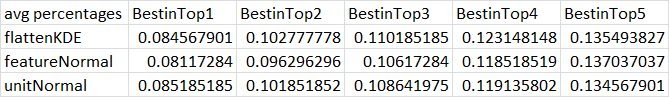

<!--
avg sums	BestinTop1	BestinTop2	BestinTop3	BestinTop4	BestinTop5
flattenKDE	27.4	33.3	35.7	39.9	43.9
featureNormal	26.3	31.2	34.4	38.4	44.4
unitNormal	27.6	33	35.2	38.6	43.6
-->
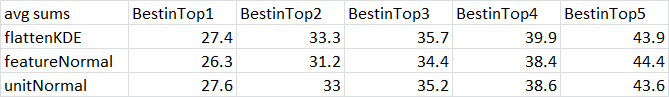

### Generating the random sample NullModel

In [ ]:
import matplotlib.pyplot as plt, seaborn as sns, numpy as np, scipy as sp, pandas as pd, statsmodels as sm
from scipy.spatial import distance as sp_distance
from scipy import stats as sp_stats
import os, sys, subprocess, itertools
import KDEpy as kdeOpt

#os.environ["MODIN_ENGINE"] = "ray"
#os.environ["MODIN_CPUS"] = "2"
#import modin.pandas as pd




def corrDist (compSig:np.ndarray, refArray:np.ndarray) -> np.ndarray:
    returnDists = [0]*refArray.shape[0]
    for i in range(refArray.shape[0]):
        x = refArray[i,:]
        returnDists[i] = sp_distance.correlation(compSig, x)
    return np.array(returnDists)


def pearsonr (compSig:np.ndarray, refArray:np.ndarray) -> np.ndarray:
    returnCorrs = [0]*refArray.shape[0]
    for i in range(refArray.shape[0]):
        x = refArray[i,:]
        returnCorrs[i] = sp_stats.pearsonr(x, compSig)[0]
    return np.array(returnCorrs)

def _pairwiseCorrProcess(exp_df,ref_df,reporting_df):
    '''function to take given experiment df and the reference DF to perform pairwise
    correlation simiarity and distance calculations for each row of the experiment df
    to each compound in the reference DF. A reporting df for the experiement is either
    created, if one is not passed, or appended with 3 columns:
    1) reference Compound identifiers
    2) corresponding Pearson similarity Correlations (as 10 digit floats)
    3) corresponding correlation distances (as 10 digit floats)
    Return to call the reporting DF.
    https://stackoverflow.com/a/54655688 source for solution
    NOTE: order of the features in each DF matter for the distance and similarity calcs
    '''

    from scipy.spatial import distance as sp_distance
    from scipy import stats as sp_stats

    def corrDist (compSig:np.ndarray, refArray:np.ndarray) -> np.ndarray:
        returnDists = [0]*refArray.shape[0]
        for i in range(refArray.shape[0]):
            x = refArray[i,:]
            returnDists[i] = sp_distance.correlation(compSig, x)
        return np.array(returnDists)

    def pearsonr (compSig:np.ndarray, refArray:np.ndarray) -> np.ndarray:
        returnCorrs = [0]*refArray.shape[0]
        for i in range(refArray.shape[0]):
            x = refArray[i,:]
            returnCorrs[i] = sp_stats.pearsonr(x, compSig)[0]
        return np.array(returnCorrs)
    if reporting_df is None:
        reporting_df = pd.DataFrame(columns=["TopSimilarRefComps","CorrespPearsonSim","CorrespCorrDistance"], index=exp_df.index)

    # one_to_one = list() # for sanity checks
    refcompounds = ["._.".join([str(y) for y in x]) for x in ref_df.index]
    # print(ref_df.to_numpy().shape)

    distance = exp_df.apply(lambda compSig: corrDist(compSig.fillna(0).to_numpy(),ref_df.to_numpy()),axis=1)
    similarity = exp_df.apply(lambda compSig: pearsonr(compSig.fillna(0).to_numpy(),ref_df.to_numpy()),axis=1)
    reporting_df['TopSimilarRefComps'] = ".__.".join(refcompounds)
    reporting_df['CorrespCorrDistance'] = \
            [".__.".join(["{:.10f}".format(d_1) for d_1 in d]) for d in distance]
    reporting_df['CorrespPearsonSim'] = \
            [".__.".join(["{:.10f}".format(s_1) for s_1 in s]) for s in similarity]

    return reporting_df

def drawfromfeatureKDE(featureData,numDraws,noiseModel='poisson',gridsize=1000,logTransform=False,col=None):
    x = np.asarray(featureData)
    if logTransform:
        x = np.log(x)
    try:
        kde_support, kde_pdf = kdeOpt.FFTKDE(bw='silverman',kernel='gaussian').fit(x).evaluate(gridsize)
    except ValueError:
        # print(data[col].describe())
        kde_support, kde_pdf = kdeOpt.FFTKDE(bw='silverman',kernel='gaussian').fit(np.nan_to_num(x)).evaluate(gridsize)
    # kde = sm.nonparametric.kde.KDEUnivariate(x)
    # kde.fit(gridsize=gridsize)
    if logTransform:
        kdeChoices = math.e**kde_support
    else:
        kdeChoices = kde_support
    #here the needs to be a support mutator in order to add uniform noise
    scaleWeight = np.var(x)# or scaleWeight = std(x)  ???
    noise = (1/gridsize)*scaleWeight
    if noiseModel == 'poisson':
        try:
            noise_addition = np.random.poisson(lam=scaleWeight**(1/gridsize),size=kdeChoices.shape)
        except ValueError:
            noise_addition = np.random.poisson(lam=15,size=kdeChoices.shape)
    elif noiseModel == 'normal':
        noise_addition = np.random.normal(np.mean(x),np.std(x),kdeChoices.shape)
    elif noiseModel == 'normal+':
        noise_addition = np.random.normal(np.mean(x),np.std(x),kdeChoices.shape) + ((1/gridsize)*scaleWeight)
    elif noiseModel == 'normal_scaledSigma':
        noise_addition = np.random.normal(np.mean(x),scaleWeight**(1/gridsize),kdeChoices.shape)
    elif noiseModel == 'scaled':
        noise_addition = np.random.normal(0,1,kdeChoices.shape)*noise
    elif noiseModel == 'unitNormal':
        noise_addition = np.random.normal(0,1,kdeChoices.shape)
    elif noiseModel == 'uniform':
        noise_addition = np.random.uniform(0,1/gridsize,kdeChoices.shape)*scaleWeight
    elif noiseModel == None:
        noise_addition = 0.5
    else:
        noise_addition = 0
    kde_pdf += noise_addition
    # return kdeChoices,kde_pdf
    randomDrawsFromKDE = np.empty(numDraws)
    for i in np.arange(0,numDraws):
        try:
            randomDrawsFromKDE[i] = np.random.choice(kdeChoices,p=kde_pdf/kde_pdf.sum())
        except ValueError:
            print(col,pd.Series(kde_pdf).describe()))
            return(np.zeros(numDraws)+noise_addition)
    return randomDrawsFromKDE

data = pd.read_csv('allCPexps.csv',index_col=[0,1,2,3])
print(data.shape,file=sys.stdout)
nullModelFingerprints = list()
for nullModel in ['unitNormal','normalOnFeatures','postFlatten']:
    featCols = data.columns
    newRandCPfingerprints = pd.DataFrame(index=pd.RangeIndex(15000), columns=featCols)
# now we do the nulmodel that is a 15K sample of the data, with replacement, and we can do it 3 times for kicks, and average or something...
    newRandCPfingerprints = data.sample(n=15000,replace=True)
# we already generated the fingerprints in a previous pass, so here we can just pull them from disk
    #newRandCPfingerprints = pd.read_csv(f'KDE{nullModel}_100k_fingerprints.csv',index_col=0).sample(frac=0.5,random_state=15)
    nullModelFingerprints.append(newRandCPfingerprints)


import time,sys
print(time.ctime(),file=sys.stdout)
refData = pd.read_csv('AllReferenceExp_20191018_commonFeaturesOrder.csv',index_col=[0,1,2,3])
refData_columns =refData.columns
#del refData

#newRandCPfingerprints = pd.read_csv('KDErandomFingerprints_100k_10Jun2020.csv',index_col=0)
print(f'reordering fingerprint file columns at {time.ctime()}',file=sys.stderr)
for i,nullModel in enumerate(nullModelFingerprints):
    nullModelFingerprints[i] = nullModel[[col for col in refData_columns]]

#compute the correlation distance matrix and Pearson Correlation matrix of the generated aritificial sigs for each of the nullModels, and save them to disk
#we will currenly only plot the distance matrix details, so only hold those in memory maybe..
nullCorDistMat = list()
nullCorSimMat = list()
for j,(nullModel,nullModelName) in enumerate(zip(nullModelFingerprints,['unitNormal','normalOnFeatures','postFlatten'])):
    rand_refDistances = refData.apply(lambda compSig: corrDist(compSig.fillna(0).to_numpy(),nullModel.fillna(0).to_numpy()),axis=1)
    rand_refPearsonCor = refData.apply(lambda compSig: pearsonr(compSig.fillna(0).to_numpy(),nullModel.fillna(0).to_numpy()),axis=1)
    rand_refDistances = pd.DataFrame({rand_refDistances.index[i]:d for i,d in enumerate(rand_refDistances)})
    rand_refPearsonCor = pd.DataFrame({rand_refPearsonCor.index[i]:s for i,s in enumerate(rand_refPearsonCor)})
    rand_refDistances.to_pickle(f'KDErandom15KSample_{j+1}_AllRefExp_20191018_commonFeatOrder_dist.pkl.gz')
    rand_refPearsonCor.to_pickle(f'KDErandom15KSample_{j+1}_AllRefExp_20191018_commonFeatOrder_PearCor.pkl.gz')
    nullCorDistMat.append(rand_refDistances)

del rand_refPearsonCor

print(time.ctime(),file=sys.stdout)

#plot the three nullmodel self v self corDistMat KDE for viewing.
for j,(nullModel,nullModelName) in enumerate(zip(nullModelFingerprints,['unitNormal','normalOnFeatures','postFlatten'])):
    print(f'Computing the distance matrix for {nullModelName} at {time.ctime()}',file=sys.stderr)
    # this doesn't need to be in squareform, so maybe we just leave in vector result
    try:
        nullCorDistMat = pd.Series(sp.spatial.distance.pdist(nullModel.to_numpy(),'correlation'))
        sns.distplot(nullCorDistMat,kde_kws={'kernel':'gau','bw':'silverman','gridsize':1000},
                  label=f'Random15KSample_{j+1}_nullmodel',kde=True,hist=False,rug=False)
    except MemoryError:
        print("numpy MemoryError",file=sys.stderr)
        nullCorDistMat = pd.Series(sp.spatial.distance.pdist(nullModel.sample(frac=0.1,random_state=15).to_numpy(),'correlation'))
    nullCorDistMat = pd.Series(nullCorDistMat)
    nullCorDistMat.to_pickle(f'random15KSample_{j+1}_nullModelDistMat.pkl.gz')
    sns.distplot(nullCorDistMat.sample(frac=0.1,random_state=15),kde_kws={'kernel':'gau','bw':'silverman','gridsize':1000},
                 label=f'{nullModelName}_nullmodel',kde=True,hist=False,rug=False)

# sns.distplot(unitNormal_nullModel_corDistMat.to_numpy().flatten(),kde_kws={'kernel':'gau','bw':'silverman','gridsize':1000},
#              color='blue',label='unitNormal_nullmodel',kde=True,hist=False,rug=False,ax=ax)
import glob
distMats = glob.glob('*_nullModelDistMat.pkl.gz')
distMats = distMats[1:4]+[distMats[0]]+distMats[-2:]
for j in distMats:
    nullCorDistMat = pd.read_pickle(j)
    sns.distplot(nullCorDistMat.sample(frac=0.1,random_state=15),kde_kws={'kernel':'gau','bw':'silverman','gridsize':1000},
                 label=f'{j.split("_")[0]}_nullmodel',kde=True,hist=False,rug=False)
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.tight_layout()
plt.savefig('KDE_thought_exp_NullModels_20210426.png')
plt.close()


now that we've generated the random sample null model (3 of them in fact) we should do the repeated 10% hold out on these as well, the code from above to do this is below again, and 'should' be exactly what is needed..

Something to note: this code block below, include a linspace stretch from 0 -> 2 which was an induced artifact to ensure that the p-value integration is non-zero, however, with the Random15K sample null model, the null actually reaches 0 on it's own, and as such it is less important for the linspace stretch, and actually might be harmful for generating nice very low E-Values..

will need to look at how the repeated hold 10 accuracy scores reflect this, and have a comparison to evaluate that..

In [1]:
#!/hb/home/alohith/.conda/envs/alohith-base/bin/python3.6

import subprocess,os,sys,pandas as pd,numpy as np,matplotlib.pyplot as plt,seaborn as sns,scipy as sp,shelve,pickle
import KDEpy as kdeOpt

# use sys.argv to get the artifical to hela reference distance matrix, which will be the first argument after program call
# we first used: 'KDErandomNoisedFinger_AllRefExp_20191018_commonFeatOrder_dist.csv'
noised_randomDF = pd.read_csv(sys.argv[1],index_col=0,header=[0,1,2],skiprows=lambda s: s in [3])

# we will need to differentiate the saveName stem for this specific distance matrix (if provided, which it should be)
# make things simple and use sys.argv[2] instead of digesting the provided distmat filename
if len(sys.argv) ==3:
    saveStem = sys.argv[2]+"hold10"
else:
    saveStem = ""+'hold10'                                                                                                                                                                                         
print(f'plots will be saved with "{saveStem}" as the saveStem',file=sys.stderr)                                                                                                                                    

#randomDF = pd.read_csv(KDErandomFinger_AllRefExp_20191018_commonFeatOrder_dist.csv', index_col=0, header=[0,1,2],skiprows=lambda s: s in [3])

key = pd.read_excel('../Mar2020_SChemInflam+NPFs_PRISMmod_annot.xlsx',sheet_name = -1)
#sheet_name = -1,index_col=[0,9,8] #['SWID','DoseConcentration(mM)','CSCPlateID']
labeledCompsPlates = [x for x in key.CSCPlateID.unique() if int(x[2:]) <1000 ]

#slice out only SChem from the key
SCHEM_key = key.loc[key.CSCPlateID.isin(labeledCompsPlates)]
# convert the DoseConcentration(mM) into a float value
SCHEM_key['DoseConcentration(mM)'] = SCHEM_key.loc[:,'DoseConcentration(mM)'].copy().astype(float).astype(str)

filterSCHEM_key = SCHEM_key[~(SCHEM_key['PRISMmod_Class'].isin(['POSctrl','NEGctrl','Others','none']))].copy()

AllScores_writer = pd.ExcelWriter(f'Densities2Classes/{saveStem}_All_HeLa-Schem_distScores.xlsx', engine='xlsxwriter')
inClass_writer = pd.ExcelWriter(f'Densities2Classes/{saveStem}_HeLa-Schem_distScores.xlsx', engine='xlsxwriter')

#get the compounds that will be a part of the 10% holdout, remove them from the key, but store them in final exel workbooks so we know what they are
filterSCHEM_key_holdout = [filterSCHEM_key.sample(frac=0.1,replace=False,axis='index') for i in range(10)] #remove random state!
filterSCHEM_key_holdout_comps = [filterSCHEM_key_holdout[i][['SWID','DoseConcentration(mM)','CSCPlateID']].copy() for i in range(10)]
[filterSCHEM_key_holdout_comps[i].to_excel(AllScores_writer,sheet_name=f"10%HoldoutComps_{i}") for i in range(10)]
[filterSCHEM_key_holdout_comps[i].to_excel(inClass_writer,sheet_name=f'10%HoldoutComps_{i}') for i in range(10)]

filterSCHEM_key = [filterSCHEM_key.drop(index=filterSCHEM_key_holdout[i].index) for i in range(10)]
# gather the list of these holdout compounds for later
for keySet in range(10):
    filterSCHEM_key_holdout_comps[keySet] = [tuple(filterSCHEM_key_holdout_comps[keySet].iloc[i].tolist()) for i
                                 in range(filterSCHEM_key_holdout_comps[keySet].shape[0])]

#make a list of all the MOA classes represented in the filteredKey
refClasses = list()
for i in range(10):
    refClasses.extend(filterSCHEM_key[i].PRISMmod_Class.unique().tolist())

refClasses = list(set(refClasses))


#collect a dict of refClasses to comps
refClass_to_comp = dict.fromkeys(refClasses)

for keySet in range(10):
    print(keySet)
    for c in refClass_to_comp.keys():
        if refClass_to_comp[c] is None:
            refClass_to_comp[c] = {f'distScores_{keySet}':None,'comps':list()}
        else:
            refClass_to_comp[c].update({f'distScores_{keySet}':None})
        if keySet ==0: #we only need to add all comps into the mapping once, not 10times
            comps = SCHEM_key.loc[SCHEM_key.PRISMmod_Class==c][['SWID','DoseConcentration(mM)','CSCPlateID']].copy()
            for i in range(comps.shape[0]):
                refClass_to_comp[c]['comps'].append(tuple(comps.iloc[i].tolist()))
        #we want the averages of the distances of each artificial comp to the members of this class (numClass x100K --> 100k)
        # make sure not to include the hold-out compounds when computing Null Model
        comps_noHoldOut = [x for x in refClass_to_comp[c]['comps'] if x not in filterSCHEM_key_holdout_comps[keySet]] 
        #refClass_to_comp[c]['distScores'] = noised_randomDF[refClass_to_comp[c]['comps']].mean(axis=1).copy()
        refClass_to_comp[c][f'distScores_{keySet}'] = noised_randomDF[comps_noHoldOut].mean(axis=1).copy()

# print(refClass_to_comp[c].keys())
# os.mkdir('Densities2Classes')

#for c in refClass_to_comp.keys():
#    # ax = plt.hist(refClass_to_comp[c]['distScores'].to_numpy(), density=1, histtype='stepfilled', label=c, fill=False,bins=50)
#    # sns.distplot(refClass_to_comp[c]['distScores'].to_numpy(),kde=False,kde_kws={'color':'red','bw':'silverman','gridsize':1000},bins=50, hist_kws={'histtype':'bar','alpha':0.5},norm_hist=True)
#    sns.kdeplot(refClass_to_comp[c]['distScores'].to_numpy().flatten(),kernel='gau',color='red',bw='silverman',gridsize=1000)
#    plt.ylabel('Probability Density')
#    plt.xlabel('Correlation Distances of Artificial Signatures to Reference')
#    plt.title(f'KDE of distances to class:\n{c}')
#    plt.legend(loc='best')
#    plt.tight_layout()
#    plt.savefig('Densities2Classes/{}_noisedrandom.png'.format(c.replace('/','_')))
#    plt.close()

if os.path.exists('AllReferenceExp_20191018_commonFeaturesOrder_corDistMat.pkl.gz'):
    refData_corDistMat = pd.read_pickle('AllReferenceExp_20191018_commonFeaturesOrder_corDistMat.pkl.gz')
else:
    #corrDistance = lambda col1,col2: sp.spatial.distance.correlation(col1,col2)
    refData = pd.read_csv('AllReferenceExp_20191018_commonFeaturesOrder.csv',index_col=[0,1,2])
    #compute the pairwise distance matrix of the ref compounds to themselves (in squareform)
    #refData_corDistMat = pd.DataFrame(np.triu(sp.spatial.distance.squareform(sp.spatial.distance.pdist(refData.drop(columns='WellID').to_numpy(),'correlation'))),index=refData.index,columns=refData.index)
    refData_corDistMat = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(refData.drop(columns='WellID').to_numpy(),'correlation')),index=refData.index,columns=refData.index)
    # apply(lambda col1: refData.drop(columns='WellID').apply(lambda col2: corrDistance(col1,col2)))
    #the concentration info on the compound indexing needs to be converted to strings in order to allow for slicing to occurcorrectly
    refData.index = refData.index.set_levels([refData.index.levels[0],refData.index.levels[1].astype(str), refData.index.levels[2]])
    refData_corDistMat.index = refData.index.set_levels([refData.index.levels[0],refData.index.levels[1].astype(str), refData.index.levels[2]])
    refData_corDistMat.columns = refData.index.set_levels([refData.index.levels[0],refData.index.levels[1].astype(str), refData.index.levels[2]])
    refData_corDistMat.to_pickle('AllReferenceExp_20191018_commonFeaturesOrder_corDistMat.pkl.gz')
    #we only care (maybe) about the upper triangular matrix of the pairwise distance matrix, but we want to keep the squareform
    #refData_corDistMat = refData_corDistMat.where(np.triu(np.ones(refData_corDistMat.shape)).astype(np.bool))
    
holdoutDistScores = dict().fromkeys(range(10))
for keySet in range(10):
    SchemDistScores = {'compound':list(),'class':list(),'average distScore':list(),'integral':list(),'E-value':list(),'integral_1':list(),'E-value_1':list()}
    for c in refClass_to_comp.keys():
        #hold-out compounds do not exist in any of these comparison, especially since they've been removed from the filtered key
        #so we should probably not bother saving these plots, as they'd just overwrite old ones depiciting similar situations..
        print(c)
        plt.figure(figsize=(12,8))
        #for each class slice the distMat (ref vs ref) to contain only the compounds that are members of the class
        refClass_to_comp[c]['refSelf2Self_distScores'] = refData_corDistMat.loc[refClass_to_comp[c]['comps'],refClass_to_comp[c]['comps']].copy()
        comp = refClass_to_comp[c]['comps'][0] #we are only going to plot the first member of this class
        num_comps = len(refClass_to_comp[c]['comps']) #details to include in the plot
        # print(comp,num_comps,refData_corDistMat[comp].values)
        #plot the null distribution of artificial signatures to this class
        # use np.linspace(0.09525,2,1000) for a kde ending very close to 0 distance.
        print("\n\nNumber of NaNs among mean artificial distscores to class:",refClass_to_comp[c][f'distScores_{keySet}'].isna().sum().sum(),end="\n\n\n",file=sys.stderr)
        kde_support, kde_pdf = kdeOpt.FFTKDE(bw='silverman',kernel='gaussian').fit(np.append(np.nan_to_num(refClass_to_comp[c][f'distScores_{keySet}'].to_numpy().flatten()),np.linspace(0,2,1000))).evaluate(1000)
        refClass_to_comp[c][f'{saveStem} Null Dist_{keySet}'] = (kde_support,kde_pdf)
        #print(c,kde_support[0],file=sys.stderr)
        plt.plot(kde_support,kde_pdf,color='red',label='KDE of nullModel to class')
        ax = sns.kdeplot(refClass_to_comp[c][f'distScores_{keySet}'].to_numpy().flatten(),
                         kernel='gau',color='red',bw='silverman',gridsize=1000)
        #we need the kde details in order to compute an integral
        kde_x,kde_y = ax.get_lines()[1].get_data()
        # in order to integrate we need the compound's average distance to members of the current class
        # in this toy example, the average distance can be obtained from the class's refSelf2Self distMat(?)
        #refClass_to_comp[c]['refSelf2Self_distScores'][comp].values
        comp_mean2class = np.nanmean(refData_corDistMat.loc[comp,refClass_to_comp[c]['comps']].values)
        integral = np.trapz(y=kde_y[np.where(kde_x<comp_mean2class)], x=kde_x[np.where(kde_x<comp_mean2class)])
        integral_1 = np.trapz(y=kde_pdf[np.where(kde_support<comp_mean2class)], x=kde_support[np.where(kde_support<comp_mean2class)])
        print(f"the pvalue with non-stretched kde is {integral}. The pvalue from kde that includes a linspace from ~0->2 is {integral_1}. These integrals are the same: {integral==integral_1}")
        #plt.fill_between(kde_support,0,kde_pdf, where=(kde_support<comp_mean2class),alpha=0.3,color='r')
        # as a demonstration, add ticks for each of pairwise distances of the class members to the query compound, this is the same as row-slice from the original distMat, with class associated columns
        #sns.rugplot(refClass_to_comp[c]['refSelf2Self_distScores'][comp].values,ax=ax,height=0.025,label=f'PairwiseDist of {comp[0]}_{comp[1]} to class')
        print(f'Number of comps in class {num_comps}, number of pairwise distances used to calc the mean: {len(refData_corDistMat.loc[comp,refClass_to_comp[c]["comps"]].values)}.',
            ' these should be equal, and the equality is: {}'.format(len(refData_corDistMat.loc[comp,refClass_to_comp[c]["comps"]].values)==num_comps))
        #print('comparison of the average distance.\nUsing the Self2Self distmat slice: ',np.nanmean(refClass_to_comp[c]['refSelf2Self_distScores'][comp].values),
        #    'Using the refData_distanceMatrix which would represent a single query against all members in a class(?): ',comp_mean2class)
        #lets place a marker of the average distance used to compute the probablity/integral and evalue
#         plt.scatter(comp_mean2class,2,marker="x",label='average distance to class members')
        #plot formatting
#         plt.ylabel('Probability Density')
#         plt.xticks(np.arange(0,22,2)/10.0)
#         plt.xlabel('Average Correlation Distances to Reference')
#         plt.title(f'KDE of distances to class:\n{c}\n {num_comps} Reference Compounds\nLikelihood Member by Chance:{integral_1:0.3e}')
#         plt.legend(loc='upper left')
        plt.tight_layout()
    #     plt.savefig('Densities2Classes/{}_{}_noisedrandom+rug.png'.format(saveStem,c.replace(' ','_').replace('/','_')))
        plt.close()
        #while we are here lets get the details on all the members of the class, and save them as records to add to a table, this step maybe can be extended to query every compound's ability to be placed in each of the 340+ MOA classes.
        for c_comp in refClass_to_comp[c]['comps']:
            SchemDistScores['compound'].append(c_comp) #the compound we are processing
            SchemDistScores['class'].append(c) #the current class we are processing, should be the one that this compound is assigned to in the first place according to the master key
            #its easier to compute the mean distance to the members of the class for subsequent steps. do this similarly to the first compound graphic with row-slicing etc.
            c_comp_mean2Class = np.nanmean(refData_corDistMat.loc[c_comp,refClass_to_comp[c]['comps']].values)
            SchemDistScores['average distScore'].append(c_comp_mean2Class)
            c_comp_integral = np.trapz(y=kde_y[np.where(kde_x<c_comp_mean2Class)],x=kde_x[np.where(kde_x<c_comp_mean2Class)])
            c_comp_integral_1 = np.trapz(y=kde_pdf[np.where(kde_support<c_comp_mean2Class)], x=kde_support[np.where(kde_support<c_comp_mean2Class)])
            SchemDistScores['integral'].append(c_comp_integral)
            SchemDistScores['integral_1'].append(c_comp_integral_1)
            SchemDistScores['E-value'].append(c_comp_integral*len(refClass_to_comp.keys())) #multiple experiement correction(?)
            SchemDistScores['E-value_1'].append(c_comp_integral_1*len(refClass_to_comp.keys()))
    pd.DataFrame(SchemDistScores).to_excel(inClass_writer,sheet_name=f'Sheet1_{keySet}')
    holdoutDistScores[keySet] = SchemDistScores


def workspaceShelveSave(shelveFile,read=False,writeMode='n'):
    import shelve
    # 'kde_distScoreClassification.shelve'
    if not read:
        with shelve.open(shelveFile,writeMode) as my_shelf:
            for key in dir():
                if key not in ['my_shelf','read','shelveFile','writeMode']:
                    try:
                        my_shelf[key] = globals()[key]
                    except TypeError or KeyError:
                        #
                        # __builtins__, my_shelf, and imported modules can not be shelved.
                        #
                        print('ERROR shelving: {0}'.format(key),file=sys.stderr)
    else:
        with shelve.open(shelveFile,'r') as my_shelf:
            for key in my_shelf:
                if key not in ['my_shelf','read','shelveFile','writeMode']:
                    try:
                        globals()[key]=my_shelf[key]
                    except TypeError or KeyError:
                        print("ERROR loading: {0}".format(key),file=sys.stderr)



#workspaceShelveSave(f'Densities2Classes/{saveStem}_distScores.shelve',writeMode='n')

# #perform classification on all compounds to all classes
# # here we use the corDistMat to give us compounds to classify, so this should include the hold-outs, but we should probably do this loop/etc and output to specific sheet in th workbook, just in case
# all2all_DistScoring = dict().fromkeys(refData_corDistMat.index.to_list())
# for comp in all2all_DistScoring.keys():
#     #for each comp, we need a score to each possible class, which is linked to the filterSCHEMKey class names (AFTER REMOVING THE HOLDOUT COMPS)
#     all2all_DistScoring[comp] = dict().fromkeys(refClass_to_comp.keys())
#     #loop over every class represented, and compute the avg distance for the compound to that class, the integral on the null model, and the eValue Score
#     for c in refClass_to_comp.keys():
#         comp_dist_mean2Class = np.nanmean(refData_corDistMat.loc[comp,refClass_to_comp[c]['comps']].values)
#         null_support,null_pdf = refClass_to_comp[c][f'{saveStem} Null Dist']
#         comp_dist_integral = np.trapz(y=null_pdf[np.where(null_support<comp_dist_mean2Class)],x=null_support[np.where(null_support<comp_dist_mean2Class)])
#         all2all_DistScoring[comp][c] = comp_dist_integral * len(refClass_to_comp.keys())

# all2all_DistScoring = pd.DataFrame().from_records(all2all_DistScoring)
# # here we should do a arg min evaluation to 'pick' the best scoring class according to this method.
# all2all_DistScoring.to_excel(AllScores_writer,sheet_name='Sheet1')

#lets do the classification on specifically the holdout compounds
for keySet in range(10):
    holdOut2all_DistScoring = dict().fromkeys(filterSCHEM_key_holdout_comps[keySet])
    for held_comp in holdOut2all_DistScoring.keys():
        holdOut2all_DistScoring[held_comp] = dict().fromkeys(refClass_to_comp.keys())
        holdOut2all_DistScoring[held_comp]['Key_annot'] = filterSCHEM_key_holdout[keySet].loc[
            ((filterSCHEM_key_holdout[keySet].filter(items=['SWID','DoseConcentration(mM)','CSCPlateID']) == held_comp).
             sum(axis=1)==3)]['PRISMmod_Class'].values
        for c in refClass_to_comp.keys():
            held_comp_mean2Class = np.nanmean(refData_corDistMat.loc[held_comp,refClass_to_comp[c]['comps']].values)
            null_support,null_pdf = refClass_to_comp[c][f'{saveStem} Null Dist_{keySet}']
            held_comp_dist_integral = np.trapz(y=null_pdf[np.where(null_support<held_comp_mean2Class)],x=null_support[np.where(null_support<held_comp_mean2Class)])
            holdOut2all_DistScoring[held_comp][c] = held_comp_dist_integral * len(refClass_to_comp.keys())

    holdOut2all_DF = pd.DataFrame().from_records(holdOut2all_DistScoring)
    holdOut2all_DF.to_excel(AllScores_writer,sheet_name =f'10%hold_compScores_{keySet}')

AllScores_writer.save()
inClass_writer.save()

with open(f'{saveStem}_refClass_to_compDict.pkl','wb') as pickleFile:
    try:
        pickle.dump(refClass_to_comp,pickleFile)
    except PicklingError:
        print(f'failed attempt to pickle {saveStem} refClass_to_comp Dictionary',file=sys.stderr)

FileNotFoundError: [Errno 2] File -f does not exist: '-f'

again using previous code, this time interactive, here's how we will compile the random15K sample Null model results. Slight modifications required, since, we can take the average across each fold, and have a result for the singular random sample model (eventually) for now just leave them as 3 separate instances.

In [1]:
import subprocess,os,sys,pandas as pd,numpy as np,matplotlib.pyplot as plt,seaborn as sns,scipy as sp,shelve,pickle,glob
compDictPickleFiles = glob.glob('random15KSample*repeatedhold10*compDict.pkl')
compDictPickleFiles.sort()
# ['featureNormalNull_repeatedhold10_refClass_to_compDict.pkl', 'flattenKDENull_repeatedhold10_refClass_to_compDict.pkl', 'unitNormalNull_repeatedhold10_refClass_to_compDict.pkl']

# actually only need 1 of these since only need the class to compound mappings, and that is shared between all of these.
# ['unitNormalNull_refClass_to_compDict.pkl', 'featureNormalNull_refClass_to_compDict.pkl', 'flattenKDENull_refClass_to_compDict.pkl']
eValueMatNames = [f'random15KSample_{x+1}Null_repeatedhold10_All_HeLa-Schem_distScores.xlsx' for x in range(3)]


refClass_to_compDict = pickle.load(open(compDictPickles[0],'rb'))
nullModelType = {x:dict() for x in dict().fromkeys([f'random15KSample_{x+1}Null' for x in range(3)])}

for nullModel, refClass_compDict in zip([f'random15KSample_{x+1}Null' for x in range(3)],compDictPickleFiles):
    print(nullModel, refClass_compDict)
    refClass_compDict = pickle.load(open(refClass_compDict,'rb'))
    eValueMats = pd.read_excel(f"Densities2Classes/{nullModel}_repeatedhold10_All_HeLa-Schem_distScores.xlsx",\
                               sheet_name=None,index_col=0)
    saveFile = pd.ExcelWriter(f"Densities2Classes/{nullModel}_repeatedhold10_All_HeLa-Schem_distScores_New.xlsx",mode='w')
    bestFoldSums = {x:dict() for x in dict().fromkeys([f'fold_{y}' for y in range(10)])}
    bestFoldPercentages = {x:dict() for x in dict().fromkeys([f'fold_{y}' for y in range(10)])}
    for fold in range(10):
        saveSheetName = f"10%hold_compScores_{fold}"
        eValueMat = eValueMats[saveSheetName].T #(compounds are on the row, classes in the columns)
        #clean up the key_annot column (listed annotation in current annotation file)
        key_annot = eValueMat['Key_annot'].apply(lambda s: s.replace("'",'').replace(']','').replace("[",''))
        eValueMat.drop(columns='Key_annot',inplace=True) #drop it cause we np.array rn, but we'll put it back with a new name soon
        eValueMat_0 = eValueMat.copy() #take a copy to work on without the annotations
        eValueMat["Key_annot"]=key_annot
        for i in range(5):
            #Axis along which the function is applied:
            #0 or ‘index’: apply function to each column.
            #1 or ‘columns’: apply function to each row. (compounds are on the row, classes in the columns)
            newcolname = f'TopClass{i+1}'
            #argsort to get the class names that are the top N best scoring
            eValueMat[newcolname] = eValueMat_0.columns[eValueMat_0.apply(np.argsort,axis=1)][:,i]
    #         eValueMat['BestClass'] = eValueMat_0.columns[eValueMat_0.apply(np.argmin,axis=1)]
        for c in refClass_compDict.keys(): #reconstruct the listed annotation column (sanity check with Key_annot column)
    #             print(c)
            try:
                eValueMat.loc[[str(x) for x in refClass_compDict[c]['comps'] if str(x) in eValueMat.index],'PRISMmod_Class'] = c
            except KeyError:
                print("KeyError when pulling back the Key_annot")
        print((eValueMat['PRISMmod_Class'] == key_annot).sum(),len(key_annot),len(eValueMat['PRISMmod_Class']))
        for x in eValueMat.index:
            for z in range(5):
    #             print(f"BestInTop{z+1}\n",eValueMat.loc[x,[f'TopClass{i+1}' for i in range(z+1)]].str.\
    #                 contains(eValueMat.loc[x,'PRISMmod_Class']),"\n\n",eValueMat.loc[x,[f'TopClass{i+1}' for i in range(z+1)]].str.\
    #                 contains(eValueMat.loc[x,'PRISMmod_Class']).sum())
                eValueMat.loc[x,f"BestInTop{z+1}"] = (eValueMat.loc[x,[f'TopClass{i+1}' for i in range(z+1)]].str.\
                    contains(eValueMat.loc[x,'PRISMmod_Class']).sum() >0)
        for i in range(5):
            #collect the bestintop counts and percentages for each fold to store in a master summary table sheet
            bestFoldSums[f'fold_{fold}'][f'BestinTop{i+1}'] = (eValueMat[f'BestInTop{i+1}']== True).sum()
            bestFoldPercentages[f'fold_{fold}'][f'BestinTop{i+1}'] = (eValueMat[f'BestInTop{i+1}']== True).sum()/len(eValueMat[f'BestInTop{i+1}']== True)
        eValueMat.to_excel(saveFile,sheet_name=saveSheetName,engine='xlsxwriter')
    bestSumScores = pd.DataFrame().from_records(bestFoldSums)
    bestSumScores['average'] = bestSumScores.mean(axis=1)
    bestPercentageScores = pd.DataFrame().from_records(bestFoldPercentages)
    bestPercentageScores['average'] = bestPercentageScores.mean(axis=1)
    bestSumScores.to_excel(saveFile,sheet_name='BestInSummarySums',engine='xlsxwriter')
    bestPercentageScores.to_excel(saveFile,sheet_name='BestInSummaryPcts',engine='xlsxwriter')
    nullModelType[nullModel]['Percentages'] = bestPercentageScores
    nullModelType[nullModel]['Sums'] = bestSumScores
    saveFile.save()
    #     rowRange = eValueMat.shape[0]
    #     eValueMat['Best1'] = [(x in eValueMat.iloc[i]['BestClass1']) for x,i in zip(eValueMat['PRISMmod_Class'].fillna(0),range(rowRange)) if x !=0]
    #     eValueMat['Best2'] = [(x in eValueMat.iloc[i][['BestClass1','BestClass2']]) for x,i in zip(eValueMat['PRISMmod_Class'].fillna(0),range(rowRange)) if x !=0]
    #     eValueMat['Best3'] = [(x in eValueMat.iloc[i][['BestClass1','BestClass2','BestClass3']]) for x,i in zip(eValueMat['PRISMmod_Class'].fillna(0),range(rowRange)) if x !=0]
    #     eValueMat['Best4'] = [(x in eValueMat.iloc[i][['BestClass1','BestClass2','BestClass3',"BestClass4"]]) for x,i in zip(eValueMat['PRISMmod_Class'].fillna(0),range(rowRange)) if x !=0]
    #     eValueMat['Best5'] = [(x in eValueMat.iloc[i][['BestClass1','BestClass2','BestClass3',"BestClass4",'BestClass5']]) for x,i in zip(eValueMat['PRISMmod_Class'].fillna(0),range(rowRange)) if x !=0]

with open('random15KSample_repeatedhold10_scores.pkl','wb') as pickleFile:
    try:
        pickle.dump(nullModelType,pickleFile)
    except PicklingError:
        print(f'failed attempt to pickle Dictionary',file=sys.stderr)


IndentationError: unexpected indent (<ipython-input-1-979e50a159e8>, line 50)

This run of the distClassification repeated 10% hold-out was performed 3 times, so essentially 15 time. the average percent matching for top1,2,3,4,5 is as follows

<!--
Random15KSample with Linear Stretch	BestinTop1	BestinTop2	BestinTop3	BestinTop4	BestinTop5
RandomSample_1	0.111111111	0.154012346	0.194135802	0.227160494	0.25462963
RandomSample_2	0.109876543	0.156790123	0.188580247	0.216975309	0.239814815
RandomSample_3	0.117283951	0.161728395	0.198765432	0.224691358	0.249074074
average of averages	0.112757202	0.157510288	0.19382716	0.222942387	0.247839506
-->
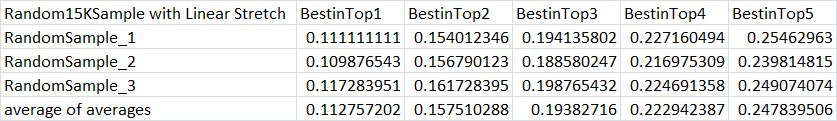

## Repeat repeated 10% holdout analysis with KS-sig classes (p<0.01)

collect from KS test, the list of classes that are marked as significant, and their associated compounds, and limit the reference/testing set number of classes to just those classes (aka shrink SCHEM to be only these compounds). sample 10% holdout compounds from this limited library, and compute eValue Stats. how does it perform for each of the null models?

In [56]:
sigClasses = pd.read_table(".KS_HeLa_Log10-Pearson_pValues.txt",index_col=0)
sigClasses = sigClasses.loc[sigClasses['CommonFeats']>2]
# with open('PRISMmod_PearsonSigClasses_CommonFeatOrder.lst','w') as sigClassList:
#     [print(x,file=sigClassList) for x in sigClasses.index.to_list()]

sigClasses

CommonFeats  groups
Classes                                           
COX                              25.025479      98
Histamine.Receptor               32.977016      94
PI3K                              6.456957      84
DNA.RNA.Synthesis                 7.224231      72
HDAC                            171.710206      64
...                                    ...     ...
ATP.channel.blocker               2.003894       4
CaSR                              2.370085       4
DNA Methyltransferase             2.858304       4
Estrogen.progestogen.Receptor     2.394779       4
LPA.Receptor                      2.230055       4

[86 rows x 2 columns]

In [57]:
sigClasses.loc[sigClasses['groups']>4]

CommonFeats  groups
Classes                                   
COX                      25.025479      98
Histamine.Receptor       32.977016      94
PI3K                      6.456957      84
DNA.RNA.Synthesis         7.224231      72
HDAC                    171.710206      64
...                            ...     ...
CRM1                     10.818105       6
DHFR                      5.117010       6
glucosidase inhibitor     2.491987       6
mucolytic agent           4.480301       6
p97                       3.717955       6

[81 rows x 2 columns]

So we've run the KS test on the frozenFeature list and gathered a list of classes that are marked significant with a pValue<0.01 (or -log10(pValue)>2), now we need to do the repeated 10% holdout that we did prior. Since we have 4 different nulls we can test at once, let's just do it all in one go, but also we should re-enable some of the in-process plotting, since it might be helpful to look at.

# MAIN Core Block

In [ ]:
#!/hb/home/alohith/.conda/envs/alohith-base/bin/python3.6

import subprocess,os,sys,pandas as pd,numpy as np,matplotlib.pyplot as plt,seaborn as sns,scipy as sp,shelve,pickle
import KDEpy as kdeOpt

# use sys.argv to get the artifical to hela reference distance matrix, which will be the first argument after program call
# we first used: 'KDErandomNoisedFinger_AllRefExp_20191018_commonFeatOrder_dist.csv'
noised_randomDF = pd.read_csv(sys.argv[1],index_col=0,header=[0,1,2],skiprows=lambda s: s in [3])

# we will need to differentiate the saveName stem for this specific distance matrix (if provided, which it should be)
# make things simple and use sys.argv[2] instead of digesting the provided distmat filename
if len(sys.argv) ==3:
    saveStem = sys.argv[2]+"hold10"
else:
    saveStem = ""+'hold10'                                                                                                                                                                                         
print(f'plots will be saved with "{saveStem}" as the saveStem',file=sys.stderr)                                                                                                                                    

#randomDF = pd.read_csv(KDErandomFinger_AllRefExp_20191018_commonFeatOrder_dist.csv', index_col=0, header=[0,1,2],skiprows=lambda s: s in [3])

key = pd.read_excel('../Mar2020_SChemInflam+NPFs_PRISMmod_annot.xlsx',sheet_name = -1)
#sheet_name = -1,index_col=[0,9,8] #['SWID','DoseConcentration(mM)','CSCPlateID']
labeledCompsPlates = [x for x in key.CSCPlateID.unique() if int(x[2:]) <1000 ]

#slice out only SChem from the key
SCHEM_key = key.loc[key.CSCPlateID.isin(labeledCompsPlates)]
# convert the DoseConcentration(mM) into a float value
SCHEM_key['DoseConcentration(mM)'] = SCHEM_key.loc[:,'DoseConcentration(mM)'].copy().astype(float).astype(str)

filterSCHEM_key = SCHEM_key[~(SCHEM_key['PRISMmod_Class'].isin(['POSctrl','NEGctrl','Others','none']))].copy()

#read in the signicant classes list and drop those that are not in this list.
sigClasses = open('PRISMmod_PearsonSigClasses_CommonFeatOrder.lst','r').read().split('\n')
filterSCHEM_key = filterSCHEM_key[(filterSCHEM_key['PRISMmod_Class'].isin(sigClasses))].copy()

print(filterSCHEM_key['PRISMmod_Class'].value_counts(),\
      len(filterSCHEM_key['PRISMmod_Class'].value_counts().index),file=sys.stderr)
#####

AllScores_writer = pd.ExcelWriter(f'Densities2Classes_sigClass/{saveStem}_All_HeLa-Schem_distScores.xlsx', engine='xlsxwriter')
AllScores_writer_noStretch = pd.ExcelWriter(f'Densities2Classes_sigClass/{saveStem}_All_HeLa-Schem_noStretch_distScores.xlsx', engine='xlsxwriter')
inClass_writer = pd.ExcelWriter(f'Densities2Classes_sigClass/{saveStem}_HeLa-Schem_distScores.xlsx', engine='xlsxwriter')

#get the compounds that will be a part of the 10% holdout, remove them from the key, but store them in final exel workbooks so we know what they are
filterSCHEM_key_holdout = [filterSCHEM_key.sample(frac=0.1,replace=False,axis='index') for i in range(10)] #remove random state!
filterSCHEM_key_holdout_comps = [filterSCHEM_key_holdout[i][['SWID','DoseConcentration(mM)','CSCPlateID']].copy() for i in range(10)]
[filterSCHEM_key_holdout_comps[i].to_excel(AllScores_writer,sheet_name=f"10%HoldoutComps_{i}") for i in range(10)]
[filterSCHEM_key_holdout_comps[i].to_excel(inClass_writer,sheet_name=f'10%HoldoutComps_{i}') for i in range(10)]

filterSCHEM_key = [filterSCHEM_key.drop(index=filterSCHEM_key_holdout[i].index) for i in range(10)]
# gather the list of these holdout compounds for later
for keySet in range(10):
    filterSCHEM_key_holdout_comps[keySet] = [tuple(filterSCHEM_key_holdout_comps[keySet].iloc[i].tolist()) for i
                                 in range(filterSCHEM_key_holdout_comps[keySet].shape[0])]

#make a list of all the MOA classes represented in the filteredKey
refClasses = list()
for i in range(10):
    refClasses.extend(filterSCHEM_key[i].PRISMmod_Class.unique().tolist())

refClasses = list(set(refClasses))


#collect a dict of refClasses to comps
refClass_to_comp = dict.fromkeys(refClasses)

for keySet in range(10):
    print(keySet)
    for c in refClass_to_comp.keys():
        if refClass_to_comp[c] is None:
            refClass_to_comp[c] = {f'distScores_{keySet}':None,'comps':list()}
        else:
            refClass_to_comp[c].update({f'distScores_{keySet}':None})
        if keySet ==0: #we only need to add all comps into the mapping once, not 10times
            comps = SCHEM_key.loc[SCHEM_key.PRISMmod_Class==c][['SWID','DoseConcentration(mM)','CSCPlateID']].copy()
            for i in range(comps.shape[0]):
                refClass_to_comp[c]['comps'].append(tuple(comps.iloc[i].tolist()))
        #we want the averages of the distances of each artificial comp to the members of this class (numClass x100K --> 100k)
        # make sure not to include the hold-out compounds when computing Null Model
        comps_noHoldOut = [x for x in refClass_to_comp[c]['comps'] if x not in filterSCHEM_key_holdout_comps[keySet]] 
        #refClass_to_comp[c]['distScores'] = noised_randomDF[refClass_to_comp[c]['comps']].mean(axis=1).copy()
        refClass_to_comp[c][f'distScores_{keySet}'] = noised_randomDF[comps_noHoldOut].mean(axis=1).copy()

# print(refClass_to_comp[c].keys())
# os.mkdir('Densities2Classes_sigClass')

for c in refClass_to_comp.keys():
    for keySet in range(10):
    # ax = plt.hist(refClass_to_comp[c]['distScores'].to_numpy(), density=1, histtype='stepfilled', label=c, fill=False,bins=50)
    # sns.distplot(refClass_to_comp[c]['distScores'].to_numpy(),kde=False,kde_kws={'color':'red','bw':'silverman','gridsize':1000},bins=50, hist_kws={'histtype':'bar','alpha':0.5},norm_hist=True)
        sns.kdeplot(refClass_to_comp[c][f'distScores_{keySet}'].to_numpy().flatten(),kernel='gau',color='red',alpha=0.3,bw='silverman',gridsize=1000)
    plt.ylabel('Probability Density')
    plt.xlabel(f'Correlation Distances of NullModel {saveStem} Signatures to Reference')
    plt.title(f'KDE of distances to class:\n{c}')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('Densities2Classes_sigClass/{}_{}_classPerspective.png'.format(c.replace('/','_'),saveStem))
    plt.close()

if os.path.exists('AllReferenceExp_20191018_commonFeaturesOrder_corDistMat.pkl.gz'):
    refData_corDistMat = pd.read_pickle('AllReferenceExp_20191018_commonFeaturesOrder_corDistMat.pkl.gz')
else:
    #corrDistance = lambda col1,col2: sp.spatial.distance.correlation(col1,col2)
    refData = pd.read_csv('AllReferenceExp_20191018_commonFeaturesOrder.csv',index_col=[0,1,2])
    #compute the pairwise distance matrix of the ref compounds to themselves (in squareform)
    #refData_corDistMat = pd.DataFrame(np.triu(sp.spatial.distance.squareform(sp.spatial.distance.pdist(refData.drop(columns='WellID').to_numpy(),'correlation'))),index=refData.index,columns=refData.index)
    refData_corDistMat = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(refData.drop(columns='WellID').to_numpy(),'correlation')),index=refData.index,columns=refData.index)
    # apply(lambda col1: refData.drop(columns='WellID').apply(lambda col2: corrDistance(col1,col2)))
    #the concentration info on the compound indexing needs to be converted to strings in order to allow for slicing to occurcorrectly
    refData.index = refData.index.set_levels([refData.index.levels[0],refData.index.levels[1].astype(str), refData.index.levels[2]])
    refData_corDistMat.index = refData.index.set_levels([refData.index.levels[0],refData.index.levels[1].astype(str), refData.index.levels[2]])
    refData_corDistMat.columns = refData.index.set_levels([refData.index.levels[0],refData.index.levels[1].astype(str), refData.index.levels[2]])
    refData_corDistMat.to_pickle('AllReferenceExp_20191018_commonFeaturesOrder_corDistMat.pkl.gz')
    #we only care (maybe) about the upper triangular matrix of the pairwise distance matrix, but we want to keep the squareform
    #refData_corDistMat = refData_corDistMat.where(np.triu(np.ones(refData_corDistMat.shape)).astype(np.bool))

########################################## MAIN ##########################################

holdoutDistScores = dict().fromkeys(range(10))
for keySet in range(10):
    SchemDistScores = {'compound':list(),'class':list(),'average distScore':list(),'integral':list(),'E-value':list(),'integral_1':list(),'E-value_1':list()}
    for c in refClass_to_comp.keys(): ########################################## MAIN (process) ##########################################
        #hold-out compounds do not exist in any of these comparison, especially since they've been removed from the filtered key
        #so we should probably not bother saving these plots, as they'd just overwrite old ones depiciting similar situations..
        print(c)
        plt.figure(figsize=(12,8))
        #for each class slice the distMat (ref vs ref) to contain only the compounds that are members of the class
        refClass_to_comp[c]['refSelf2Self_distScores'] = refData_corDistMat.loc[refClass_to_comp[c]['comps'],refClass_to_comp[c]['comps']].copy()
        comp = refClass_to_comp[c]['comps'][0] #we are only going to plot the first member of this class
        num_comps = len(refClass_to_comp[c]['comps']) #details to include in the plot
        # print(comp,num_comps,refData_corDistMat[comp].values)
        #plot the null distribution of artificial signatures to this class
        # use np.linspace(0.09525,2,1000) for a kde ending very close to 0 distance.
        
        ########################################## MAIN (NULL MODEL) TODO: drawfromfeatureKDE() ##########################################
        print("\n\nNumber of NaNs among mean artificial distscores to class:",refClass_to_comp[c][f'distScores_{keySet}'].isna().sum().sum(),end="\n\n\n",file=sys.stderr)
        kde_support, kde_pdf = kdeOpt.FFTKDE(bw='silverman',kernel='gaussian').fit(np.append(np.nan_to_num(refClass_to_comp[c][f'distScores_{keySet}'].to_numpy().flatten()),np.linspace(0,2,1000))).evaluate(1000)
        refClass_to_comp[c][f'{saveStem} Null Dist_{keySet}'] = (kde_support,kde_pdf)
        #print(c,kde_support[0],file=sys.stderr)
        plt.plot(kde_support,kde_pdf,color='red',alpha=.3,label='KDE of nullModel to class')
        ax = sns.kdeplot(refClass_to_comp[c][f'distScores_{keySet}'].to_numpy().flatten(),
                         kernel='gau',color='orange',alpha=.3,bw='silverman',gridsize=1000)
        #we need the kde details in order to compute an integral
        kde_x,kde_y = ax.get_lines()[1].get_data()
        refClass_to_comp[c][f'{saveStem} noStretch Null Dist_{keySet}'] = (kde_x,kde_y)
        
        ##########################################  ##########################################
        
        # in order to integrate we need the compound's average distance to members of the current class
        # in this toy example, the average distance can be obtained from the class's refSelf2Self distMat(?)
        #refClass_to_comp[c]['refSelf2Self_distScores'][comp].values
        
        ########################################## MAIN (Integral step) ##########################################
        comp_mean2class = np.nanmean(refData_corDistMat.loc[comp,refClass_to_comp[c]['comps']].values)
        integral = np.trapz(y=kde_y[np.where(kde_x<comp_mean2class)], x=kde_x[np.where(kde_x<comp_mean2class)]) 
        integral_1 = np.trapz(y=kde_pdf[np.where(kde_support<comp_mean2class)], x=kde_support[np.where(kde_support<comp_mean2class)])
        print(f"the pvalue with non-stretched kde is {integral}. The pvalue from kde that includes a linspace from ~0->2 is {integral_1}. These integrals are the same: {integral==integral_1}")
        
        ##########################################  ##########################################
        
        #plt.fill_between(kde_support,0,kde_pdf, where=(kde_support<comp_mean2class),alpha=0.3,color='r')
        # as a demonstration, add ticks for each of pairwise distances of the class members to the query compound, this is the same as row-slice from the original distMat, with class associated columns
        #sns.rugplot(refClass_to_comp[c]['refSelf2Self_distScores'][comp].values,ax=ax,height=0.025,label=f'PairwiseDist of {comp[0]}_{comp[1]} to class')
        print(f'Number of comps in class {num_comps}, number of pairwise distances used to calc the mean: {len(refData_corDistMat.loc[comp,refClass_to_comp[c]["comps"]].values)}.',
            ' these should be equal, and the equality is: {}'.format(len(refData_corDistMat.loc[comp,refClass_to_comp[c]["comps"]].values)==num_comps))
        #print('comparison of the average distance.\nUsing the Self2Self distmat slice: ',np.nanmean(refClass_to_comp[c]['refSelf2Self_distScores'][comp].values),
        #    'Using the refData_distanceMatrix which would represent a single query against all members in a class(?): ',comp_mean2class)
        #lets place a marker of the average distance used to compute the probablity/integral and evalue
        plt.scatter(comp_mean2class,2,marker="x",label='average distance to class members')
        #plot formatting
        plt.ylabel('Probability Density')
        plt.xticks(np.arange(0,22,2)/10.0)
        plt.xlabel('Average Correlation Distances to Reference')
        plt.title(f'KDE of distances to class:\n{c}\n {num_comps} Reference Compounds\nLikelihood Member by Chance:{integral_1:0.3e} or {integral:0.3e}')
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.savefig('Densities2Classes_sigClass/{}_{}_{}_firstComp.png'.format(keySet, saveStem,c.replace(' ','_').replace('/','_')))
        plt.close()
        #while we are here lets get the details on all the members of the class, and save them as records to add to a table, this step maybe can be extended to query every compound's ability to be placed in each of the 340+ MOA classes.
        for c_comp in refClass_to_comp[c]['comps']:
            SchemDistScores['compound'].append(c_comp) #the compound we are processing
            SchemDistScores['class'].append(c) #the current class we are processing, should be the one that this compound is assigned to in the first place according to the master key
            #its easier to compute the mean distance to the members of the class for subsequent steps. do this similarly to the first compound graphic with row-slicing etc.
            c_comp_mean2Class = np.nanmean(refData_corDistMat.loc[c_comp,refClass_to_comp[c]['comps']].values)
            SchemDistScores['average distScore'].append(c_comp_mean2Class)
            c_comp_integral = np.trapz(y=kde_y[np.where(kde_x<c_comp_mean2Class)],x=kde_x[np.where(kde_x<c_comp_mean2Class)])
            c_comp_integral_1 = np.trapz(y=kde_pdf[np.where(kde_support<c_comp_mean2Class)], x=kde_support[np.where(kde_support<c_comp_mean2Class)])
            SchemDistScores['integral'].append(c_comp_integral)
            SchemDistScores['integral_1'].append(c_comp_integral_1)
            
            ########################################## MAIN (e-val) ##########################################
            SchemDistScores['E-value'].append(c_comp_integral*len(refClass_to_comp.keys())) #multiple experiement correction(?)
            SchemDistScores['E-value_1'].append(c_comp_integral_1*len(refClass_to_comp.keys()))
            ##########################################  ##########################################
    pd.DataFrame(SchemDistScores).to_excel(inClass_writer,sheet_name=f'Sheet1_{keySet}')
    holdoutDistScores[keySet] = SchemDistScores


def workspaceShelveSave(shelveFile,read=False,writeMode='n'):
    import shelve
    # 'kde_distScoreClassification.shelve'
    if not read:
        with shelve.open(shelveFile,writeMode) as my_shelf:
            for key in dir():
                if key not in ['my_shelf','read','shelveFile','writeMode']:
                    try:
                        my_shelf[key] = globals()[key]
                    except TypeError or KeyError:
                        #
                        # __builtins__, my_shelf, and imported modules can not be shelved.
                        #
                        print('ERROR shelving: {0}'.format(key),file=sys.stderr)
    else:
        with shelve.open(shelveFile,'r') as my_shelf:
            for key in my_shelf:
                if key not in ['my_shelf','read','shelveFile','writeMode']:
                    try:
                        globals()[key]=my_shelf[key]
                    except TypeError or KeyError:
                        print("ERROR loading: {0}".format(key),file=sys.stderr)



#workspaceShelveSave(f'Densities2Classes/{saveStem}_distScores.shelve',writeMode='n')

# #perform classification on all compounds to all classes
# # here we use the corDistMat to give us compounds to classify, so this should include the hold-outs, but we should probably do this loop/etc and output to specific sheet in th workbook, just in case
# all2all_DistScoring = dict().fromkeys(refData_corDistMat.index.to_list())
# for comp in all2all_DistScoring.keys():
#     #for each comp, we need a score to each possible class, which is linked to the filterSCHEMKey class names (AFTER REMOVING THE HOLDOUT COMPS)
#     all2all_DistScoring[comp] = dict().fromkeys(refClass_to_comp.keys())
#     #loop over every class represented, and compute the avg distance for the compound to that class, the integral on the null model, and the eValue Score
#     for c in refClass_to_comp.keys():
#         comp_dist_mean2Class = np.nanmean(refData_corDistMat.loc[comp,refClass_to_comp[c]['comps']].values)
#         null_support,null_pdf = refClass_to_comp[c][f'{saveStem} Null Dist']
#         comp_dist_integral = np.trapz(y=null_pdf[np.where(null_support<comp_dist_mean2Class)],x=null_support[np.where(null_support<comp_dist_mean2Class)])
#         all2all_DistScoring[comp][c] = comp_dist_integral * len(refClass_to_comp.keys())

# all2all_DistScoring = pd.DataFrame().from_records(all2all_DistScoring)
# # here we should do a arg min evaluation to 'pick' the best scoring class according to this method.
# all2all_DistScoring.to_excel(AllScores_writer,sheet_name='Sheet1')

#lets do the classification on specifically the holdout compounds
for keySet in range(10):
    holdOut2all_DistScoring = dict().fromkeys(filterSCHEM_key_holdout_comps[keySet])
    holdOut2all_DistScoring_noStretch = dict().fromkeys(filterSCHEM_key_holdout_comps[keySet])
    for held_comp in holdOut2all_DistScoring.keys():
        holdOut2all_DistScoring[held_comp] = dict().fromkeys(refClass_to_comp.keys())
        holdOut2all_DistScoring[held_comp]['Key_annot'] = filterSCHEM_key_holdout[keySet].loc[
            ((filterSCHEM_key_holdout[keySet].filter(items=['SWID','DoseConcentration(mM)','CSCPlateID']) == held_comp).
             sum(axis=1)==3)]['PRISMmod_Class'].values
        holdOut2all_DistScoring_noStretch[held_comp] = dict().fromkeys(refClass_to_comp.keys())
        holdOut2all_DistScoring_noStretch[held_comp]['Key_annot'] = filterSCHEM_key_holdout[keySet].loc[
            ((filterSCHEM_key_holdout[keySet].filter(items=['SWID','DoseConcentration(mM)','CSCPlateID']) == held_comp).
             sum(axis=1)==3)]['PRISMmod_Class'].values
        for c in refClass_to_comp.keys():
            held_comp_mean2Class = np.nanmean(refData_corDistMat.loc[held_comp,refClass_to_comp[c]['comps']].values)
            null_support,null_pdf = refClass_to_comp[c][f'{saveStem} Null Dist_{keySet}']
            null_support_2, null_pdf_2 = refClass_to_comp[c][f'{saveStem} noStretch Null Dist_{keySet}']
            held_comp_dist_integral = np.trapz(y=null_pdf[np.where(null_support<held_comp_mean2Class)],x=null_support[np.where(null_support<held_comp_mean2Class)])
            noStretch_dist_integral = np.trapz(y=null_pdf_2[np.where(null_support_2<held_comp_mean2Class)], x=null_support_2[np.where(null_support_2<held_comp_mean2Class)])
            holdOut2all_DistScoring[held_comp][c] = held_comp_dist_integral * len(refClass_to_comp.keys())
            holdOut2all_DistScoring_noStretch[held_comp][c] = noStretch_dist_integral * len(refClass_to_comp.keys())

    holdOut2all_DF = pd.DataFrame().from_records(holdOut2all_DistScoring)
    holdOut2all_DF.to_excel(AllScores_writer,sheet_name =f'10%hold_compScores_{keySet}')
    holdOut2all_DF_noStretch = pd.DataFrame().from_records(holdOut2all_DistScoring_noStretch)
    holdOut2all_DF_noStretch.to_excel(AllScores_writer_noStretch,sheet_name =f'10%hold_compScores_{keySet}')

AllScores_writer.save()
AllScores_writer_noStretch.save()
inClass_writer.save()

with open(f'Densities2Classes_sigClass/{saveStem}_refClass_to_compDict.pkl','wb') as pickleFile:
    try:
        pickle.dump(refClass_to_comp,pickleFile)
    except PicklingError:
        print(f'failed attempt to pickle {saveStem} refClass_to_comp Dictionary',file=sys.stderr)

Now that we've performed repeated hold10% on the compound set that only contains compounds present in the ~86 significatn classes as determined by the Pearson KS test, we can pull out the score summaries and have a look.

Again we repurpose the code from earlier to do this, but we do all '6' in the same loop. and we get to do this twice, since we also have the 'noStretch' versions to account for the fact that the random15K null models can reach 0 on their own, and so likely don't benefit from the linear stretch.

In [ ]:
import subprocess,os,sys,pandas as pd,numpy as np,matplotlib.pyplot as plt,seaborn as sns,scipy as sp,shelve,pickle,glob
compDictPickleFiles = glob.glob('Densities2Classes_sigClass/*repeatedhold10*compDict.pkl')
compDictPickleFiles.sort()
# ['Densities2Classes_sigClass/featureNormalNull_repeatedhold10_refClass_to_compDict.pkl',
#  'Densities2Classes_sigClass/flattenKDENull_repeatedhold10_refClass_to_compDict.pkl',
#  'Densities2Classes_sigClass/random15KSample_1Null_repeatedhold10_refClass_to_compDict.pkl',
#  'Densities2Classes_sigClass/random15KSample_2Null_repeatedhold10_refClass_to_compDict.pkl', 
#  'Densities2Classes_sigClass/random15KSample_3Null_repeatedhold10_refClass_to_compDict.pkl',
#  'Densities2Classes_sigClass/unitNormalNull_repeatedhold10_refClass_to_compDict.pkl']

# actually only need 1 of these since only need the class to compound mappings, and that is shared between all of these.
# ['unitNormalNull_refClass_to_compDict.pkl', 'featureNormalNull_refClass_to_compDict.pkl', 'flattenKDENull_refClass_to_compDict.pkl']

eValueMatNames = [x.split("/")[-1].replace("_repeatedhold10_refClass_to_compDict.pkl","") for x in compDictPickleFiles]
# eValueMatNames = [f'random15KSample_{x+1}Null_repeatedhold10_All_HeLa-Schem_distScores.xlsx' for x in range(3)]


# refClass_to_compDict = pickle.load(open(compDictPickles[0],'rb'))
# nullModelType = {x:dict() for x in dict().fromkeys([f'random15KSample_{x+1}Null' for x in range(3)])}
nullModelType = {x:dict() for x in dict().fromkeys(eValueMatNames)}

for nullModel, refClass_compDict in zip(eValueMatNames,compDictPickleFiles):
    print(nullModel, refClass_compDict)
    refClass_compDict = pickle.load(open(refClass_compDict,'rb'))
    eValueMats = pd.read_excel(f"Densities2Classes_sigClass/{nullModel}_repeatedhold10_All_HeLa-Schem_distScores.xlsx",\
                               sheet_name=None,index_col=0)
    saveFile = pd.ExcelWriter(f"Densities2Classes_sigClass/{nullModel}_repeatedhold10_All_HeLa-Schem_distScores_New.xlsx",mode='w')
    bestFoldSums = {x:dict() for x in dict().fromkeys([f'fold_{y}' for y in range(10)])}
    bestFoldPercentages = {x:dict() for x in dict().fromkeys([f'fold_{y}' for y in range(10)])}
    for fold in range(10):
        saveSheetName = f"10%hold_compScores_{fold}"
        eValueMat = eValueMats[saveSheetName].T #(compounds are on the row, classes in the columns)
        #clean up the key_annot column (listed annotation in current annotation file)
        key_annot = eValueMat['Key_annot'].apply(lambda s: s.replace("'",'').replace(']','').replace("[",''))
        eValueMat.drop(columns='Key_annot',inplace=True) #drop it cause we np.array rn, but we'll put it back with a new name soon
        eValueMat_0 = eValueMat.copy() #take a copy to work on without the annotations
        eValueMat["Key_annot"]=key_annot
        for i in range(5):
            newcolname = f'TopClass{i+1}'
#             argsort to get the class names that are the top N best scoring
            eValueMat[newcolname] = eValueMat_0.columns[eValueMat_0.apply(np.argsort,axis=1)][:,i]
#             eValueMat['BestClass'] = eValueMat_0.columns[eValueMat_0.apply(np.argmin,axis=1)]
        for c in refClass_compDict.keys(): #reconstruct the listed annotation column (sanity check with Key_annot column)
#                 print(c)
            try:
                eValueMat.loc[[str(x) for x in refClass_compDict[c]['comps'] if str(x) in eValueMat.index],'PRISMmod_Class'] = c
            except KeyError:
                print("KeyError when pulling back the Key_annot")
        print((eValueMat['PRISMmod_Class'] == key_annot).sum(),len(key_annot),len(eValueMat['PRISMmod_Class']))
        for x in eValueMat.index:
            for z in range(5):
#                 print(f"BestInTop{z+1}\n",eValueMat.loc[x,[f'TopClass{i+1}' for i in range(z+1)]].str.\
#                     contains(eValueMat.loc[x,'PRISMmod_Class']),"\n\n",eValueMat.loc[x,[f'TopClass{i+1}' for i in range(z+1)]].str.\
#                     contains(eValueMat.loc[x,'PRISMmod_Class']).sum())
                eValueMat.loc[x,f"BestInTop{z+1}"] = (eValueMat.loc[x,[f'TopClass{i+1}' for i in range(z+1)]].str.\
                    contains(eValueMat.loc[x,'PRISMmod_Class']).sum() >0)
        for i in range(5):
#             collect the bestintop counts and percentages for each fold to store in a master summary table sheet
            bestFoldSums[f'fold_{fold}'][f'BestinTop{i+1}'] = (eValueMat[f'BestInTop{i+1}']== True).sum()
            bestFoldPercentages[f'fold_{fold}'][f'BestinTop{i+1}'] = (eValueMat[f'BestInTop{i+1}']== True).sum()/len(eValueMat[f'BestInTop{i+1}']== True)
        eValueMat.to_excel(saveFile,sheet_name=saveSheetName,engine='xlsxwriter')
    bestSumScores = pd.DataFrame().from_records(bestFoldSums)
    bestSumScores['average'] = bestSumScores.mean(axis=1)
    bestPercentageScores = pd.DataFrame().from_records(bestFoldPercentages)
    bestPercentageScores['average'] = bestPercentageScores.mean(axis=1)
    bestSumScores.to_excel(saveFile,sheet_name='BestInSummarySums',engine='xlsxwriter')
    bestPercentageScores.to_excel(saveFile,sheet_name='BestInSummaryPcts',engine='xlsxwriter')
    nullModelType[nullModel]['Percentages'] = bestPercentageScores
    nullModelType[nullModel]['Sums'] = bestSumScores
    saveFile.save()
    

with open('Densities2Classes_sigClass/sigSummaries_repeatedhold10_scores.pkl','wb') as pickleFile: #add '_noStretch' when working with the noStretch versions
    try:
        pickle.dump(nullModelType,pickleFile)
    except PicklingError:
        print(f'failed attempt to pickle Dictionary',file=sys.stderr)

Okay, so it's been a few days, but we should c+p the average accuarcy summary scores here and also redraw the violoin plots below... (now that it has been fixed so that we are actually only looking at the 86 sig classes as opposed to just 77)

<!--
NullModel	BestinTop1	BestinTop2	BestinTop3	BestinTop4	BestinTop5
Random15KSample_withStretch	0.179857397504456	0.268449197860963	0.33475935828877	0.381639928698752	0.425490196078431
Random15KSample_noStretch	0.220320855614973	0.311764705882353	0.373618538324421	0.422103386809269	0.466844919786096
FeatureNormal	0.097860962566845	0.15668449197861	0.194652406417112	0.232085561497326	0.261497326203209
FlattenKDE	0.096256684491979	0.145989304812834	0.180748663101604	0.218716577540107	0.251871657754011
UnitNormal	0.092513368983957	0.144385026737968	0.185561497326203	0.221925133689839	0.259893048128342
-->
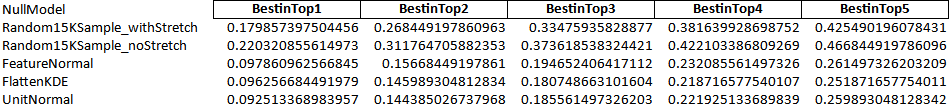

## Distribution of the eValues from the SigClass repeated MOAST 10%hold-out run 

In [3]:
import subprocess,os,sys,pandas as pd,numpy as np,matplotlib.pyplot as plt,seaborn as sns,scipy as sp,shelve,pickle,glob

In [4]:
sigClasses = [x for x in open('PRISMmod_PearsonSigClasses_CommonFeatOrder.lst','r').read().split('\n') if len(x)>0]
print(sigClasses,len(sigClasses))

['COX', 'Histamine.Receptor', 'PI3K', 'DNA.RNA.Synthesis', 'HDAC', 'JAK', 'AChR.antagonist', 'Adrenergic.Receptor.agonist', 'Sodium.Channel', 'Calcium.Channel', 'mTOR', 'CDK', 'Proteasome', 'RAAS', 'Topoisomerase', '5HTR.antagonist', 'HSP', 'P450', 'Aurora.Kinase', 'EGFR', 'MEK', 'Microtubule.Associated', 'VEGFR', 'Estrogen.progestogen.Receptor_agonist', '5HTR.agonist', 'Glucocorticoid.Receptor.agonist', 'VEGFR.KIT.PDGFR', 'GSK-3', 'ABL', 'AChR.agonist', 'BCL', 'EGFR.ERBB', 'Potassium Channel', 'Syk', 'Carbonic.Anhydrase', 'Epigenetic.Reader.Domain', 'IGF-1R', 'IkB.IKK', 'STAT', 'TGF-beta.Smad', 'Akt', 'BTK', 'DUB', 'HMG-CoA.Reductase', 'PDGFR', 'ATM.ATR', 'Autophagy', 'bacterial DNA', 'Gamma-secretase', 'GluR.agonist', 'GluR.antagonist', 'PLK', 'TNF-alpha', 'antioxidant', 'bacterial 50S ribosomal subunit inhibitor', 'bacterial cell wall synthesis inhibitor', 'DPP-4', 'Kinesin', 'MAO', 'p53', 'Src', 'Aromatase', 'bacterial antifolate', 'Chk', 'FAK', 'FLT3', 'ROCK', 'Cysteine.Protease',

In [109]:
eValueMats = pd.read_excel("Densities2Classes_sigClass/random15KSample_1Null_repeatedhold10_All_HeLa-Schem_distScores_New.xlsx",\
                          sheet_name=None,index_col=0)
testSheetName = "10%hold_compScores_0"
eValueMat = eValueMats[testSheetName]

/usr/bin/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

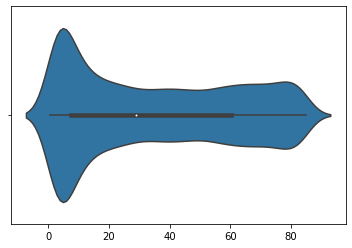

In [115]:
sns.violinplot(eValueMat.loc[:,eValueMat.columns[:86]].to_numpy())

In [84]:
bestEvalueDict = pd.DataFrame( columns = ['BestInTop','MatchingStatus','eValue'])
#     columns = pd.MultiIndex.from_product([[f'BestInTop{j+1}' for j in range(5)],["Matching","Not Matching"]],names=("BestInTop",'MatchingStatus')))
# bestEvalueDict = pd.DataFrame(index=pd.RangeIndex(1000000),columns=['BestInTop','MatchingStatus','eValue'])
# bestEvalueDict.columns.name = ("BestInTop",'MatchingStatus')
print(bestEvalueDict)
rowCount =0
for x in eValueMat.index:
    for z in range(5):
#                 print(f"BestInTop{z+1}\n",eValueMat.loc[x,[f'TopClass{i+1}' for i in range(z+1)]].str.\
#                     contains(eValueMat.loc[x,'PRISMmod_Class']),"\n\n",eValueMat.loc[x,[f'TopClass{i+1}' for i in range(z+1)]].str.\
#                     contains(eValueMat.loc[x,'PRISMmod_Class']).sum())
        if eValueMat.loc[x,f'BestInTop{z+1}'] ==True:
#             bestEvalueDict = bestEvalueDict.append(
#                 pd.DataFrame({'BestInTop':f'BestInTop{z+1}',\
#                               'MatchingStatus':"Matching",\
#                               'eValue': eValueMat.loc[x,eValueMat.loc[x,f"TopClass{z+1}"]]},\
#                                       index=[rowCount])
#             )
            bestEvalueDict.loc[rowCount]= [f'BestInTop{z+1}',"Matching",eValueMat.loc[x,eValueMat.loc[x,f"TopClass{z+1}"]]]
        elif eValueMat.loc[x,f'BestInTop{z+1}'] ==False:
#             bestEvalueDict = bestEvalueDict.append(
#                 pd.DataFrame({'BestInTop':f'BestInTop{z+1}',\
#                               'MatchingStatus':"Not Matching",\
#                               'eValue': eValueMat.loc[x,eValueMat.loc[x,f"TopClass{z+1}"]]},\
#                                       index=[rowCount])
#             )
            bestEvalueDict.loc[rowCount] = [f'BestInTop{z+1}',"Not Matching",eValueMat.loc[x,eValueMat.loc[x,f"TopClass{z+1}"]]]
        rowCount +=1
    
# testDF =pd.DataFrame().from_dict(bestEvalueDict)
print(bestEvalueDict)
# bestEvalueDict = bestEvalueDict.stack().reset_index()
# print(bestEvalueDict.stack())
# testDF = bestEvalueDict.melt()
# print(testDF)

Empty DataFrame
Columns: [BestInTop, MatchingStatus, eValue]
Index: []
      BestInTop MatchingStatus    eValue
0    BestInTop1   Not Matching  0.214534
1    BestInTop2   Not Matching  0.235130
2    BestInTop3   Not Matching  0.238888
3    BestInTop4   Not Matching  0.239830
4    BestInTop5   Not Matching  0.242633
..          ...            ...       ...
930  BestInTop1   Not Matching  0.311937
931  BestInTop2   Not Matching  0.326930
932  BestInTop3   Not Matching  0.329727
933  BestInTop4   Not Matching  0.331605
934  BestInTop5   Not Matching  0.337227

[935 rows x 3 columns]


<AxesSubplot:xlabel='BestInTop', ylabel='eValue'>

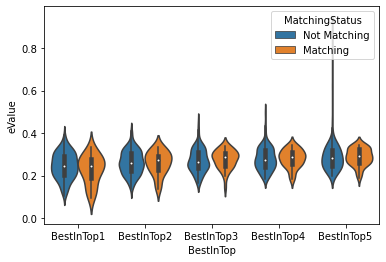

In [85]:
sns.violinplot(data=bestEvalueDict,hue='MatchingStatus',x='BestInTop',y='eValue')

In [6]:
compDictPickleFiles = glob.glob('Densities2Classes_sigClass/*repeatedhold10*compDict.pkl')
compDictPickleFiles.sort()
eValueMatNames = [x.split("/")[-1].replace("_repeatedhold10_refClass_to_compDict.pkl","") for x in compDictPickleFiles]
eValueMatNames = [x.split("\\")[-1].replace("_repeatedhold10_refClass_to_compDict.pkl","") for x in compDictPickleFiles]
eValueMatNames
# eValues = pd.read_excel('Densities2Classes_sigClass/random15KSample_1Null_repeatedhold10_All_HeLa-Schem_noStretch_distScores_New.xlsx',sheet_name=[x for x in range(11)],index_col=0)
# eValues ={x: eValues[x].iloc[:,0:77].copy() for x in eValues.keys()}
# for foldID, foldDF in eValues.items():
#     print(foldDF.head())

['featureNormalNull',
 'flattenKDENull',
 'random15KSample_1Null',
 'random15KSample_2Null',
 'random15KSample_3Null',
 'unitNormalNull']

In [7]:
randomNullMatNames = [x for x in eValueMatNames if 'random15K' in x]
randomNullMatNames

['random15KSample_1Null', 'random15KSample_2Null', 'random15KSample_3Null']

featureNormalNull Densities2Classes_sigClass/featureNormalNull_repeatedhold10_refClass_to_compDict.pkl
         BestInTop MatchingStatus       eValue
count         1763           1763  1763.000000
unique           5              1          NaN
top     BestInTop5       Matching          NaN
freq           489           1763          NaN
mean           NaN            NaN     0.291646
std            NaN            NaN     0.150954
min            NaN            NaN     0.083404
25%            NaN            NaN     0.233266
50%            NaN            NaN     0.280099
75%            NaN            NaN     0.322241
max            NaN            NaN     2.382519


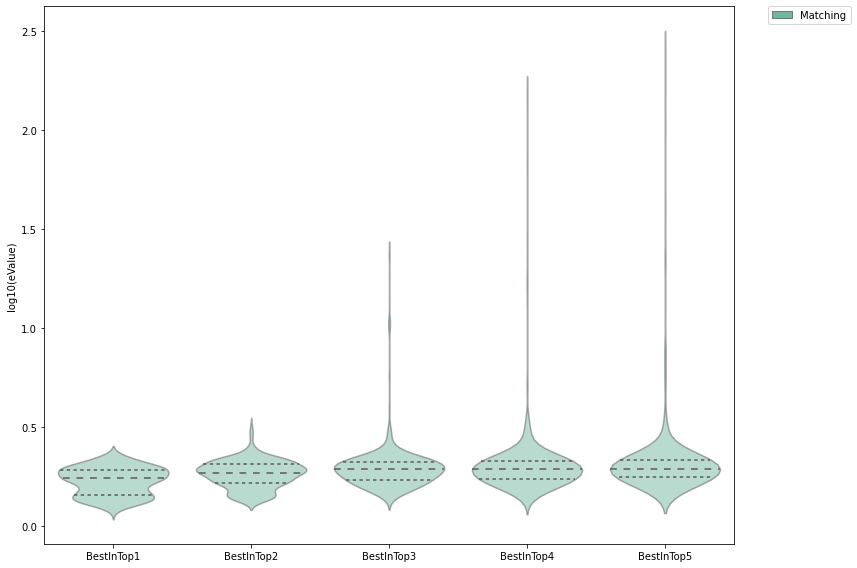

flattenKDENull Densities2Classes_sigClass/flattenKDENull_repeatedhold10_refClass_to_compDict.pkl
         BestInTop MatchingStatus       eValue
count         1671           1671  1671.000000
unique           5              1          NaN
top     BestInTop5       Matching          NaN
freq           471           1671          NaN
mean           NaN            NaN     0.286199
std            NaN            NaN     0.517557
min            NaN            NaN     0.093704
25%            NaN            NaN     0.227167
50%            NaN            NaN     0.272593
75%            NaN            NaN     0.317565
max            NaN            NaN    15.177093


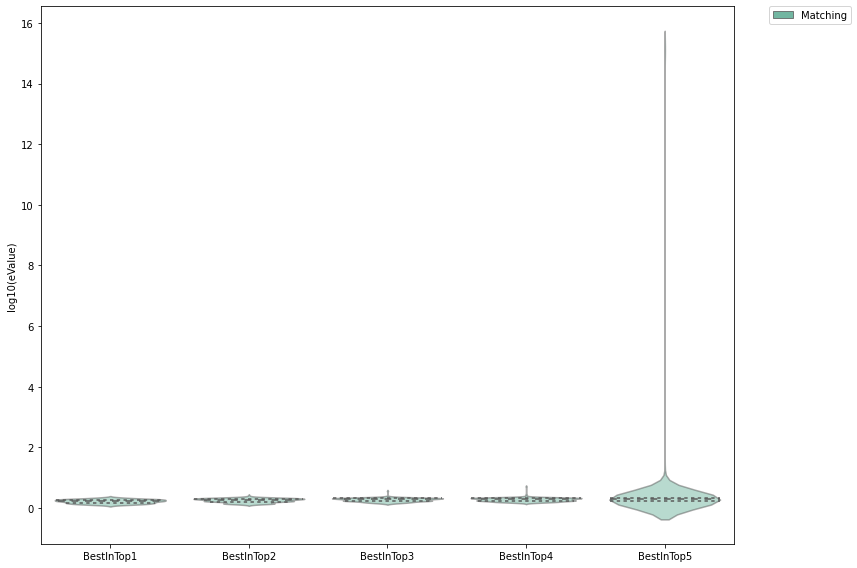

random15KSample_1Null Densities2Classes_sigClass/random15KSample_1Null_repeatedhold10_refClass_to_compDict.pkl
         BestInTop MatchingStatus       eValue
count         2987           2987  2987.000000
unique           5              1          NaN
top     BestInTop5       Matching          NaN
freq           800           2987          NaN
mean           NaN            NaN     3.715798
std            NaN            NaN     3.688112
min            NaN            NaN     0.524575
25%            NaN            NaN     1.873318
50%            NaN            NaN     2.415452
75%            NaN            NaN     3.883606
max            NaN            NaN    39.801430


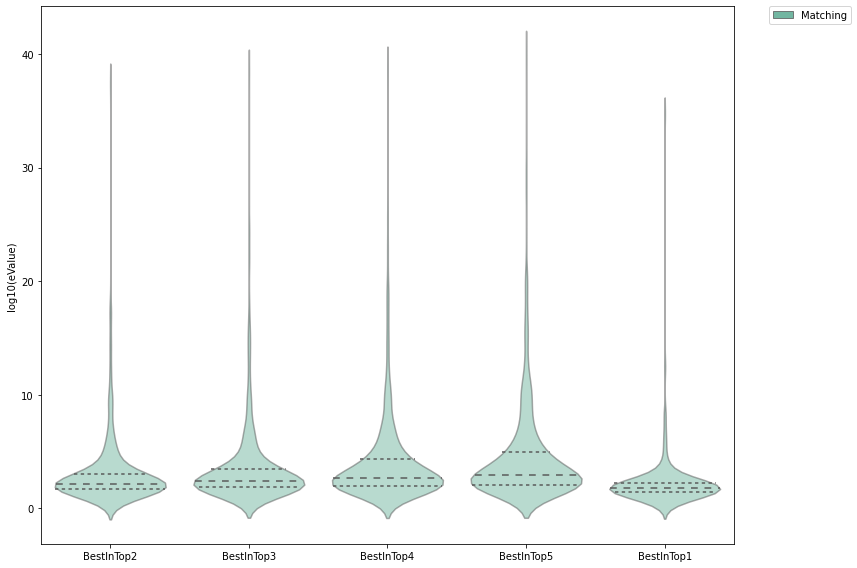

random15KSample_2Null Densities2Classes_sigClass/random15KSample_2Null_repeatedhold10_refClass_to_compDict.pkl
         BestInTop MatchingStatus       eValue
count         3091           3091  3091.000000
unique           5              1          NaN
top     BestInTop5       Matching          NaN
freq           826           3091          NaN
mean           NaN            NaN     3.468397
std            NaN            NaN     3.061397
min            NaN            NaN     0.529019
25%            NaN            NaN     1.821447
50%            NaN            NaN     2.308531
75%            NaN            NaN     3.790550
max            NaN            NaN    27.457794


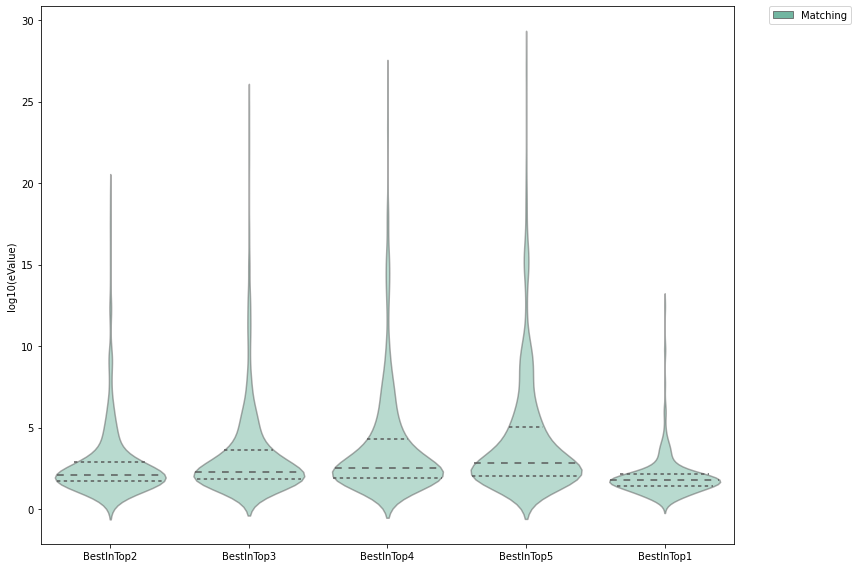

random15KSample_3Null Densities2Classes_sigClass/random15KSample_3Null_repeatedhold10_refClass_to_compDict.pkl
         BestInTop MatchingStatus       eValue
count         2843           2843  2843.000000
unique           5              1          NaN
top     BestInTop5       Matching          NaN
freq           761           2843          NaN
mean           NaN            NaN     3.648049
std            NaN            NaN     3.736401
min            NaN            NaN     0.524898
25%            NaN            NaN     1.871954
50%            NaN            NaN     2.424543
75%            NaN            NaN     4.032659
max            NaN            NaN    40.075735


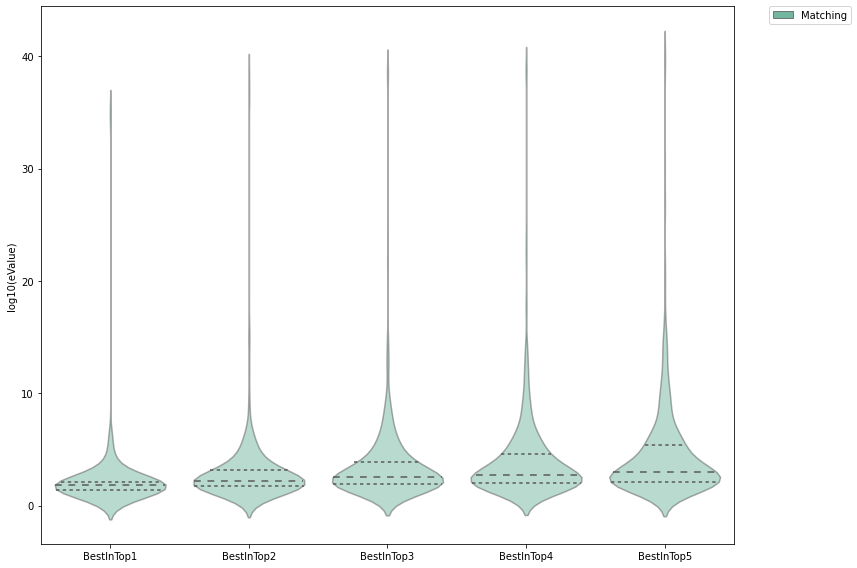

unitNormalNull Densities2Classes_sigClass/unitNormalNull_repeatedhold10_refClass_to_compDict.pkl
         BestInTop MatchingStatus       eValue
count         1691           1691  1691.000000
unique           5              1          NaN
top     BestInTop5       Matching          NaN
freq           486           1691          NaN
mean           NaN            NaN     0.289123
std            NaN            NaN     0.564182
min            NaN            NaN     0.083405
25%            NaN            NaN     0.229521
50%            NaN            NaN     0.271664
75%            NaN            NaN     0.315701
max            NaN            NaN    19.226889


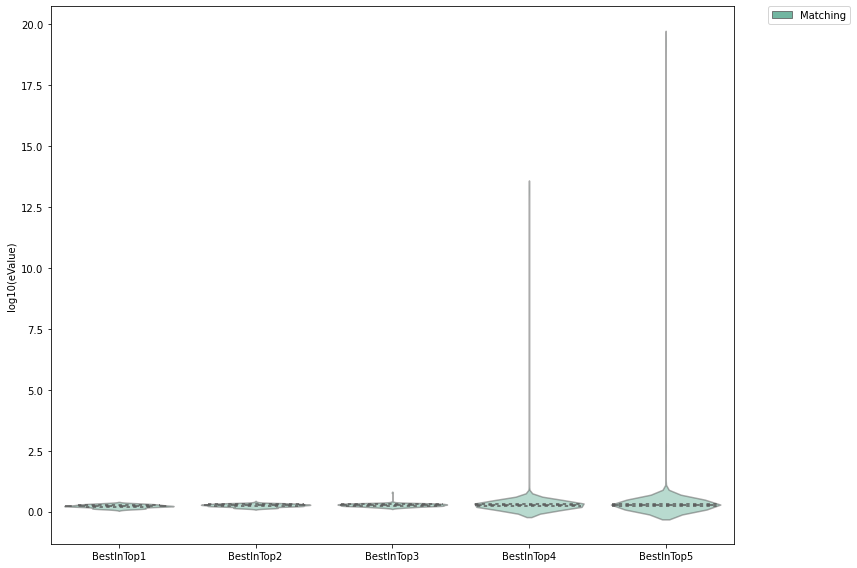

In [117]:
nullModelType = {x:dict() for x in dict().fromkeys(eValueMatNames)}

for nullModel, refClass_compDict in zip(eValueMatNames,compDictPickleFiles):
    print(nullModel, refClass_compDict)
#     refClass_compDict = pickle.load(open(refClass_compDict,'rb'))
    eValueMats = pd.read_excel(f"Densities2Classes_sigClass/{nullModel}_repeatedhold10_All_HeLa-Schem_distScores_New.xlsx",\
                               sheet_name=None,index_col=0)
#     saveFile = pd.ExcelWriter(f"Densities2Classes_sigClass/{nullModel}_repeatedhold10_All_HeLa-Schem_noStretch_distScores_New2.xlsx",mode='w')
#     bestFoldSums = {x:dict() for x in dict().fromkeys([f'fold_{y}' for y in range(10)])}
#     bestFoldPercentages = {x:dict() for x in dict().fromkeys([f'fold_{y}' for y in range(10)])}
    bestEvalueDict = pd.DataFrame( columns = ['BestInTop','MatchingStatus','eValue'])
    rowCount =0
    for fold in range(10):
        saveSheetName = f"10%hold_compScores_{fold}"
        eValueMat = eValueMats[saveSheetName] #(compounds are on the row, classes in the columns)
        for x in eValueMat.index:
            for z in range(5):
                if eValueMat.loc[x,f'BestInTop{z+1}'] ==True:
        #             bestEvalueDict = bestEvalueDict.append(
        #                 pd.DataFrame({'BestInTop':f'BestInTop{z+1}',\
        #                               'MatchingStatus':"Matching",\
        #                               'eValue': eValueMat.loc[x,eValueMat.loc[x,f"TopClass{z+1}"]]},\
        #                                       index=[rowCount])
        #             )
                    bestEvalueDict.loc[rowCount]= [f'BestInTop{z+1}',"Matching",eValueMat.loc[x,eValueMat.loc[x,f"TopClass{z+1}"]]]
                elif eValueMat.loc[x,f'BestInTop{z+1}'] ==False:
        #             bestEvalueDict = bestEvalueDict.append(
        #                 pd.DataFrame({'BestInTop':f'BestInTop{z+1}',\
        #                               'MatchingStatus':"Not Matching",\
        #                               'eValue': eValueMat.loc[x,eValueMat.loc[x,f"TopClass{z+1}"]]},\
        #                                       index=[rowCount])
        #             )
#                     pass
                    bestEvalueDict.loc[rowCount] = [f'BestInTop{z+1}',"Not Matching",eValueMat.loc[x,eValueMat.loc[x,f"TopClass{z+1}"]]]
                rowCount +=1
    print(bestEvalueDict.describe(include='all'))
#     bestEvalueDict['eValue'] = bestEvalueDict['eValue'].apply(np.log10)
    plt.figure(figsize=(12,8))
    ax = sns.violinplot(data=bestEvalueDict,hue='MatchingStatus',x='BestInTop',y='eValue',
                        palette='Set2',kind='violin',
                       inner='quartiles',position=0)
    ax.get_xticks()
    plt.setp(ax.collections,alpha=.5)
    # sns.pointplot(x='BestInTop',y=0,hue='NullModel',data=summaryScores2,palette='Set1',marker='.',
    #               size=15,linestyle="")
    plt.ylabel('log10(eValue)')
    plt.xlabel("")
#     plt.ylim(ax.get_ylim()[0],15)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show() 
#     plt.savefig(f'Densities2Classes_sigClass/{nullModel}_sigClass_repeated10holdOut_noStretch_EvalueSummary.png',dpi=300)
    
    
        #clean up the key_annot column (listed annotation in current annotation file)
#         key_annot = eValueMat['Key_annot'].apply(lambda s: s.replace("'",'').replace(']','').replace("[",''))
#         eValueMat.drop(columns='Key_annot',inplace=True) #drop it cause we np.array rn, but we'll put it back with a new name soon
#         eValueMat_0 = eValueMat.copy() #take a copy to work on without the annotations
#         eValueMat["Key_annot"]=key_annot
#         for i in range(5):
# #             Axis along which the function is applied:
# #             0 or ‘index’: apply function to each column.
# #             1 or ‘columns’: apply function to each row. (compounds are on the row, classes in the columns)
#             newcolname = f'TopClass{i+1}'
# #             argsort to get the class names that are the top N best scoring
#             eValueMat[newcolname] = eValueMat_0.columns[eValueMat_0.apply(np.argsort,axis=1)][:,i]
# #             eValueMat['BestClass'] = eValueMat_0.columns[eValueMat_0.apply(np.argmin,axis=1)]
#         for c in refClass_compDict.keys(): #reconstruct the listed annotation column (sanity check with Key_annot column)
# #                 print(c)
#             try:
#                 eValueMat.loc[[str(x) for x in refClass_compDict[c]['comps'] if str(x) in eValueMat.index],'PRISMmod_Class'] = c
#             except KeyError:
#                 print("KeyError when pulling back the Key_annot")
#         print((eValueMat['PRISMmod_Class'] == key_annot).sum(),len(key_annot),len(eValueMat['PRISMmod_Class']))
#         for x in eValueMat.index:
#             for z in range(5):
# #                 print(f"BestInTop{z+1}\n",eValueMat.loc[x,[f'TopClass{i+1}' for i in range(z+1)]].str.\
# #                     contains(eValueMat.loc[x,'PRISMmod_Class']),"\n\n",eValueMat.loc[x,[f'TopClass{i+1}' for i in range(z+1)]].str.\
# #                     contains(eValueMat.loc[x,'PRISMmod_Class']).sum())
#                 eValueMat.loc[x,f"BestInTop{z+1}"] = (eValueMat.loc[x,[f'TopClass{i+1}' for i in range(z+1)]].str.\
#                     contains(eValueMat.loc[x,'PRISMmod_Class']).sum() >0)
#         for i in range(5):
# #             collect the bestintop counts and percentages for each fold to store in a master summary table sheet
#             bestFoldSums[f'fold_{fold}'][f'BestinTop{i+1}'] = (eValueMat[f'BestInTop{i+1}']== True).sum()
#             bestFoldPercentages[f'fold_{fold}'][f'BestinTop{i+1}'] = (eValueMat[f'BestInTop{i+1}']== True).sum()/len(eValueMat[f'BestInTop{i+1}']== True)
#         eValueMat.to_excel(saveFile,sheet_name=saveSheetName,engine='xlsxwriter')
#     bestSumScores = pd.DataFrame().from_records(bestFoldSums)
#     bestSumScores['average'] = bestSumScores.mean(axis=1)
#     bestPercentageScores = pd.DataFrame().from_records(bestFoldPercentages)
#     bestPercentageScores['average'] = bestPercentageScores.mean(axis=1)
#     bestSumScores.to_excel(saveFile,sheet_name='BestInSummarySums',engine='xlsxwriter')
#     bestPercentageScores.to_excel(saveFile,sheet_name='BestInSummaryPcts',engine='xlsxwriter')
#     nullModelType[nullModel]['Percentages'] = bestPercentageScores
#     nullModelType[nullModel]['Sums'] = bestSumScores
#     saveFile.save()

in order to create a violin that relates evalue to our confidence in a predicted annoation, we need to interrogate the evalue matrices class by class, collating the list of evalues for queries that call that claim that class annotation, vs everything else queried.

to this end, we need the class annoation of each query, in pools(?), and we don't care the rank of the match, just the evalue of the correct match.

In [10]:
testComposite = list()
testDF = pd.DataFrame()
for nullModel, refClass_compDict in zip(randomNullMatNames,compDictPickleFiles):
    print(nullModel, refClass_compDict)
#     refClass_compDict = pickle.load(open(refClass_compDict,'rb'))
    eValueMats = pd.read_excel(f"Densities2Classes_sigClass/{nullModel}_repeatedhold10_All_HeLa-Schem_noStretch_distScores_New.xlsx",\
                               sheet_name=None,index_col=0)
    print(type(eValueMats))
    DF = pd.concat([x[1] for x in eValueMats.items() if x[0].startswith("10%hold_compScores_")])
    testDF = pd.concat([testDF,DF])
    

random15KSample_1Null Densities2Classes_sigClass\featureNormalNull_repeatedhold10_refClass_to_compDict.pkl
<class 'dict'>
random15KSample_2Null Densities2Classes_sigClass\flattenKDENull_repeatedhold10_refClass_to_compDict.pkl
<class 'dict'>
random15KSample_3Null Densities2Classes_sigClass\random15KSample_1Null_repeatedhold10_refClass_to_compDict.pkl
<class 'dict'>


In [11]:
from collections import Counter

In [12]:
all_randomNullEvalues = testDF
Counter(all_randomNullEvalues.index.to_list())
all_randomNullEvalues.reset_index(inplace=True)

In [20]:
melted_all = all_randomNullEvalues.iloc[:,:88].melt(id_vars=['index','Key_annot'],var_name=['MOA_Class'],value_name='eValue')
# for i,ix in enumerate(melted_all['index']):
#     print(all_randomNullEvalues.loc[all_randomNullEvalues['index'] ==ix]['PRISMmod_Class'])
#     if melted_all.loc[i,'MOA_Class'] == all_randomNullEvalues.loc[all_randomNullEvalues['index'] ==ix,'PRISMmod_Class']:
#         melted_all.loc[i,'Matching_Status']='Matching'
#     elif melted_all.loc[i,'MOA_Class'] != all_randomNullEvalues.loc[all_randomNullEvalues['index'] ==ix,'PRISMmod_Class']:
#         melted_all.loc[i,'Matching_Status'] ='Not Matching'
        
melted_all['Matching'] = melted_all['Key_annot'] == melted_all['MOA_Class']
melted_all['Matching'] = melted_all['Matching'].apply(lambda s: 'Matching' if s else 'Not Matching')
melted_all.drop(columns=['index','Key_annot'],inplace=True)
melted_all

MOA_Class     eValue      Matching
0                DUB  44.225424  Not Matching
1                DUB  53.914073  Not Matching
2                DUB   1.957709  Not Matching
3                DUB   2.217123  Not Matching
4                DUB   7.191954  Not Matching
...              ...        ...           ...
482455  5HTR.agonist  79.730528  Not Matching
482456  5HTR.agonist  28.388809  Not Matching
482457  5HTR.agonist  79.730528  Not Matching
482458  5HTR.agonist  82.955417  Not Matching
482459  5HTR.agonist  83.585080  Not Matching

[482460 rows x 3 columns]

In [13]:
matchEvalueStatus = {x:{'Matching':[],'Not Matching':[]} for x in dict().fromkeys(sigClasses)}
EvalueDict = pd.DataFrame(index =pd.RangeIndex(5610*86), columns = ['PRISMmod_Class','Matching_Status','eValue'])
rowCount =0
for z in sigClasses:
    
    for x in all_randomNullEvalues.index:
        if z == all_randomNullEvalues.loc[x,'PRISMmod_Class']:
            matchEvalueStatus[z]['Matching'].append(all_randomNullEvalues.loc[x,z])
            EvalueDict.loc[rowCount] = [z,'Matching',all_randomNullEvalues.loc[x,z]]
            rowCount +=1

        elif z != all_randomNullEvalues.loc[x,'PRISMmod_Class']:
            matchEvalueStatus[z]['Not Matching'].append(all_randomNullEvalues.loc[x,z])
            EvalueDict.loc[rowCount] = [z,'Not Matching',all_randomNullEvalues.loc[x,z]]
            rowCount +=1

#     print(EvalueDict.describe(include='all'))
#     plt.figure(figsize=(12,8))
#     ax = sns.violinplot(data=EvalueDict,x='MatchingStatus',y='eValue',
#                         palette='Set2',kind='violin',
#                        inner='box')#,position=0)
#     #     ax.get_xticks()
#     ax.set_xticklabels(ax.get_xticklabels(),rotation=45,size=12,ha='right', rotation_mode='anchor')
#     plt.setp(ax.collections,alpha=.5)
#     #     # sns.pointplot(x='BestInTop',y=0,hue='NullModel',data=summaryScores2,palette='Set1',marker='.',
#     #     #               size=15,linestyle="")
#     #     plt.ylabel('log10(eValue)')
#     #     plt.xlabel("")
#     # #     plt.ylim(ax.get_ylim()[0],15)
#     #     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.title(z)
#     plt.tight_layout()
#     plt.show()
    
pd.DataFrame(matchEvalueStatus)
EvalueDict
#     bestEvalueDict['eValue'] = bestEvalueDict['eValue'].apply(np.log10)
#     

PRISMmod_Class Matching_Status     eValue
0                 COX    Not Matching   3.411346
1                 COX    Not Matching   2.903596
2                 COX    Not Matching  81.825689
3                 COX    Not Matching  71.894048
4                 COX    Not Matching  60.638975
...               ...             ...        ...
482455   LPA.Receptor    Not Matching  72.519266
482456   LPA.Receptor    Not Matching  20.116326
482457   LPA.Receptor    Not Matching  81.753707
482458   LPA.Receptor    Not Matching  76.878701
482459   LPA.Receptor    Not Matching  85.445308

[482460 rows x 3 columns]

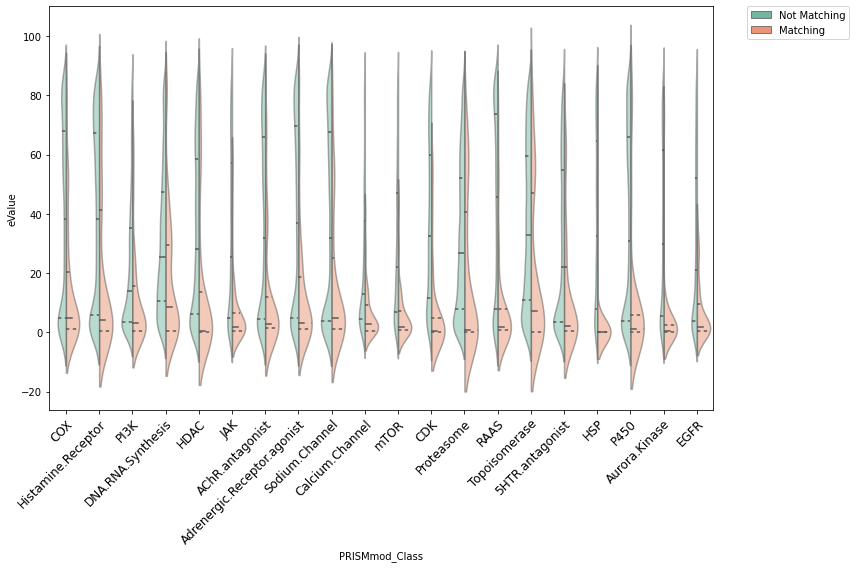

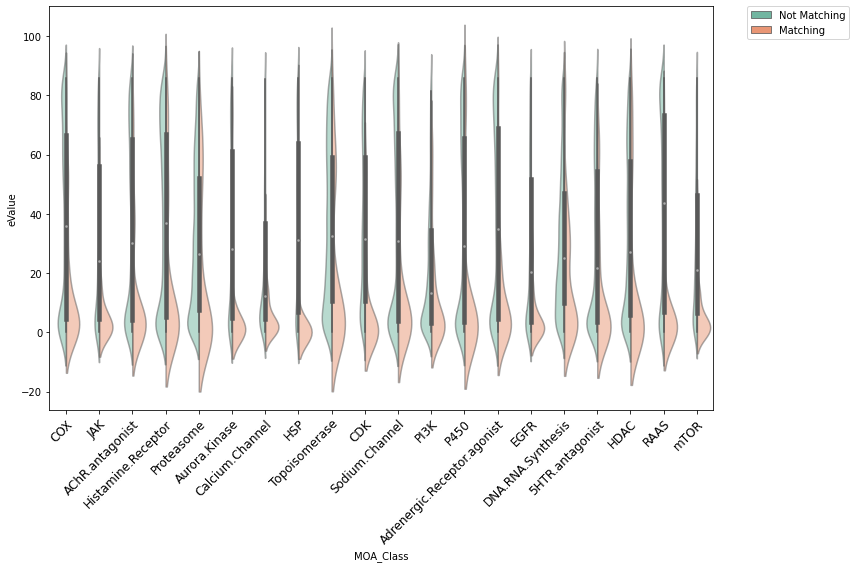

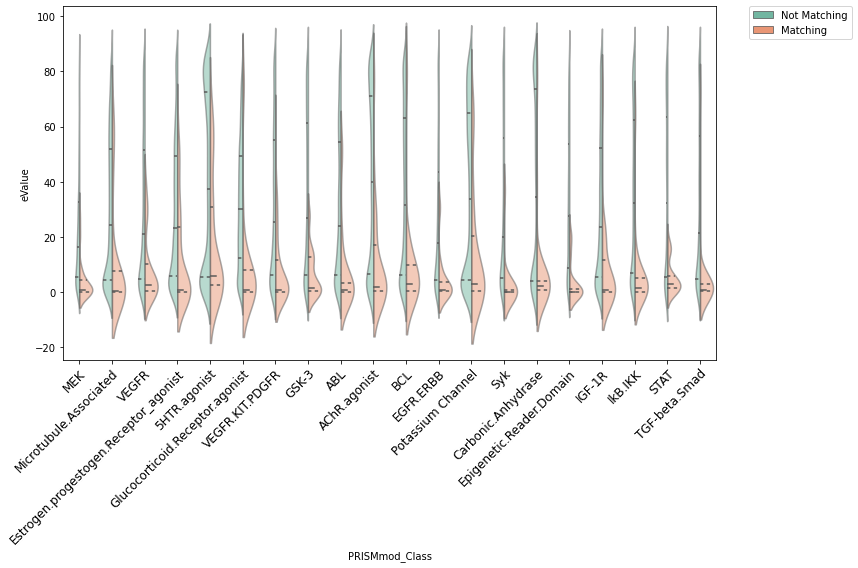

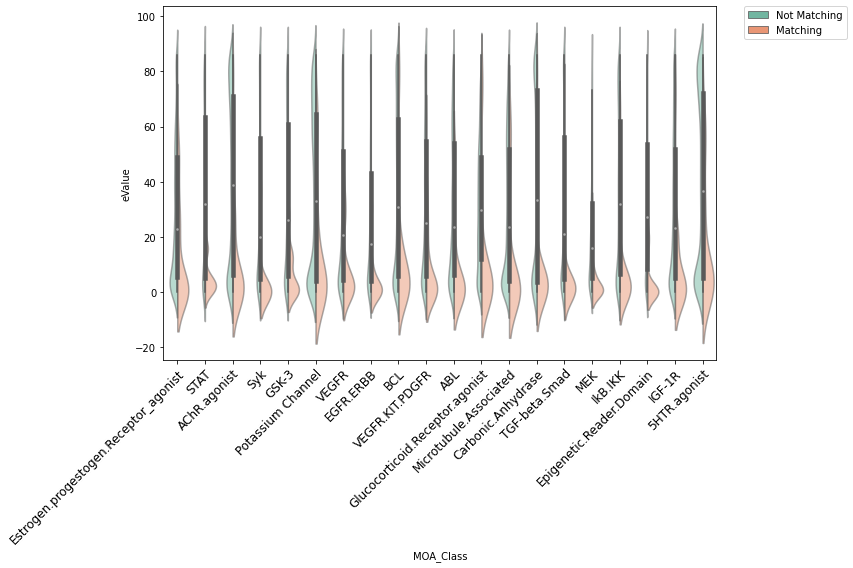

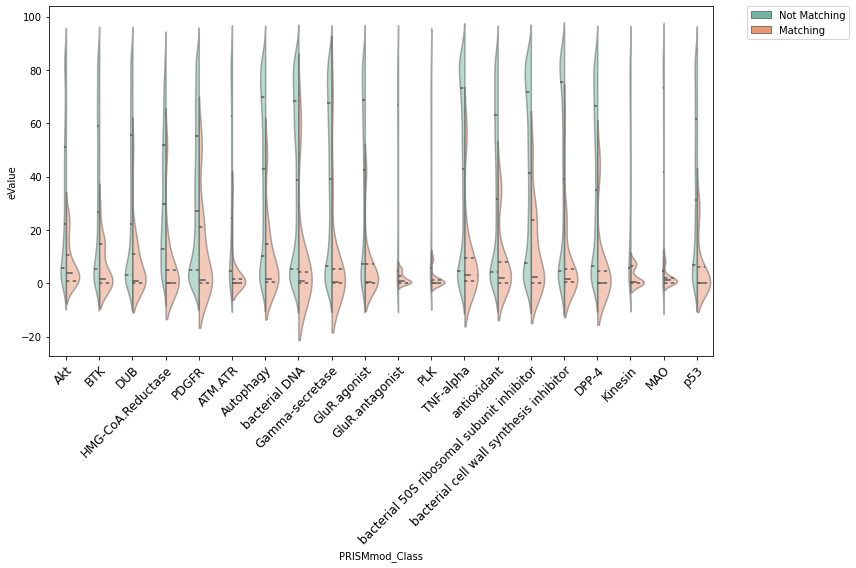

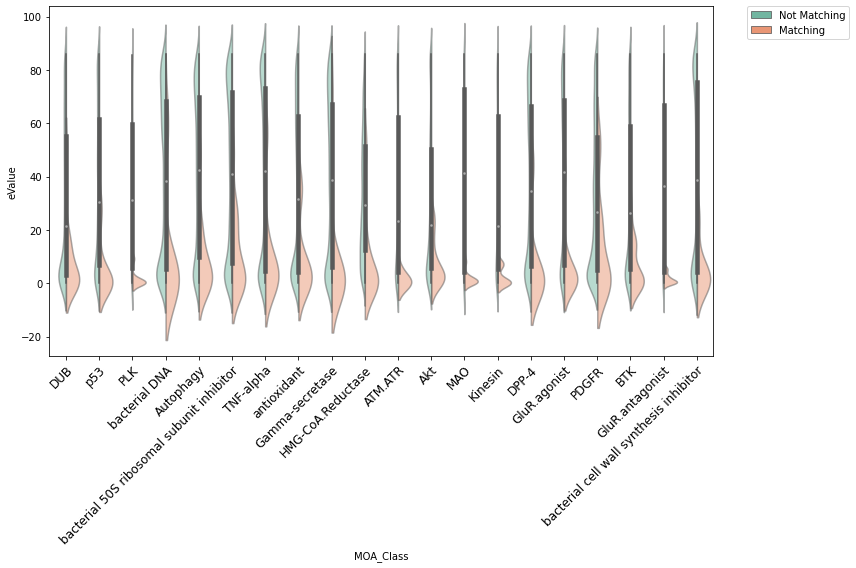

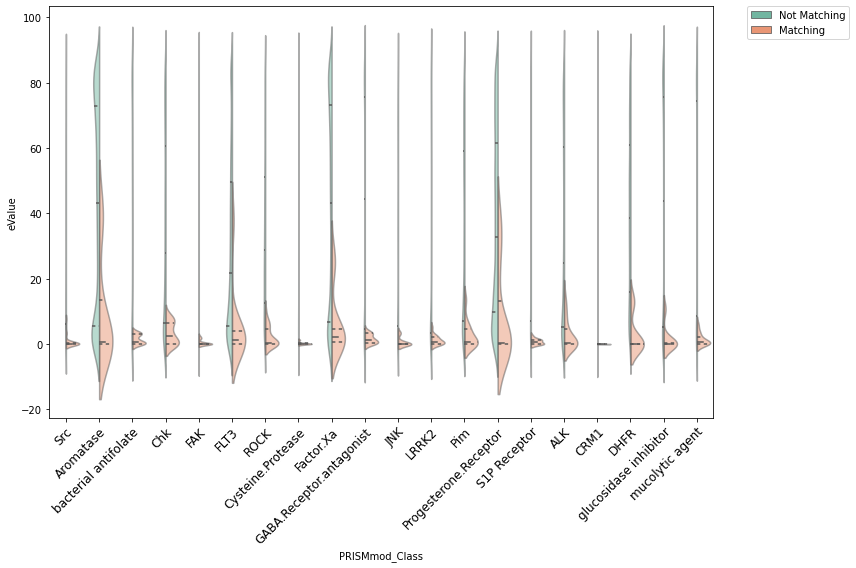

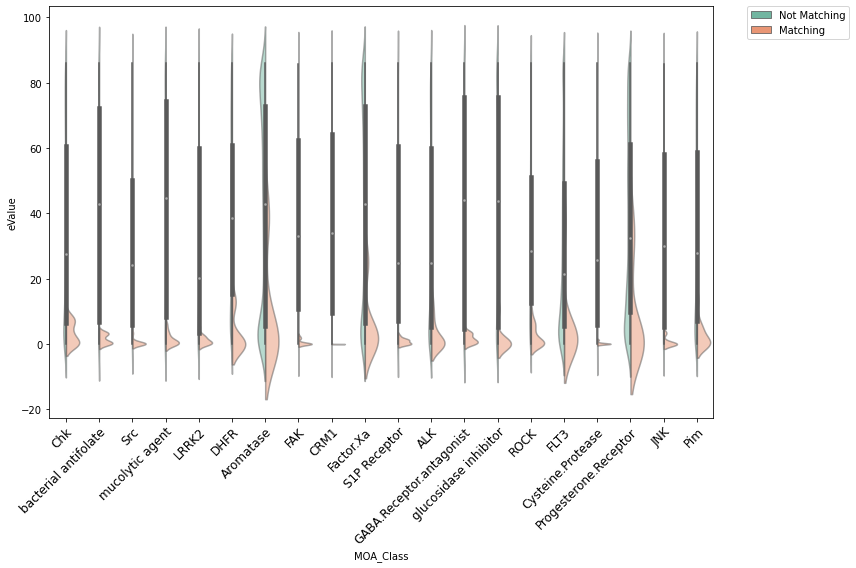

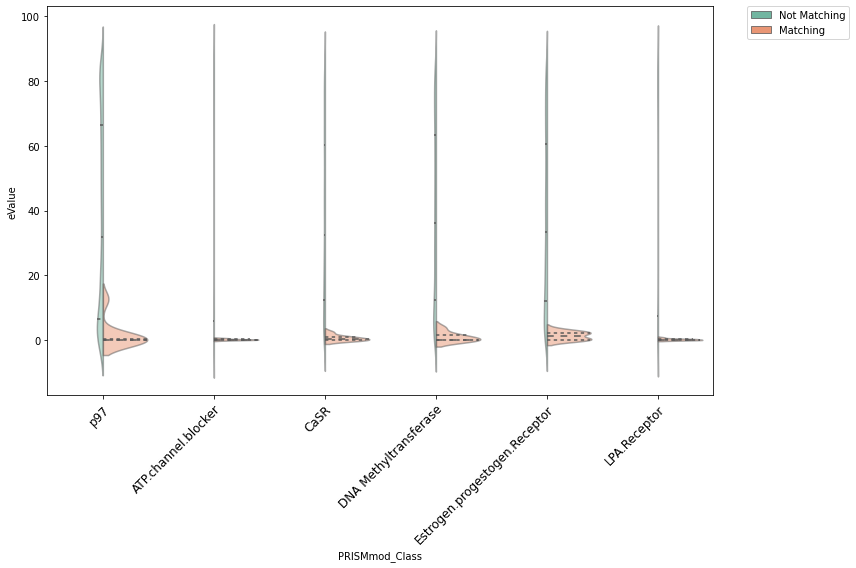

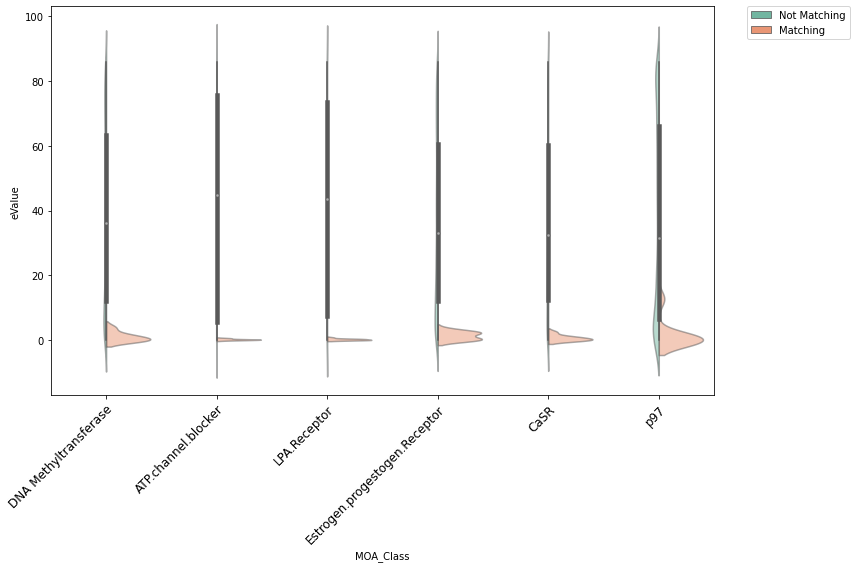

In [17]:
# print(bestEvalueDict)
# sig_moaClasses = sorted(bestEvalueDict['MOA_Class'].unique())
# [print(sig_moaClasses[i:i+20]) for i in range(0,len(sig_moaClasses),20)]
# [lst[i:i + n] for i in range(0, len(lst), n)]

for i in range(0,len(sigClasses)+1,20):
    plotClasses = sigClasses[i:i+20]
    
    dataSubset = EvalueDict.loc[EvalueDict['PRISMmod_Class'].isin(plotClasses)].copy()
    dataSubset['eValue'] = dataSubset['eValue'].astype(float)
    plt.figure(figsize=(12,8))
    ax = sns.violinplot(data=dataSubset,hue='Matching_Status',x='PRISMmod_Class',y='eValue',
                        palette='Set2',kind='violin',split=True,
                       inner='quartiles',position=0)
    #     ax.get_xticks()
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,size=12,ha='right', rotation_mode='anchor')
    plt.setp(ax.collections,alpha=.5)
    #     # sns.pointplot(x='BestInTop',y=0,hue='NullModel',data=summaryScores2,palette='Set1',marker='.',
    #     #               size=15,linestyle="")
    #     plt.ylabel('log10(eValue)')
    #     plt.xlabel("")
    # #     plt.ylim(ax.get_ylim()[0],15)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(f'Random15KNull_eValue_by_sigClass_quartiles_{i}.png',dpi=300)
#     plt.show()
    
    dataSubset = melted_all.loc[melted_all['MOA_Class'].isin(plotClasses)].copy()
    dataSubset['eValue'] = dataSubset['eValue'].astype(float)
    plt.figure(figsize=(12,8))
    ax = sns.violinplot(data=dataSubset,hue='Matching',x='MOA_Class',y='eValue',
                        palette='Set2',kind='violin',split=True,
                       inner='box',position=0)
    #     ax.get_xticks()
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,size=12,ha='right', rotation_mode='anchor')
    plt.setp(ax.collections,alpha=.5)
    #     # sns.pointplot(x='BestInTop',y=0,hue='NullModel',data=summaryScores2,palette='Set1',marker='.',
    #     #               size=15,linestyle="")
    #     plt.ylabel('log10(eValue)')
    #     plt.xlabel("")
    # #     plt.ylim(ax.get_ylim()[0],15)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(f'Random15KNull_eValue_by_sigClass_box_{i}.png',dpi=300)
#     plt.show()

In [18]:
pd.__version__

'1.2.5'

### Plotting 10% holdout percentages

taking the BestInSummaryPcts, we should maybe plot them as lines for each 'bestin'category and the average as a dashed line?

In [30]:
import subprocess,os,sys,pandas as pd,numpy as np,matplotlib.pyplot as plt,seaborn as sns,scipy as sp,shelve,pickle,glob

In [33]:
summaryScores = pd.read_excel('repeatedhold10_scores.xlsx',sheet_name=None,index_col=0)
summaryScores.pop('avgSummary')
[summaryScores.pop(x) for x in summaryScores.copy().keys() if x.endswith('Sums')]
summaryScores = pd.concat(summaryScores)
summaryScores.index = summaryScores.index.swaplevel()
fullNames = {'UnitNorm':'UnitNormal','featNorm':'FeatureNormal','flatnKDE':'FlattenedKDE','Random15K':"Random15KSample"}
summaryScores.index = pd.MultiIndex.from_tuples([(x[0],fullNames[x[1].split("_")[0]]) for x in summaryScores.index], names=('BestInTop','NullModel'))
# summaryScores.reset_index(inplace=True, level=1)
# summaryScores.rename(columns = {'level_1':'NullModel'},inplace=True)

allAvg = summaryScores.average.copy()
summaryScores1 = summaryScores.drop(columns='average')
summaryScores.T

BestInTop BestinTop1 BestinTop2 BestinTop3 BestinTop4 BestinTop5  \
NullModel UnitNormal UnitNormal UnitNormal UnitNormal UnitNormal   
fold_0      0.083333   0.101852   0.104938   0.114198   0.129630   
fold_1      0.086420   0.108025   0.114198   0.126543   0.129630   
fold_2      0.095679   0.108025   0.117284   0.138889   0.157407   
fold_3      0.077160   0.095679   0.101852   0.104938   0.135802   
fold_4      0.067901   0.086420   0.095679   0.101852   0.111111   
fold_5      0.101852   0.117284   0.126543   0.141975   0.154321   
fold_6      0.089506   0.108025   0.114198   0.132716   0.154321   
fold_7      0.080247   0.098765   0.101852   0.108025   0.120370   
fold_8      0.080247   0.092593   0.101852   0.104938   0.117284   
fold_9      0.089506   0.101852   0.108025   0.117284   0.135802   
average     0.085185   0.101852   0.108642   0.119136   0.134568   

BestInTop    BestinTop1    BestinTop2    BestinTop3    BestinTop4  \
NullModel FeatureNormal FeatureNormal FeatureNormal FeatureNormal   
fold_0         0.086420      0.101852      0.117284      0.129630   
fold_1         0.064815      0.070988      0.083333      0.098765   
fold_2         0.064815      0.080247      0.089506      0.095679   
fold_3         0.080247      0.111111      0.126543      0.138889   
fold_4         0.080247      0.092593      0.092593      0.104938   
fold_5         0.067901      0.080247      0.089506      0.101852   
fold_6         0.111111      0.120370      0.132716      0.148148   
fold_7         0.061728      0.077160      0.083333      0.095679   
fold_8         0.101852      0.114198      0.126543      0.135802   
fold_9         0.092593      0.114198      0.120370      0.135802   
average        0.081173      0.096296      0.106173      0.118519   

BestInTop    BestinTop5  ...      BestinTop1      BestinTop2      BestinTop3  \
NullModel FeatureNormal  ... Random15KSample Random15KSample Random15KSample   
fold_0         0.145062  ...        0.117284        0.141975        0.206790   
fold_1         0.120370  ...        0.101852        0.141975        0.179012   
fold_2         0.117284  ...        0.077160        0.108025        0.126543   
fold_3         0.141975  ...        0.135802        0.197531        0.225309   
fold_4         0.123457  ...        0.111111        0.157407        0.182099   
fold_5         0.126543  ...        0.138889        0.188272        0.216049   
fold_6         0.160494  ...        0.098765        0.151235        0.172840   
fold_7         0.126543  ...        0.101852        0.157407        0.203704   
fold_8         0.160494  ...        0.135802        0.185185        0.206790   
fold_9         0.148148  ...        0.080247        0.138889        0.166667   
average        0.137037  ...        0.109877        0.156790        0.188580   

BestInTop      BestinTop4      BestinTop5      BestinTop1      BestinTop2  \
NullModel Random15KSample Random15KSample Random15KSample Random15KSample   
fold_0           0.231481        0.246914        0.104938        0.166667   
fold_1           0.212963        0.246914        0.123457        0.160494   
fold_2           0.145062        0.188272        0.098765        0.148148   
fold_3           0.237654        0.256173        0.101852        0.145062   
fold_4           0.219136        0.243827        0.092593        0.132716   
fold_5           0.250000        0.265432        0.123457        0.151235   
fold_6           0.206790        0.216049        0.098765        0.138889   
fold_7           0.225309        0.250000        0.132716        0.175926   
fold_8           0.240741        0.259259        0.117284        0.166667   
fold_9           0.200617        0.225309        0.117284        0.154321   
average          0.216975        0.239815        0.111111        0.154012   

BestInTop      BestinTop3      BestinTop4      BestinTop5  
NullModel Random15KSample Random15KSample Random15KSample  
fold_0           0.209877        0.237654        0.271

{'UnitNormal': 0.08518518518518517, 'FeatureNormal': 0.08117283950617284, 'FlattenedKDE': 0.08456790123456791, 'Random15KSample': 0.1111111111111111}


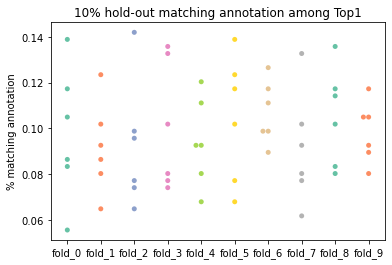

{'UnitNormal': 0.1018518518518518, 'FeatureNormal': 0.09629629629629628, 'FlattenedKDE': 0.1027777777777778, 'Random15KSample': 0.1540123456790123}


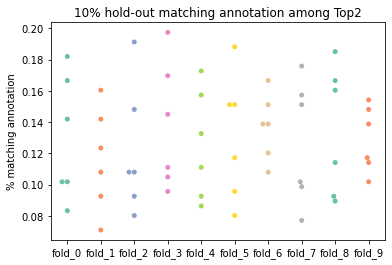

{'UnitNormal': 0.108641975308642, 'FeatureNormal': 0.1061728395061728, 'FlattenedKDE': 0.1101851851851852, 'Random15KSample': 0.1941358024691358}


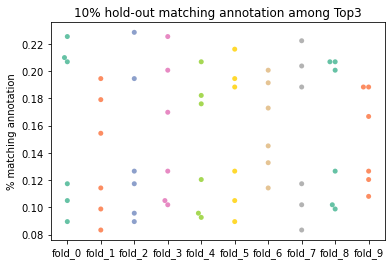

{'UnitNormal': 0.1191358024691358, 'FeatureNormal': 0.1185185185185185, 'FlattenedKDE': 0.1231481481481481, 'Random15KSample': 0.2271604938271605}


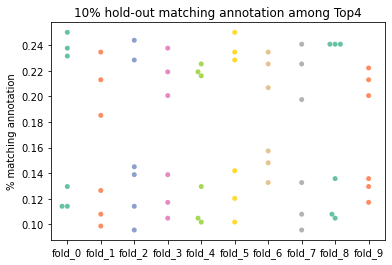

{'UnitNormal': 0.1345679012345679, 'FeatureNormal': 0.137037037037037, 'FlattenedKDE': 0.1354938271604938, 'Random15KSample': 0.2546296296296297}


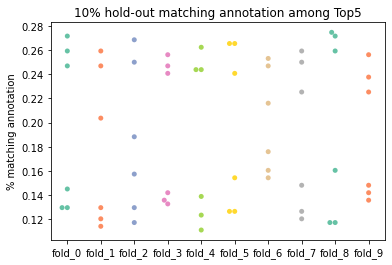

Index(['BestinTop1', 'BestinTop2', 'BestinTop3', 'BestinTop4', 'BestinTop5',
       'BestinTop1', 'BestinTop2', 'BestinTop3', 'BestinTop4', 'BestinTop5',
       'BestinTop1', 'BestinTop2', 'BestinTop3', 'BestinTop4', 'BestinTop5',
       'BestinTop1', 'BestinTop2', 'BestinTop3', 'BestinTop4', 'BestinTop5',
       'BestinTop1', 'BestinTop2', 'BestinTop3', 'BestinTop4', 'BestinTop5',
       'BestinTop1', 'BestinTop2', 'BestinTop3', 'BestinTop4', 'BestinTop5'],
      dtype='object', name='BestInTop') 

                               fold_0    fold_1    fold_2    fold_3    fold_4  \
NullModel       BestInTop                                                      
UnitNormal      BestinTop1  0.083333  0.086420  0.095679  0.077160  0.067901   
                BestinTop2  0.101852  0.108025  0.108025  0.095679  0.086420   
                BestinTop3  0.104938  0.114198  0.117284  0.101852  0.095679   
                BestinTop4  0.114198  0.126543  0.138889  0.104938  0.101852   
              

NullModel   BestInTop   average
0        UnitNormal  BestinTop1  0.085185
1        UnitNormal  BestinTop2  0.101852
2        UnitNormal  BestinTop3  0.108642
3        UnitNormal  BestinTop4  0.119136
4        UnitNormal  BestinTop5  0.134568
5     FeatureNormal  BestinTop1  0.081173
6     FeatureNormal  BestinTop2  0.096296
7     FeatureNormal  BestinTop3  0.106173
8     FeatureNormal  BestinTop4  0.118519
9     FeatureNormal  BestinTop5  0.137037
10     FlattenedKDE  BestinTop1  0.084568
11     FlattenedKDE  BestinTop2  0.102778
12     FlattenedKDE  BestinTop3  0.110185
13     FlattenedKDE  BestinTop4  0.123148
14     FlattenedKDE  BestinTop5  0.135494
15  Random15KSample  BestinTop1  0.117284
16  Random15KSample  BestinTop2  0.161728
17  Random15KSample  BestinTop3  0.198765
18  Random15KSample  BestinTop4  0.224691
19  Random15KSample  BestinTop5  0.249074
20  Random15KSample  BestinTop1  0.109877
21  Random15KSample  BestinTop2  0.156790
22  Random15KSample  BestinTop3  0.188580
23  Random15KSample  BestinTop4  0.216975
24  Random15KSample  BestinTop5  0.239815
25  Random15KSample  BestinTop1  0.111111
26  Random15KSample  BestinTop2  0.154012
27  Random15KSample  BestinTop3  0.194136
28  Random15KSample  BestinTop4  0.227160
29  Random15KSample  BestinTop5  0.254630

<Figure size 720x576 with 0 Axes>

In [34]:
for i in range(5):
    data = summaryScores.loc[f'BestinTop{i+1}'].copy()
#     print(data.head())
#     print(data.stack())
    avgs = data.average.copy()
    data.drop(columns='average',inplace=True)
#     print(avgs)
#     ax = data.T.plot()
    ax = sns.swarmplot(data=data,palette='Set2')
    print(avgs.to_dict())

    xmin,xmax = ax.get_xlim()
    handles, labels = ax.get_legend_handles_labels()

#     for j,(label, y) in enumerate(avgs.to_dict().items()):
#         plt.hlines(y=y,xmin=xmin,xmax=xmax,label=label,color=handles[j].get_color(),ls='--')
    
    plt.ylabel("% matching annotation")
    plt.title(f'10% hold-out matching annotation among Top{i+1}')
    plt.show()
    plt.close()

summaryScores1.index = summaryScores1.index.swaplevel()
print(summaryScores1.T.columns.get_level_values(1),"\n\n",summaryScores1)
# ax = sns.stripplot(data=summaryScores1.T,palette='Set1',hue=summaryScores1.T.columns.get_level_values(1))
summaryScores2 = summaryScores1.stack().reset_index()
print(summaryScores2)
plt.figure(figsize=(10,8))
allAvg.index = allAvg.index.swaplevel()
allAvg = allAvg.reset_index()
allAvg

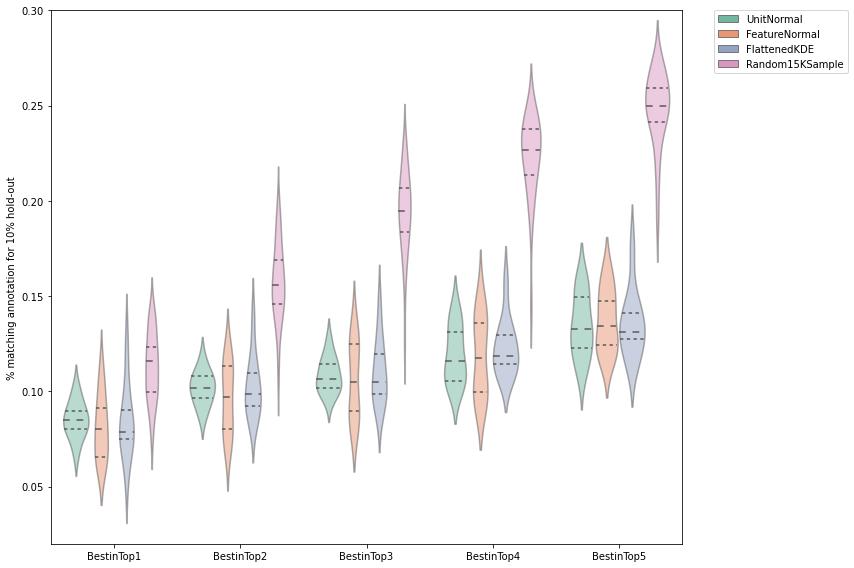

In [6]:
plt.figure(figsize=(12,8))
ax = sns.violinplot(data=summaryScores2,palette='Set2',kind='violin',hue='NullModel',x='BestInTop',y=0,
                    inner='quartiles',position=0)
ax.get_xticks()
plt.setp(ax.collections,alpha=.5)
# sns.pointplot(x='BestInTop',y=0,hue='NullModel',data=summaryScores2,palette='Set1',marker='.',
#               size=15,linestyle="")
plt.ylabel('% matching annotation for 10% hold-out')
plt.xlabel("")
plt.ylim(0.02,0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()
# plt.savefig('repeated10holdOut_summary.png')

#### Create the % matching annotation for 10% hold-out violin plots for the sig class only

In [79]:
summaryScores_sig = pd.read_excel('Densities2Classes_sigClass/repeatedhold10_summaryPcts.xlsx',sheet_name=None,index_col=0)
summaryScores_sig.pop('Averaging')
# [summaryScores_sig.pop(x) for x in summaryScores_sig.copy().keys() if not x.endswith('_2')]
nullNames = [summaryScores_sig[x].index.name for x in summaryScores_sig.keys()]
# [summaryScores_sig[x].index.set_names(None,inplace=True) for x in summaryScores_sig.keys()]

# summaryScores_sig = {y:summaryScores_sig[x] for x,y in zip(summaryScores_sig.keys(),nullNames)}
summaryScores_sig = pd.concat(summaryScores_sig)
summaryScores_sig.index = summaryScores_sig.index.swaplevel()
summaryScores_sig
summaryScores_sig.index = pd.MultiIndex.from_tuples([(x,y.split("_")[0]) for x,y in summaryScores_sig.index], names=('BestInTop','NullModel'))
summaryScores_sig.columns = [x if not x[-2]=="." else x.split('.')[0] for x in summaryScores_sig.columns]


allAvg_sig = summaryScores_sig[[x for x in summaryScores_sig.columns if 'average' in x]]
summaryScores_sig1 = summaryScores_sig.drop(columns=[x for x in summaryScores_sig.columns if 'average' in x])
summaryScores_sig1.T

BestInTop                BestinTop1                BestinTop2  \
NullModel Random15KSample-noStretch Random15KSample-noStretch   
fold_0                     0.229947                  0.283422   
fold_1                     0.224599                  0.326203   
fold_2                     0.208556                  0.262032   
fold_3                     0.251337                  0.326203   
fold_4                     0.262032                  0.368984   
fold_5                     0.213904                  0.294118   
fold_6                     0.267380                  0.342246   
fold_7                     0.224599                  0.320856   
fold_8                     0.197861                  0.304813   
fold_9                     0.203209                  0.278075   

BestInTop                BestinTop3                BestinTop4  \
NullModel Random15KSample-noStretch Random15KSample-noStretch   
fold_0                     0.320856                  0.379679   
fold_1                     0.422460                  0.481283   
fold_2                     0.331551                  0.379679   
fold_3                     0.390374                  0.427807   
fold_4                     0.422460                  0.449198   
fold_5                     0.315508                  0.374332   
fold_6                     0.417112                  0.449198   
fold_7                     0.379679                  0.433155   
fold_8                     0.379679                  0.427807   
fold_9                     0.358289                  0.427807   

BestInTop                BestinTop5                BestinTop1  \
NullModel Random15KSample-noStretch Random15KSample-noStretch   
fold_0                     0.417112                  0.219251   
fold_1                     0.508021                  0.219251   
fold_2                     0.417112                  0.213904   
fold_3                     0.459893                  0.208556   
fold_4                     0.470588                  0.229947   
fold_5                     0.454545                  0.208556   
fold_6                     0.486631                  0.229947   
fold_7                     0.481283                  0.213904   
fold_8                     0.465241                  0.192513   
fold_9                     0.486631                  0.224599   

BestInTop                BestinTop2                BestinTop3  \
NullModel Random15KSample-noStretch Random15KSample-noStretch   
fold_0                     0.326203                  0.401070   
fold_1                     0.326203                  0.401070   
fold_2                     0.283422                  0.320856   
fold_3                     0.320856                  0.411765   
fold_4                     0.320856                  0.401070   
fold_5                     0.304813                  0.379679   
fold_6                     0.315508                  0.347594   
fold_7                     0.315508                  0.379679   
fold_8                     0.283422                  0.342246   
fold_9                     0.342246                  0.385027   

BestInTop                BestinTop4                BestinTop5  ...  \
NullModel Random15KSample-noStretch Random15KSample-noStretch  ...   
fold_0                     0.454545                  0.508021  ...   
fold_1                     0.465241                  0.502674  ...   
fold_2                     0.368984                  0.449198  ...   
fold_3                     0.470588                  0.497326  ...   
fold_4                     0.465241                  0.491979  ...   
fold_5                     0.422460                  0.470588  ...   
fold_6                     0.395722                  0.438503  ...   
fold_7                     0.411765                  0.486631  ...   
fold_8                     0.379679                  0.427807  ...   
fold_9                     0.427807                  0.508021  ...   

BestInTop     BestinTop1     Bestin

{'Random15KSample-noStretch': 0.216577540106952, 'Random15KSample-Stretch': 0.171657754010695, 'FeatureNormalNull': 0.0978609625668449, 'FlattenKDENull': 0.0962566844919786, 'UnitNormalNull': 0.0925133689839572}


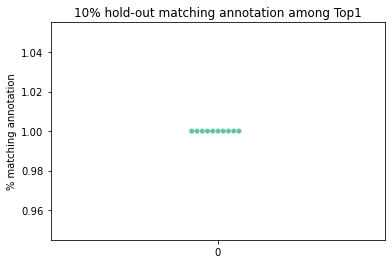

{'Random15KSample-noStretch': 0.310695187165775, 'Random15KSample-Stretch': 0.261497326203209, 'FeatureNormalNull': 0.15668449197861, 'FlattenKDENull': 0.145989304812834, 'UnitNormalNull': 0.144385026737968}


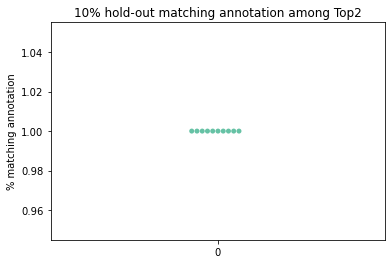

{'Random15KSample-noStretch': 0.370053475935829, 'Random15KSample-Stretch': 0.321390374331551, 'FeatureNormalNull': 0.194652406417112, 'FlattenKDENull': 0.180748663101604, 'UnitNormalNull': 0.185561497326203}


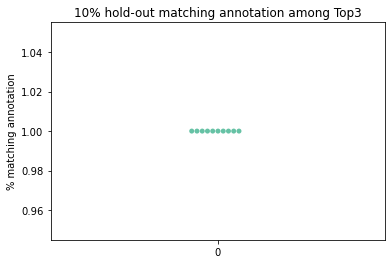

{'Random15KSample-noStretch': 0.417112299465241, 'Random15KSample-Stretch': 0.358823529411765, 'FeatureNormalNull': 0.232085561497326, 'FlattenKDENull': 0.218716577540107, 'UnitNormalNull': 0.221925133689839}


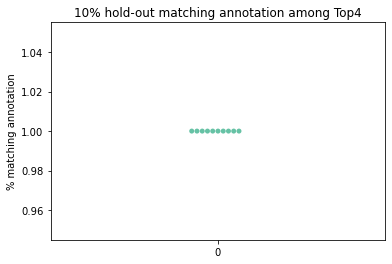

{'Random15KSample-noStretch': 0.457754010695187, 'Random15KSample-Stretch': 0.406951871657754, 'FeatureNormalNull': 0.261497326203209, 'FlattenKDENull': 0.251871657754011, 'UnitNormalNull': 0.259893048128342}


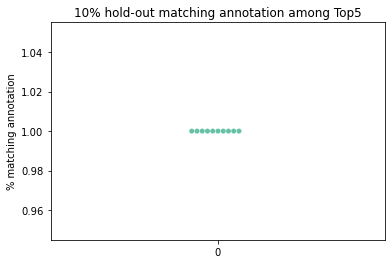

Index(['BestinTop1', 'BestinTop2', 'BestinTop3', 'BestinTop4', 'BestinTop5',
       'BestinTop1', 'BestinTop2', 'BestinTop3', 'BestinTop4', 'BestinTop5',
       'BestinTop1', 'BestinTop2', 'BestinTop3', 'BestinTop4', 'BestinTop5',
       'BestinTop1', 'BestinTop2', 'BestinTop3', 'BestinTop4', 'BestinTop5',
       'BestinTop1', 'BestinTop2', 'BestinTop3', 'BestinTop4', 'BestinTop5',
       'BestinTop1', 'BestinTop2', 'BestinTop3', 'BestinTop4', 'BestinTop5',
       'BestinTop1', 'BestinTop2', 'BestinTop3', 'BestinTop4', 'BestinTop5',
       'BestinTop1', 'BestinTop2', 'BestinTop3', 'BestinTop4', 'BestinTop5',
       'BestinTop1', 'BestinTop2', 'BestinTop3', 'BestinTop4', 'BestinTop5'],
      dtype='object', name='BestInTop')


NullModel   BestInTop   average
0   Random15KSample-noStretch  BestinTop1  0.228342
1   Random15KSample-noStretch  BestinTop2  0.310695
2   Random15KSample-noStretch  BestinTop3  0.373797
3   Random15KSample-noStretch  BestinTop4  0.422995
4   Random15KSample-noStretch  BestinTop5  0.464706
5   Random15KSample-noStretch  BestinTop1  0.216043
6   Random15KSample-noStretch  BestinTop2  0.313904
7   Random15KSample-noStretch  BestinTop3  0.377005
8   Random15KSample-noStretch  BestinTop4  0.426203
9   Random15KSample-noStretch  BestinTop5  0.478075
10  Random15KSample-noStretch  BestinTop1  0.216578
11  Random15KSample-noStretch  BestinTop2  0.310695
12  Random15KSample-noStretch  BestinTop3  0.370053
13  Random15KSample-noStretch  BestinTop4  0.417112
14  Random15KSample-noStretch  BestinTop5  0.457754
15    Random15KSample-Stretch  BestinTop1  0.179679
16    Random15KSample-Stretch  BestinTop2  0.267914
17    Random15KSample-Stretch  BestinTop3  0.335294
18    Random15KSample-Stretch  BestinTop4  0.386631
19    Random15KSample-Stretch  BestinTop5  0.427807
20    Random15KSample-Stretch  BestinTop1  0.188235
21    Random15KSample-Stretch  BestinTop2  0.275936
22    Random15KSample-Stretch  BestinTop3  0.347594
23    Random15KSample-Stretch  BestinTop4  0.399465
24    Random15KSample-Stretch  BestinTop5  0.441711
25    Random15KSample-Stretch  BestinTop1  0.171658
26    Random15KSample-Stretch  BestinTop2  0.261497
27    Random15KSample-Stretch  BestinTop3  0.321390
28    Random15KSample-Stretch  BestinTop4  0.358824
29    Random15KSample-Stretch  BestinTop5  0.406952
30          FeatureNormalNull  BestinTop1  0.097861
31          FeatureNormalNull  BestinTop2  0.156684
32          FeatureNormalNull  BestinTop3  0.194652
33          FeatureNormalNull  BestinTop4  0.232086
34          FeatureNormalNull  BestinTop5  0.261497
35             FlattenKDENull  BestinTop1  0.096257
36             FlattenKDENull  BestinTop2  0.145989
37             FlattenKDENull  BestinTop3  0.180749
38             FlattenKDENull  BestinTop4  0.218717
39             FlattenKDENull  BestinTop5  0.251872
40             UnitNormalNull  BestinTop1  0.092513
41             UnitNormalNull  BestinTop2  0.144385
42             UnitNormalNull  BestinTop3  0.185561
43             UnitNormalNull  BestinTop4  0.221925
44             UnitNormalNull  BestinTop5  0.259893

<Figure size 720x576 with 0 Axes>

In [80]:
for i in range(5):
    data = summaryScores_sig.loc[f'BestinTop{i+1}'].copy()
#     print(data.head())
#     print(data.stack())
    avgs = data.average.copy()
    data.drop(columns='average',inplace=True)
#     print(avgs)
#     ax = data.T.plot()
    ax = sns.swarmplot(data=data.any(),palette='Set2')
    print(avgs.to_dict())

    xmin,xmax = ax.get_xlim()
    handles, labels = ax.get_legend_handles_labels()

#     for j,(label, y) in enumerate(avgs.to_dict().items()):
#         plt.hlines(y=y,xmin=xmin,xmax=xmax,label=label,color=handles[j].get_color(),ls='--')
    
    plt.ylabel("% matching annotation")
#     ax.set_xticklabels(ax.get_xticklabels(),rotation=45,size=12,ha='right', rotation_mode='anchor')
    plt.title(f'10% hold-out matching annotation among Top{i+1}')
    plt.show()
    plt.close()

summaryScores_sig1.index = summaryScores_sig1.index.swaplevel()
print(summaryScores_sig1.T.columns.get_level_values(1))
# ax = sns.stripplot(data=summaryScores1.T,palette='Set1',hue=summaryScores1.T.columns.get_level_values(1))
summaryScores_sig2 = summaryScores_sig1.stack().reset_index()
summaryScores_sig2
plt.figure(figsize=(10,8))
allAvg_sig.index = allAvg_sig.index.swaplevel()
allAvg_sig = allAvg_sig.reset_index()
allAvg_sig

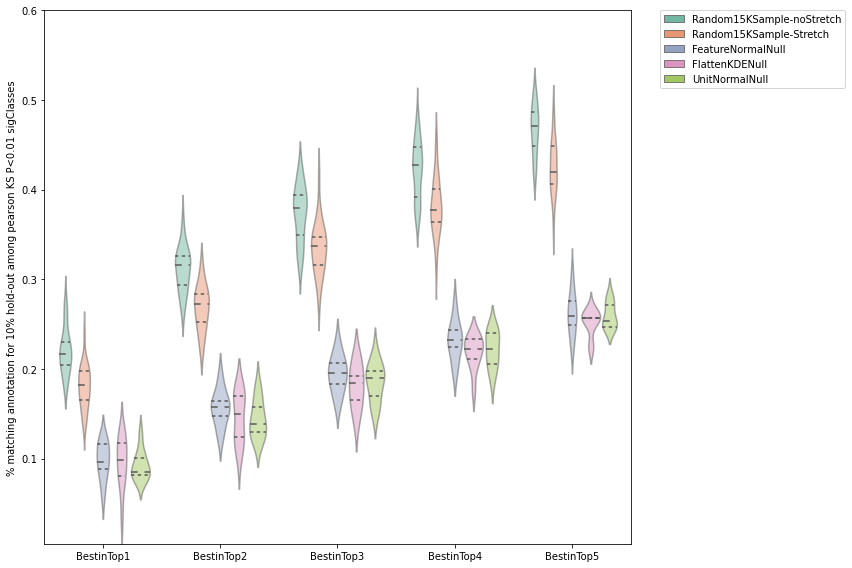

In [82]:
plt.figure(figsize=(12,8))
ax = sns.violinplot(data=summaryScores_sig2,palette='Set2',kind='violin',hue='NullModel',x='BestInTop',y=0,
                    inner='quartiles',position=0)
ax.get_xticks()
plt.setp(ax.collections,alpha=.5)
# sns.pointplot(x='BestInTop',y=0,hue='NullModel',data=summaryScores2,palette='Set1',marker='.',
#               size=15,linestyle="")
plt.ylabel('% matching annotation for 10% hold-out among pearson KS P<0.01 sigClasses')
plt.xlabel("")
plt.ylim(0.005,0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
# plt.show()
plt.savefig('Densities2Classes_sigClass/sigClass_repeated10holdOut_summary.png')

I think we might need to have a plot with eValue on one acess and average model accuracy on the other, with point hue indicating whether the call matches the annotation, maybe?

essentially we need to find a way to link eValue to the accuracy?


One way to maybe do this is doing a multi-model benchmarking study, with pycaret, and following what the supplemental class dependant sig thresholding kinda described in this paper: https://pubs.acs.org/doi/full/10.1021/acs.analchem.7b03820, that Tim suggested in order to possibly solve the class-dependant differences in pertinent eValue

In [6]:
!conda activate pycaret

In [3]:
import pycaret

In [4]:
help(pycaret)

Help on package pycaret:

NAME
    pycaret

PACKAGE CONTENTS
    anomaly
    arules
    classification
    clustering
    containers (package)
    datasets
    distributions
    internal (package)
    loggers (package)
    nlp
    parallel (package)
    regression
    tests (package)
    utils

VERSION
    2.3.10

FILE
    c:\users\traveler\appdata\roaming\python\python37\site-packages\pycaret\__init__.py




In [7]:
!conda env list

# conda environments:
#
                         C:\Program Files\Orange
base                  *  C:\ProgramData\Miniconda3
cellprofiler             C:\Users\TRaveler\.conda\envs\cellprofiler
deepbgc                  C:\Users\TRaveler\.conda\envs\deepbgc
pycaret                  C:\Users\TRaveler\.conda\envs\pycaret

